In [20]:
import pandas as pd
import os
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import graphviz 
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from pandas.util import hash_pandas_object
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from typing import Optional, List, Any
%matplotlib inline
from IPython.core.debugger import set_trace
from dateutil.parser import parse
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
import geopy.distance
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score


In [2]:
train_set_df_orig = pd.read_csv("port_visits_train.csv", parse_dates = ['start_time'], date_parser = parse )
train_vessels_labels_orig = pd.read_csv("vessels_labels_train.csv", index_col='vessel_id' )

In [3]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 44.7+ MB


In [4]:
train_set_df_orig['type'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'type'])
train_set_df_orig['label'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'label'])

In [6]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
 8   type          732484 non-null  object        
 9   label         732484 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 55.9+ MB


# EDA

## Initial examination of the raw data ##

### Unique vessels ###

In [7]:
uniqe_ves_ids_train_orig = np.unique(train_set_df_orig.ves_id)
len(uniqe_ves_ids_train_orig)

21122

In [8]:
len(train_vessels_labels_orig)

21642

Index(['56d8509fe4b099a29d073a62', '56d950d9e4b0e60539c6b71d',
       '56d85a07e4b0fb60063969d8', '56d85736e4b030f1c0039905',
       '56db31f9e4b02c227b748c14', '56d839f0e4b002eabab58240',
       '56dcc15fe4b009004fbe1a23', '56d96d9ee4b0515e6629201a',
       '56db8801e4b07967d3afcb96', '56d8367be4b0550004876e52',
       ...
       '56db7ddbe4b08b5ca584321a', '56dcd51be4b0a2087a7cede2',
       '56dc34b4e4b0c3380a936c08', '56d835abe4b01b88a1e19dcb',
       '56d835abe4b01b88a1e19dce', '56d83d91e4b0370600ea6b14',
       '56d98b06e4b036f77e70799a', '56d8348ee4b026569c5ac90f',
       '56d8348ee4b026569c5ac90c', '56d83d91e4b0370600ea6b19'],
      dtype='object', name='vessel_id', length=21642)

In [14]:
labels_vess_ids_intersect = set(uniqe_ves_ids_train_orig).intersection(train_vessels_labels_orig.index)
labels_vess_ids_diff = set(train_vessels_labels_orig.index ).difference(uniqe_ves_ids_train_orig)
print(f"There are {len(labels_vess_ids_intersect)} vess_ids appearing both in the train df and lables df")
print(f"There are {len(labels_vess_ids_diff)} vess_ids appearing in the lables df but not in the labels_vess_ids_diff")

There are 21122 vess_ids appearing both in the train df and lables df
There are 520 vess_ids appearing in the lables df but not in the labels_vess_ids_diff


### Unique ports ###

In [16]:
num_unique_ports_in_train = len(np.unique(train_set_df_orig.port_id.dropna()))
print(f"there are {num_unique_ports_in_train} unique ports in the train set")

there are 3590 unique ports in the train set


**The distribution of the labels is around 13.7% 1 (Tanker) and 86.3% 0 (not a tanker)**

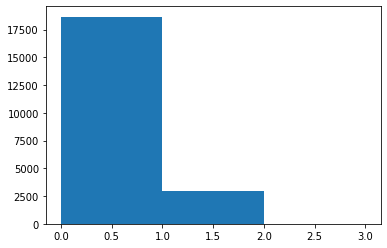

In [17]:
y_train_raw = train_vessels_labels_orig.label
counts = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [18]:
counts[0]/counts[0].sum()*100

array([86.22585713, 13.77414287,  0.        ])

### The subset of ports visited by tankers ###

In [19]:
tankers_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1652 ports visited by tankers, which are 46.02% of the overall ports


In [20]:
all_ports_set = set(np.unique(train_set_df_orig.port_id.dropna()))
non_tanker_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==0])
print("The intersection between the tankers ports and non-tanker ports is of size {} ".format(len(non_tanker_ports_set.intersection(tankers_ports_set))))

The intersection between the tankers ports and non-tanker ports is of size 1520 


## Data cleaning ##

In [68]:
![ports_vid_56dd02bde4b02341a159b0ab_before_cleaning.JPG](attachment:ports_vid_56dd02bde4b02341a159b0ab_before_cleaning.JPG)

'[ports_vid_56dd02bde4b02341a159b0ab_before_cleaning.JPG]' is not recognized as an internal or external command,
operable program or batch file.


In [32]:
#Based on https://www.marineinsight.com/guidelines/speed-of-a-ship-at-sea/
# https://en.wikipedia.org/wiki/Fishing_vessel#:~:text=The%20trolling%20line%20is%20towed,canoes%20with%20outriggers%20for%20stability.
# https://www.weeksmarine.com/equipment-division/tugboats
vess_velocities_kmph = {
    'Bulk Carrier': 15*1.852,
    'Container Vessel' : 24*1.852 , 
    'Fishing Vessel' : 11*1.852,
    'Oil Tanker': 17*1.852,
    'Passenger Vessel': 20*1.852, 
    'Reefer': 20*1.852, 
    'Tug':14*1.852
    
}

MIN_DIST_KM = 0.5

def calc_dist_km(lat_lng_1, lat_lng_2):
        return geopy.distance.geodesic(lat_lng_1, lat_lng_2).km

def calc_timediff_hours(prev_row_start_time, curr_row_start_time):
    delta = curr_row_start_time - prev_row_start_time
    return delta.days*24 + delta.seconds/3600
    
# Simplest approach - it's valid if the distance can be covered by the start times differences.
def is_valid_travel(prev_row, curr_row):
 
    if prev_row is None:
        return True, 1000000000000000 #Ideally, we won't give the first row this privilege 
    dist = calc_dist_km(prev_row[['Lat', 'Long']], curr_row[['Lat', 'Long']])
    #If we haven't moved at all - consider this as an invalid travel
    if dist <= MIN_DIST_KM:
        return False, -1
    airline_travel_duration_hours = dist/vess_velocities_kmph[curr_row['type']]
    start_times_diff_hours =  calc_timediff_hours(prev_row.start_time, curr_row.start_time )
    is_v = airline_travel_duration_hours <=  start_times_diff_hours
    max_bound = (start_times_diff_hours - airline_travel_duration_hours)*60
    return is_v, max_bound

       

def  amend_zero_durations(valid_rows: List[pd.DataFrame], idx: List[int]):
    cleaned_df = pd.DataFrame(valid_rows, index = idx)
    
    if cleaned_df['duration_min'].isnull().values.any():
        nan_entries_port_ids = set(cleaned_df['port_id'][cleaned_df['duration_min'].isnull()])
        means_per_port = {}
        grpd_by_port = cleaned_df.groupby('port_id')
        for port_id in nan_entries_port_ids:
            means_per_port[port_id] = np.nanmean(grpd_by_port.get_group(port_id).duration_min)
        for pid,pmean in means_per_port.items():
            cleaned_df.loc[(cleaned_df['port_id'] == pid) & (cleaned_df['duration_min'].isnull()),'duration_min'] = pmean
        #If we don't have the per-port - use the overall average.
        global_mean = np.nanmean(cleaned_df['duration_min'].values)
        cleaned_df.loc[cleaned_df['duration_min'].isnull(), 'duration_min'] = global_mean if not np.isnan(global_mean) else 0
    #TODO: if there's more time - use the mean over all vessels of the same type.
    return cleaned_df
        
def clean_ves_df(raw_ves_df: pd.DataFrame) -> pd.DataFrame:
    valid_rows = []
    idx = []
    prev_row = None
    #Filter out unfeasible travels
    for ind,r in raw_ves_df.sort_values(by = ['start_time']).iterrows():
     
        valid_travel, upper_duration_bound =  is_valid_travel(prev_row, r)
        if valid_travel:
            idx.append(ind)
            if len(valid_rows) > 0 :
                valid_rows[-1]['duration_min'] =  min(valid_rows[-1]['duration_min'], upper_duration_bound)
            if r['duration_min'] <= 0:
                r['duration_min'] = np.nan
            valid_rows.append(r)
            prev_row = r
        else:
            pass

    cleaned_df =  amend_zero_durations(valid_rows, idx)
    return cleaned_df

def clean_raw_port_visits(visits_df: pd.DataFrame) -> pd.DataFrame:
    cleaned_per_ves_lst = []
    for vid,ves_df in visits_df.groupby('ves_id'):
        cleaned_per_ves_lst.append(clean_ves_df(ves_df))
        print(f"finished vid {vid}")
    return pd.concat(cleaned_per_ves_lst)

In [21]:
# cleaned_raw_df = clean_raw_port_visits(train_set_df_orig)
cleaned_raw_df = pd.read_csv('training_cleaned.csv', index_col=0)

In [26]:
cleaned_raw_df.to_csv('training_cleaned.csv')

In [8]:
print(f"Before cleaning, there were overall { len(train_set_df_orig) } rows. After cleaning there are { len(cleaned_raw_df)} rows")

Before cleaning, there were overall 732484 rows. After cleaning there are 674240 rows


## Duration distribution as a function of the vessel type ##

### Durations distribution per port ###

In [23]:
train_df_to_work_with = cleaned_raw_df

There were 45 tankers visits and 589 non-tanker visits to port 5358fc78b68ca120a07dba30


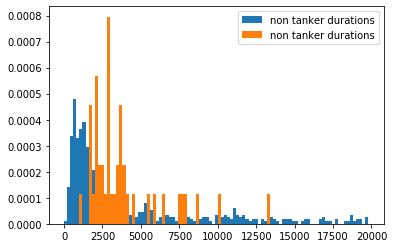

In [29]:
ports_lst = list(tankers_ports_set)
# curr_port = next(iter(tankers_ports_set))
curr_port = ports_lst[279]
curr_port_visits = train_df_to_work_with[train_df_to_work_with['port_id'] == curr_port]
curr_port_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==1]['duration_min']
curr_port_non_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==0]['duration_min']
print(f"There were {len(curr_port_tanker_visits_durations)} tankers visits and {len(curr_port_non_tanker_visits_durations)} non-tanker visits to port {curr_port}")
fig_visits, ax_visits = plt.subplots()
bins = np.arange(0,20000, 200)
ax_visits.hist(curr_port_non_tanker_visits_durations, bins=bins, density=True, label = "non tanker durations")
ax_visits.hist(curr_port_tanker_visits_durations,  bins=bins, density=True, label = "non tanker durations")
plt.legend()


(array([  0., 353., 183., 136., 122.,  70.,  91.,  63.,  76.,  61.,  40.,
         53.,  53.,  45.,  40.,  28.,  29.,  23.,  32.,  34.,  38.,  22.,
         24.,  30.,  22.,  14.,  20.,  23.,  21.,  27.,  19.,  21.,  26.,
         22.,  16.,  19.,  21.,  12.,  16.,  13.,  18.,  18.,  13.,   8.,
         20.,  16.,  13.,  12.,  20.,  10.,   7.,   9.,  13.,   7.,  12.,
         11.,   8.,  12.,   7.,  15.,  13.,  15.,  12.,  11.,   9.,   9.,
         11.,  10.,  15.,   4.,   8.,   5.,  10.,   9.,   7.,   4.,   8.,
          8.,   6.,   9.,   3.,   9.,   8.,   6.,   6.,   8.,   8.,   9.,
         10.,   5.,   7.,   7.,   2.,   2.,   8.,   3.,  10.,   4.,   7.,
          7.,   3.,   5.,  12.,   5.,   4.,   5.,   2.,   5.,   6.,   7.,
          6.,   5.,   2.,   4.,   5.,   8.,   2.,   5.,   2.,   4.,   5.,
          4.,   7.,   6.,   2.,   6.,   8.,   6.,   4.,   3.,   2.,   3.,
          3.,   4.,   2.,   4.,   3.,   4.,   2.,   4.,   3.,   4.,   6.,
          2.,   3.,   5.,   4.,   4., 

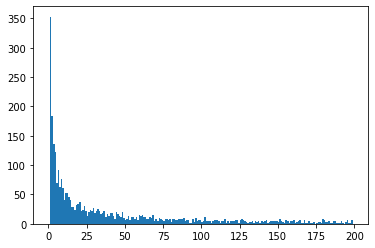

In [13]:
num_visits_per_port = [len(pdf) for pid,pdf in train_df_to_work_with.groupby('port_id')]
plt.hist(num_visits_per_port, bins=np.arange(200))

In [14]:
len(num_visits_per_port)

3586

### Durations distribution per vessel ###

In [30]:
tanker_grouped = train_df_to_work_with[train_df_to_work_with['label']==1].groupby('ves_id')
tanker_grouped_iter = iter(tanker_grouped)
non_tanker_grouped = train_df_to_work_with[train_df_to_work_with['label']==0].groupby('ves_id')
non_tanker_grouped_iter = iter(non_tanker_grouped)

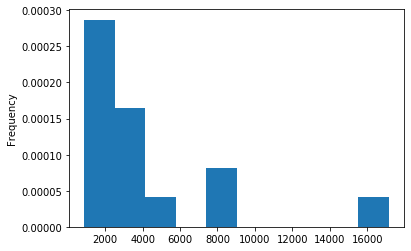

In [33]:
curr_tanker_df = next(tanker_grouped_iter)[1]
curr_tanker_df['duration_min'].plot.hist(density = True)

# non_tanker_grouped.get_group('56d8fabbe4b00724c0f7520b')['duration_min'].plot.hist()

### Durations distribution per class ###

1293.0
644.81


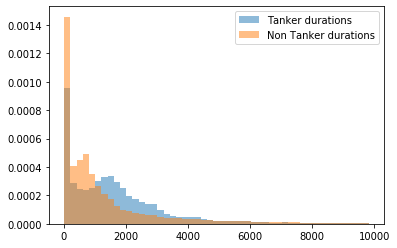

In [34]:
all_tanker_durations = train_df_to_work_with[train_df_to_work_with['label']==1]['duration_min']
all_non_tanker_durations = train_df_to_work_with[train_df_to_work_with['label']==0]['duration_min']
fig_durations,ax_durations = plt.subplots()
durations_bins = np.arange(10,10000, 200)
ax_durations.hist(all_tanker_durations, bins = durations_bins, density=True, label = 'Tanker durations', alpha=0.5)
ax_durations.hist(all_non_tanker_durations, bins = durations_bins, density=True, label = 'Non Tanker durations', alpha=0.5)
plt.legend()
print(np.median(all_tanker_durations.values))
print(np.median(all_non_tanker_durations.values))

**Num samples and overall series duration per vessel**

In [410]:
train_orig_grouped = train_df_to_work_with.groupby('ves_id')


In [36]:
per_ves_ts_len_tanker = []
per_ves_ts_duration_tanker = []
overall_deltas_tanker = np.array([])
per_ves_ts_len_non_tanker = []
per_ves_ts_duration_non_tanker = []
overall_deltas_non_tanker = np.array([])

for vid, vdf in train_orig_grouped:
#     print(vid)
    is_tanker = vdf.iloc[0]['label'] == 1
    per_ves_ts_len  = per_ves_ts_len_tanker if is_tanker else per_ves_ts_len_non_tanker
    per_ves_ts_len.append(len(vdf))
    sorted_ts = vdf['start_time'].sort_values().values
    deltas = sorted_ts[1:] - sorted_ts[:-1]
    if is_tanker:
        overall_deltas_tanker = np.append(overall_deltas_tanker, deltas.astype('timedelta64[m]').astype('int'))
    else:
        overall_deltas_non_tanker = np.append(overall_deltas_non_tanker, deltas.astype('timedelta64[m]').astype('int'))
    per_ves_ts_duration = per_ves_ts_duration_tanker if is_tanker else per_ves_ts_duration_non_tanker
    per_ves_ts_duration.append(sorted_ts[-1]-sorted_ts[0])
    

NameError: name 'train_orig_grouped' is not defined

In [289]:
overall_deltas_tanker

array([19337., 44039., 32045., ...,  2005.,  6043.,  6815.])

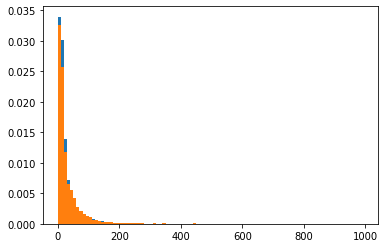

In [273]:
fig_ts_len, ax_ts_len = plt.subplots()
ax_ts_len.hist(per_ves_ts_len_tanker, bins=np.arange(0,1000,10), label='Tanker', density=True);
ax_ts_len.hist(per_ves_ts_len_non_tanker, bins=np.arange(0,1000,10), label='Non Tanker', density=True);

In [262]:
min(per_ves_ts_len)

1

In [249]:
np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int')

array([250356, 148235, 252381, ...,   1542,      0,      0])

NameError: name 'per_ves_ts_duration_non_tanker' is not defined

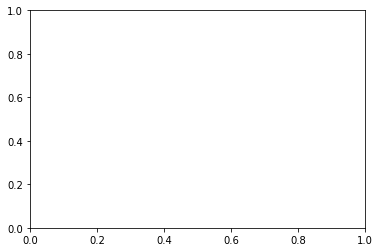

In [35]:
fig_ts_duration, ax_ts_duration = plt.subplots()
ax_ts_duration.hist(np.array(per_ves_ts_duration_non_tanker).astype('timedelta64[m]').astype('int'), label='Non Tanker', density=True, alpha=0.5);
ax_ts_duration.hist(np.array(per_ves_ts_duration_tanker).astype('timedelta64[m]').astype('int'), label='Tanker', density=True, alpha=0.5);

ax_ts_duration.legend()
# plt.hist(np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int'), density=True);

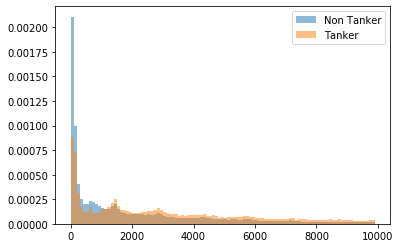

In [295]:
fig_ts_deltas, ax_ts_deltas = plt.subplots()
ax_ts_deltas.hist(overall_deltas_non_tanker,  label='Non Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.hist(overall_deltas_tanker,  label='Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.legend()

In [298]:
tanker_grouped_lst = list(tanker_grouped)
tanker_lst_lens = [len(vdf) for vid,vdf in tanker_grouped_lst]

In [302]:
np.argmax(tanker_lst_lens)

2741

In [300]:
len(tanker_lst_lens)

2898

In [313]:
# tanker_grouped_lst[2741][1].to_csv("tanker_2741.csv")
len(pd.unique(tanker_grouped_lst[2741][1]['port_id']))
curr_tanker_sorted_df = tanker_grouped_lst[2741][1].sort_values('start_time')
curr_tanker_sorted_df.to_csv("tanker_2741.csv")

In [316]:
non_tanker_grouped_lst = list(non_tanker_grouped)
non_tanker_lst_lens = [len(vdf) for vid,vdf in non_tanker_grouped_lst]

In [317]:
np.argmax(non_tanker_lst_lens)

9933

In [322]:
curr_non_tanker_sorted_df = non_tanker_grouped_lst[9933][1].sort_values('start_time')
curr_non_tanker_sorted_df.to_csv("non_tanker_9933.csv")

**Vess 56d96c11e4b0436ba6e245ca is a passenger vessel - it just travels between two ports: Cowes Harbour and southhampton**

In [24]:

vess_by_type = defaultdict(list)
for vid,vdf in train_orig_grouped:
    vess_by_type[vdf.iloc[0]['type']].append(vdf)



C:\Users\Matan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\Matan\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning:

invalid value encountered in true_divide



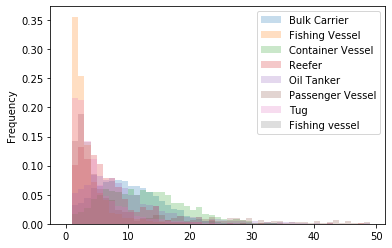

In [72]:
num_locations_per_type = { k : pd.Series( [len(np.unique(vdf['port_id'])) for vdf in vess_by_type[k]]) for k in vess_by_type}
pd.DataFrame(num_locations_per_type).plot.hist(alpha=0.25, density=True, bins=bins_for_num_locations)

In [47]:
non_tanker_num_locations = pd.Series(np.concatenate([loc_ser.values for k,loc_ser in  num_locations_per_type.items() if k != 'Oil Tanker' ]))

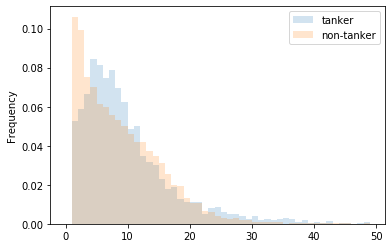

In [74]:
pd.DataFrame({"tanker": num_locations_per_type['Oil Tanker'],  "non-tanker": non_tanker_num_locations }).plot.\
hist(alpha=0.2, density=True, bins=bins_for_num_locations)

In [44]:
len(non_tanker_num_locations)

18224

In [54]:
len(non_tanker_num_locations.index.unique()) + len(num_locations_per_type['Oil Tanker'])

21122

In [53]:
sum([len(s) for s in num_locations_per_type.values() ])

21122

In [62]:
bins_for_num_locations = np.arange(0, 50, 1)

(array([0.        , 0.05248619, 0.05904696, 0.06664365, 0.08425414,
        0.08149171, 0.07458564, 0.07872928, 0.06975138, 0.0621547 ,
        0.04868785, 0.05006906, 0.03487569, 0.03176796, 0.03004144,
        0.02279006, 0.0179558 , 0.01864641, 0.01277624, 0.01104972,
        0.01139503, 0.01104972, 0.00483425, 0.00828729, 0.0086326 ,
        0.00587017, 0.00517956, 0.00517956, 0.00414365, 0.00241713,
        0.00414365, 0.00207182, 0.00241713, 0.00172652, 0.00241713,
        0.00310773, 0.00241713, 0.00069061, 0.00172652, 0.0003453 ,
        0.00069061, 0.0003453 , 0.00138122, 0.        , 0.0003453 ,
        0.0003453 , 0.        , 0.0003453 , 0.00069061]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

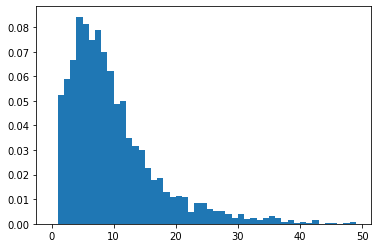

In [63]:
tanker_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Oil Tanker']]
plt.hist(tanker_num_locations, density=True, bins=bins_for_num_locations)

In [38]:
passengers_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Passenger Vessel']]

(array([0.        , 0.14226376, 0.18795431, 0.14018692, 0.08515057,
        0.06022845, 0.04465213, 0.04049844, 0.0238837 , 0.02076843,
        0.01973001, 0.00519211, 0.01038422, 0.00934579, 0.01557632,
        0.0145379 , 0.00726895, 0.01038422, 0.01349948, 0.00415369,
        0.00726895, 0.01142264, 0.00830737, 0.01142264, 0.00415369,
        0.00519211, 0.00934579, 0.00934579, 0.00623053, 0.00934579,
        0.00207684, 0.00623053, 0.00311526, 0.00519211, 0.00415369,
        0.00207684, 0.00311526, 0.00311526, 0.00311526, 0.00207684,
        0.00519211, 0.00207684, 0.00311526, 0.00623053, 0.00207684,
        0.00415369, 0.00103842, 0.00103842, 0.00311526]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

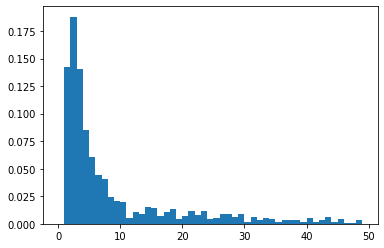

In [66]:
plt.hist(passengers_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.21554661, 0.21275937, 0.14183958, 0.11117993,
        0.06720347, 0.0470734 , 0.03871168, 0.03065965, 0.02880149,
        0.01951068, 0.0142459 , 0.01238774, 0.00836172, 0.00867142,
        0.00836172, 0.00495509, 0.00495509, 0.00526479, 0.00371632,
        0.00309693, 0.00371632, 0.00185816, 0.00123877, 0.00123877,
        0.00030969, 0.00185816, 0.00061939, 0.        , 0.        ,
        0.        , 0.00030969, 0.00030969, 0.        , 0.00092908,
        0.        , 0.        , 0.        , 0.        , 0.00030969,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

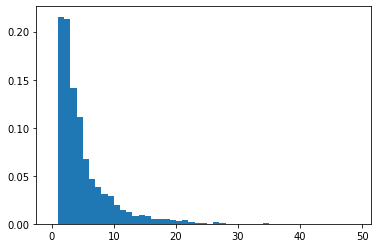

In [67]:
tug_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Tug']]
plt.hist(tug_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.35604607, 0.25335893, 0.13627639, 0.07101727,
        0.05278311, 0.04174664, 0.01775432, 0.01727447, 0.01007678,
        0.01007678, 0.00767754, 0.00863724, 0.00479846, 0.00239923,
        0.00431862, 0.00191939, 0.00095969, 0.00143954, 0.00095969,
        0.        , 0.        , 0.        , 0.        , 0.00047985,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

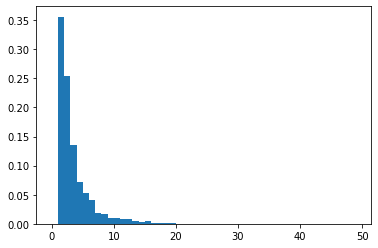

In [68]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Fishing Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.03185407, 0.0358018 , 0.04424176, 0.06180234,
        0.06452491, 0.07160359, 0.07405391, 0.07582358, 0.07391778,
        0.0649333 , 0.06575007, 0.06084944, 0.05417915, 0.04696433,
        0.03906888, 0.0319902 , 0.02613667, 0.02382249, 0.01306834,
        0.01075415, 0.00748707, 0.00558127, 0.00435611, 0.00299483,
        0.00204193, 0.00108903, 0.00081677, 0.00081677, 0.00081677,
        0.00040839, 0.00040839, 0.00054451, 0.00054451, 0.00027226,
        0.        , 0.00013613, 0.00013613, 0.        , 0.00027226,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00013613, 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

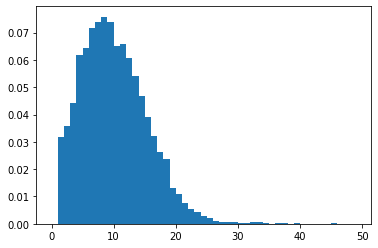

In [69]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Bulk Carrier']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.01658826, 0.02005447, 0.02698688, 0.04184204,
        0.04976479, 0.05917306, 0.05644962, 0.05471651, 0.0514979 ,
        0.06016341, 0.04926962, 0.05793513, 0.05446893, 0.05471651,
        0.05545927, 0.04976479, 0.03490963, 0.03614756, 0.03119584,
        0.02352067, 0.02822481, 0.01634068, 0.01535033, 0.01089379,
        0.0089131 , 0.00569448, 0.00866551, 0.00668482, 0.00495172,
        0.00198069, 0.0017331 , 0.00123793, 0.0017331 , 0.0017331 ,
        0.        , 0.        , 0.        , 0.00049517, 0.00024759,
        0.        , 0.00024759, 0.        , 0.        , 0.00024759,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

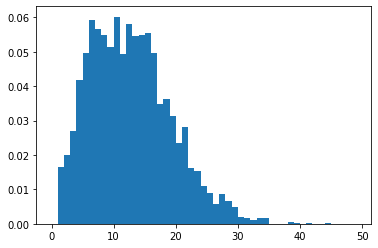

In [70]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Container Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.10153257, 0.13218391, 0.11111111, 0.11877395,
        0.10344828, 0.07854406, 0.07854406, 0.06321839, 0.04214559,
        0.02298851, 0.0210728 , 0.02873563, 0.02298851, 0.03065134,
        0.00383142, 0.00574713, 0.00383142, 0.00383142, 0.00383142,
        0.00383142, 0.00383142, 0.        , 0.00574713, 0.        ,
        0.        , 0.00191571, 0.        , 0.00191571, 0.        ,
        0.        , 0.00191571, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00191571, 0.        , 0.        ,
        0.        , 0.        , 0.00191571, 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

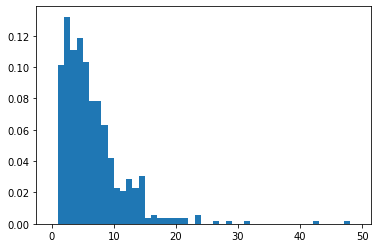

In [75]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Reefer']], density=True, bins=bins_for_num_locations)

In [13]:
np.unique(train_vessels_labels_orig.type)

array(['Bulk Carrier', 'Container Vessel', 'Fishing Vessel', 'Oil Tanker',
       'Passenger Vessel', 'Reefer', 'Tug'], dtype=object)

# Features engineering

### Extractor classes ###

In [28]:
#TODO: use ABC
class FeaturesGenerator:
    def __init__(self):
        pass
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class LabelsGenerator:
    def __init__(self):
        pass
    def generate_labels(self, input_df:pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class FeaturesExtractor:
    def __init__(self, features_generators:List[FeaturesGenerator], labels_generator: LabelsGenerator):
        self.generators_lst = features_generators
        self.labels_generator = labels_generator
    
    #Returns the features dataframe and the labels dataframe
    def generate_features(self, input_df:pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        features_dfs = [gen.generate_features(input_df) for gen in self.generators_lst ]
        features_df = pd.concat(features_dfs, axis=1)
        labels_df = self.labels_generator.generate_labels(input_df)
        if not all(labels_df.index == features_df.index):
            raise Exception("In generate_features(). The labels and features dfs have different index!!")
        return features_df,labels_df

In [62]:
#TODO: check embedding here instead of on-hot-encoding
'''
Encode categorical ports as a one-hot numeric array, and have the per-port value the total stay duration in this port.
Return a dataframe in which each row encodes the durations per port of a single vessel.
'''
from sklearn.preprocessing import OneHotEncoder

class PortsFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        res_df_rows = []
        res_df_ind = []
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(input_df[['port_id']])
        for vid,vdf in input_df.groupby('ves_id'):
            ports_categorized = enc.transform(vdf[['port_id']]).toarray()
            ports_categorized_durations = ports_categorized * vdf[['duration_min']].values
            res_df_ind.append(vid)
            res_df_rows.append(ports_categorized_durations.sum(axis=0))
        return pd.DataFrame(res_df_rows, index = res_df_ind, columns=enc.categories_[0])
            
'''
The spread of the visited locations
'''
from shapely.geometry import MultiPoint
class DistanceStdGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:    
        res_df_rows = []
        res_df_ind = []
        for vid,vdf in input_df.groupby('ves_id'):
            ports_coords = [(lt,lng) for lt,lng in zip(vdf['Lat'], vdf['Long'])]
#             if len(ports_coords) == 1:
#                 ports_coords = [ports_coords[0], ports_coords[0], ports_coords[0]]
#             elif len(ports_coords) == 2:
#                 ports_coords = [ports_coords[0], ports_coords[1], 
#                                 tuple((np.array(ports_coords[0]) + np.array(ports_coords[1]))/2) ]
            locations_polygon = MultiPoint(ports_coords)
            #Probably not the geodetic centroid, but I don't have time to improve this now...
            locations_centroid = locations_polygon.centroid 
#             print(f"vid: {vid}, centroid: {locations_centroid}")
            dists_from_centroid = np.array([calc_dist_km((locations_centroid.x, locations_centroid.y), (lt,lng)) for
                                   lt,lng in zip(vdf['Lat'], vdf['Long'])] )
            res_df_ind.append(vid)
            res_df_rows.append(np.sqrt(dists_from_centroid.dot(dists_from_centroid)/len(dists_from_centroid)))
        return pd.DataFrame(res_df_rows, index = res_df_ind, columns=['ports_std'])
            

'''
The average and median durations in the tankers and non-tanker ports 
'''
class PortsDurationSamplesFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        all_ports_set = set(input_df['port_id'])
        tankers_ports_set = set(input_df['port_id'][input_df['label']==1])
#         non-tankers_ports_set = all_ports_set.difference(tankers_ports_set)
        res_df_rows = []
        res_df_ind = []    
        for vid,vdf in input_df.groupby('ves_id'):

            tankers_inds = vdf['port_id'].apply(lambda p : p in tankers_ports_set)
            res_df_ind.append(vid)
            res_df_rows.append([vdf[tankers_inds]['duration_min'].mean(), vdf[tankers_inds]['duration_min'].median(), 
                                vdf[~tankers_inds]['duration_min'].mean(), vdf[~tankers_inds]['duration_min'].median(), 
                               vdf['duration_min'].mean(), vdf['duration_min'].median()])
        res =  pd.DataFrame(res_df_rows, index = res_df_ind, 
                            columns=['tanker_ports_mean_duration', 'tanker_ports_median_duration', 
                                    'non_tanker_ports_mean_duration', 'non_tanker_ports_median_duration', 
                                     'all_ports_mean_duration', 'all_ports_median_duration' ])
        res = res.fillna(-1)
        return res

class PercentTankersPortsFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        all_ports_set = set(input_df['port_id'])
        tankers_ports_set = set(input_df['port_id'][input_df['label']==1])
        res_df_rows = []
        res_df_ind = []    
        for vid,vdf in input_df.groupby('ves_id'):
            tankers_inds = vdf['port_id'].apply(lambda p : p in tankers_ports_set)
            res_df_ind.append(vid)
            res_df_rows.append([tankers_inds.sum()/len(vdf)])
                               
        res = pd.DataFrame(res_df_rows, index = res_df_ind, columns = ['tankers_ports_percentage'])
        return res
                           
    
    
class BinaryLabelsGenerator(LabelsGenerator):
    def __init__(self):
        pass
    def generate_labels(self, input_df:pd.DataFrame) -> pd.DataFrame:
        patients_classes_df = input_df.groupby('ves_id').nth(0)['label']
        return patients_classes_df
                                                                
        

In [47]:
 tuple((np.array((1,2)) + np.array((3,4)))/2)

(2.0, 3.0)

In [33]:
tankers_ports_set = set(train_df_to_work_with['port_id'][train_df_to_work_with['label']==1])
print(len(tankers_ports_set))
test_grp = train_df_to_work_with.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab')
test_grp

1635


,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,type,label
85153,56dd02bde4b02341a159b0ab,2016-02-12 00:06:42,1128.000000,54a5207d9370ca7b69371294,Peru,-12.040,-77.141,Callao,Oil Tanker,1
637460,56dd02bde4b02341a159b0ab,2016-03-10 01:03:00,667.561962,5358fc78b68ca120a07dbad6,India,16.978,82.279,Kakinada,Oil Tanker,1
637472,56dd02bde4b02341a159b0ab,2016-03-10 16:20:04,28.359609,5358fc78b68ca120a07dbcd9,India,17.692,83.280,Visakhapatnam,Oil Tanker,1
637497,56dd02bde4b02341a159b0ab,2016-03-10 21:01:00,667.561962,5358fc78b68ca120a07dbad6,India,16.978,82.279,Kakinada,Oil Tanker,1
398296,56dd02bde4b02341a159b0ab,2016-03-11 07:02:23,118.354901,5358fc78b68ca120a07dbcd9,India,17.692,83.280,Visakhapatnam,Oil Tanker,1
398297,56dd02bde4b02341a159b0ab,2016-03-11 15:48:40,640.376276,5358fc78b68ca120a07dbad6,India,16.978,82.279,Kakinada,Oil Tanker,1
398300,56dd02bde4b02341a159b0ab,2016-03-12 06:41:37,107.705095,5358fc78b68ca120a07dbcd9,India,17.692,83.280,Visakhapatnam,Oil Tanker,1
620795,56dd02bde4b02341a159b0ab,2016-03-14 12:49:16,8149.838428,5358fc77b68ca120a07db2b2,India,23.233,68.611,Jakhau,Oil Tanker,1
620885,56dd02bde4b02341a159b0ab,2016-03-22 08:59:03,118.354901,5358fc78b68ca120a07dbcd9,India,17.692,83.280,Visakhapatnam,Oil Tanker,1
402707,56dd02bde4b02341a159b0ab,2016-03-23 03:20:42,983.000000,5358fc78b68ca120a07dbad6,India,16.978,82.279,Kakinada,Oil Tanker,1


In [38]:
DistanceStdGenerator().generate_features(test_grp)

,ports_var
56dd02bde4b02341a159b0ab,3911.661712


In [67]:
PortsDurationSamplesFeaturesGenerator().generate_features(test_grp)

,tanker_ports_mean_duration,tanker_ports_median_duration,non_tanker_ports_mean_duration,non_tanker_ports_median_duration,all_ports_mean_duration,all_ports_median_duration
56dd02bde4b02341a159b0ab,672.994782,300.0,-1.0,-1.0,672.994782,300.0


### Features generation ###

In [60]:
# extractor = FeaturesExtractor([PortsFeaturesGenerator()], BinaryLabelsGenerator())
extractor = FeaturesExtractor([PortsDurationSamplesFeaturesGenerator(),
                               PercentTankersPortsFeaturesGenerator(), 
                               DistanceStdGenerator() ], BinaryLabelsGenerator())
features_df, labels_df = extractor.generate_features(train_df_to_work_with)

vid: 56d83489e4b01c7098934f48, centroid: POINT (19.21657142857143 -19.60942857142857)
vid: 56d83489e4b01c7098934f4f, centroid: POINT (35.49266666666666 138.8448333333334)
vid: 56d83489e4b01c7098934f50, centroid: POINT (29.61133333333333 2.190666666666669)
vid: 56d83489e4b01c7098934f51, centroid: POINT (44.41027272727273 -77.86790909090911)
vid: 56d83489e4b025a920ad5e6e, centroid: POINT (9.9915 73.28116666666666)
vid: 56d83489e4b02a0dec522faf, centroid: POINT (27.76524324324323 48.35413513513511)
vid: 56d83489e4b02c65b7730d72, centroid: POINT (29.73161224489796 2.624326530612247)
vid: 56d83489e4b02c65b7730d76, centroid: POINT (29.72488888888888 120.064)
vid: 56d83489e4b02c65b7730d77, centroid: POINT (-11.3684 10.3556)
vid: 56d83489e4b0581dc93c9211, centroid: POINT (3.688027777777779 -71.41966666666666)
vid: 56d83489e4b0ad1bfa26097a, centroid: POINT (28.49912499999999 120.1910416666667)
vid: 56d83489e4b0ad1bfa26097e, centroid: POINT (5.368000000000001 135.3171818181818)
vid: 56d83489e4b0

vid: 56d8348ae4b0c8d95c300922, centroid: POINT (34.16118181818182 76.67854545454544)
vid: 56d8348ae4b0c8d95c300927, centroid: POINT (-35.49394594594594 -57.44556756756756)
vid: 56d8348ae4b0c8d95c30092d, centroid: POINT (29.572 101.40125)
vid: 56d8348ae4b0d38e4536eb48, centroid: POINT (14.58045454545455 99.05636363636364)
vid: 56d8348ae4b0d38e4536eb4a, centroid: POINT (6.918250000000001 37.49299999999999)
vid: 56d8348ae4b0d38e4536eb4d, centroid: POINT (-32.55813043478259 -71.55878260869561)
vid: 56d8348ae4b0d38e4536eb52, centroid: POINT (20.0677 94.24170000000001)
vid: 56d8348ae4b0d38e4536eb54, centroid: POINT (-22.93876865671643 -43.79880597014933)
vid: 56d8348ae4b0d38e4536eb58, centroid: POINT (3.008999999999999 -89.55775)
vid: 56d8348ae4b0d38e4536eb5b, centroid: POINT (33.8715 130.3252647058824)
vid: 56d8348ae4b0d38e4536eb5d, centroid: POINT (65.11150000000001 -22.531)
vid: 56d8348ae4b0d38e4536eb65, centroid: POINT (4.697399999999999 85.22420000000001)
vid: 56d8348ae4b0d38e4536eb66, 

vid: 56d8348be4b025a920ad5e98, centroid: POINT (36.81828767123287 -53.92465753424657)
vid: 56d8348be4b025a920ad5e9b, centroid: POINT (4.898166666666667 76.00758333333334)
vid: 56d8348be4b025a920ad5e9d, centroid: POINT (20.73142857142857 33.63678571428573)
vid: 56d8348be4b025a920ad5ea5, centroid: POINT (37.45035714285714 15.41621428571429)
vid: 56d8348be4b026569c5ac8a2, centroid: POINT (28.6966875 57.79228124999999)
vid: 56d8348be4b026569c5ac8a4, centroid: POINT (29.53416666666666 120.8255)
vid: 56d8348be4b026569c5ac8a6, centroid: POINT (1.2135 88.90000000000001)
vid: 56d8348be4b026569c5ac8b6, centroid: POINT (33.666 -54.27464705882353)
vid: 56d8348be4b026569c5ac8bc, centroid: POINT (10.761875 111.95575)
vid: 56d8348be4b026569c5ac8be, centroid: POINT (25.74942857142858 80.82014285714286)
vid: 56d8348be4b0271c9aa37072, centroid: POINT (25.2681052631579 -55.07773684210525)
vid: 56d8348be4b0271c9aa37073, centroid: POINT (23.3841 59.3771)
vid: 56d8348be4b0271c9aa3707b, centroid: POINT (29.0

vid: 56d8348be4b0ad1bfa2609c1, centroid: POINT (23.53031818181818 -27.25172727272727)
vid: 56d8348be4b0ad1bfa2609c2, centroid: POINT (-36.50833333333333 -33.18766666666667)
vid: 56d8348be4b0ad1bfa2609c5, centroid: POINT (23.6583125 -33.91350000000001)
vid: 56d8348be4b0ad1bfa2609c9, centroid: POINT (35.093 128.96)
vid: 56d8348be4b0b1c94f7bde0b, centroid: POINT (-45.468 -72.81999999999999)
vid: 56d8348be4b0b1c94f7bde0f, centroid: POINT (18.33792857142857 57.76892857142855)
vid: 56d8348be4b0b1c94f7bde16, centroid: POINT (6.432 3.37)
vid: 56d8348be4b0b1c94f7bde18, centroid: POINT (-1.364666666666666 -31.40933333333334)
vid: 56d8348be4b0b1c94f7bde1e, centroid: POINT (49.74316666666666 1.27825)
vid: 56d8348be4b0b1c94f7bde1f, centroid: POINT (-29.879 31.024)
vid: 56d8348be4b0b2a61c63a8ce, centroid: POINT (25.90475 117.9403333333333)
vid: 56d8348be4b0b2a61c63a8d4, centroid: POINT (45.84213145539913 -122.7280915492955)
vid: 56d8348be4b0b2a61c63a8d6, centroid: POINT (16.04464285714286 -58.299714

vid: 56d8348ce4b00146513f8f74, centroid: POINT (39.13072222222222 9.522999999999994)
vid: 56d8348ce4b00146513f8f7f, centroid: POINT (-33.91 18.437)
vid: 56d8348ce4b001f4293429dc, centroid: POINT (30.565 99.80442857142859)
vid: 56d8348ce4b001f4293429e0, centroid: POINT (5.945833333333333 132.0523333333333)
vid: 56d8348ce4b001f4293429e5, centroid: POINT (25.07004494382024 115.6810337078652)
vid: 56d8348ce4b002eabab57ef2, centroid: POINT (67.94499999999999 13.635)
vid: 56d8348ce4b002eabab57efe, centroid: POINT (23.07313333333333 -19.96693333333333)
vid: 56d8348ce4b002eabab57f00, centroid: POINT (31.60996363636364 21.09594545454546)
vid: 56d8348ce4b002eabab57f03, centroid: POINT (33.02791666666666 71.24845833333332)
vid: 56d8348ce4b002eabab57f07, centroid: POINT (-15.3685 109.771)
vid: 56d8348ce4b002eabab57f0c, centroid: POINT (23.7654 2.9897)
vid: 56d8348ce4b002eabab57f0d, centroid: POINT (2.649383333333335 -60.68556666666667)
vid: 56d8348ce4b002eabab57f14, centroid: POINT (18.84723255813

vid: 56d8348ce4b0550004876bb7, centroid: POINT (43.25016666666667 -59.41758333333333)
vid: 56d8348ce4b0550004876bc0, centroid: POINT (14.78873684210528 -72.13142105263157)
vid: 56d8348ce4b0550004876bc1, centroid: POINT (19.7710625 110.571125)
vid: 56d8348ce4b0550004876bc5, centroid: POINT (0.9850000000000008 91.65055555555556)
vid: 56d8348ce4b0550004876bce, centroid: POINT (27.46106896551724 3.231862068965518)
vid: 56d8348ce4b0581dc93c9266, centroid: POINT (31.517 -9.597500000000005)
vid: 56d8348ce4b0581dc93c9268, centroid: POINT (45.832 -73.28399999999998)
vid: 56d8348ce4b0581dc93c926a, centroid: POINT (54.26913084112149 -130.3149626168223)
vid: 56d8348ce4b0581dc93c926b, centroid: POINT (5.992818181818179 138.0917272727273)
vid: 56d8348ce4b0581dc93c926c, centroid: POINT (32.22364000000001 126.80556)
vid: 56d8348ce4b0581dc93c9274, centroid: POINT (15.70919565217391 107.5771521739131)
vid: 56d8348ce4b0581dc93c9275, centroid: POINT (16.98107142857143 109.8633571428571)
vid: 56d8348ce4b05

vid: 56d8348ce4b0de6e5887adb0, centroid: POINT (24.25328571428572 35.17264285714285)
vid: 56d8348ce4b0de6e5887adb2, centroid: POINT (20.68673913043478 101.091)
vid: 56d8348ce4b0de6e5887adb4, centroid: POINT (34.819 135.632)
vid: 56d8348ce4b0e1071229c3f0, centroid: POINT (15.94521739130434 107.7327391304348)
vid: 56d8348ce4b0e1071229c3f1, centroid: POINT (29.50485714285714 -56.05914285714285)
vid: 56d8348ce4b0e1071229c3f4, centroid: POINT (17.78452941176471 120.4401176470588)
vid: 56d8348ce4b0e1071229c3fa, centroid: POINT (25.53022222222223 65.73100000000002)
vid: 56d8348ce4b0e1071229c3fe, centroid: POINT (10.76568518518519 87.38662962962968)
vid: 56d8348ce4b0e178dda670be, centroid: POINT (15.13303703703703 -10.27881481481482)
vid: 56d8348ce4b0e178dda670df, centroid: POINT (-42.03715555555557 -72.17960000000002)
vid: 56d8348ce4b0e47eba0a870f, centroid: POINT (0.5458684210526314 43.2245)
vid: 56d8348ce4b0e47eba0a8714, centroid: POINT (18.13935185185185 100.4127777777778)
vid: 56d8348ce4b

vid: 56d8348de4b025a920ad5f06, centroid: POINT (39.53284615384616 -23.12661538461538)
vid: 56d8348de4b025a920ad5f07, centroid: POINT (31.63966666666667 120.985)
vid: 56d8348de4b025a920ad5f0d, centroid: POINT (46.02652631578947 0.7193157894736842)
vid: 56d8348de4b025a920ad5f11, centroid: POINT (12.191 37.5076)
vid: 56d8348de4b025a920ad5f13, centroid: POINT (29.56775000000001 81.53481250000002)
vid: 56d8348de4b025a920ad5f19, centroid: POINT (-24.72345161290323 -56.8801935483871)
vid: 56d8348de4b025a920ad5f1f, centroid: POINT (-19.15561538461538 8.545615384615385)
vid: 56d8348de4b025a920ad5f22, centroid: POINT (43.78914285714285 -28.19623809523809)
vid: 56d8348de4b026569c5ac8ea, centroid: POINT (34.16416666666667 120.9176666666667)
vid: 56d8348de4b026569c5ac8ec, centroid: POINT (34.866 138.331)
vid: 56d8348de4b026569c5ac8f2, centroid: POINT (22.53984210526315 -25.29615789473684)
vid: 56d8348de4b0271c9aa3709e, centroid: POINT (-1.721357142857141 -13.54364285714287)
vid: 56d8348de4b0271c9aa

vid: 56d8348de4b09ee652001269, centroid: POINT (13.66666666666667 141.4833333333333)
vid: 56d8348de4b09ee65200126f, centroid: POINT (23.26207142857143 112.5218571428572)
vid: 56d8348de4b09ee652001271, centroid: POINT (22.26705882352941 31.1919411764706)
vid: 56d8348de4b09f39bec68132, centroid: POINT (-1.721404761904762 106.9241666666666)
vid: 56d8348de4b09f39bec68135, centroid: POINT (-8.549333333333331 67.35966666666667)
vid: 56d8348de4b09f39bec68137, centroid: POINT (36.4824 22.0575)
vid: 56d8348de4b09f39bec68138, centroid: POINT (63.92341666666665 9.519083333333333)
vid: 56d8348de4b0a0bfc44b97bd, centroid: POINT (-19.256 6.730636363636363)
vid: 56d8348de4b0a0bfc44b97c2, centroid: POINT (33.73611111111111 55.70251851851852)
vid: 56d8348de4b0a0bfc44b97c5, centroid: POINT (-42.33650000000002 -73.31224999999999)
vid: 56d8348de4b0a0bfc44b97c9, centroid: POINT (37.25529999999999 28.5621)
vid: 56d8348de4b0a0bfc44b97cb, centroid: POINT (22.65886363636364 60.72354545454545)
vid: 56d8348de4b0

vid: 56d8348de4b0e80e4c3be5f7, centroid: POINT (26.30741666666666 29.24416666666667)
vid: 56d8348de4b0e85416b970ca, centroid: POINT (39.353 -9.372)
vid: 56d8348de4b0e85416b970ce, centroid: POINT (24.82866666666667 -7.883666666666664)
vid: 56d8348de4b0e85416b970da, centroid: POINT (17.16794117647059 119.8504117647059)
vid: 56d8348de4b0e85416b970e1, centroid: POINT (8.006 89.61275000000002)
vid: 56d8348de4b0e85416b970e3, centroid: POINT (36.804 -47.53840000000001)
vid: 56d8348de4b0e85416b970ea, centroid: POINT (29.29300000000001 3.145499999999999)
vid: 56d8348de4b0fd8aa7f86262, centroid: POINT (25.8385625 43.5275625)
vid: 56d8348de4b0fd8aa7f86263, centroid: POINT (22.1375 61.52549999999999)
vid: 56d8348de4b0fe4de2247339, centroid: POINT (43.63207547169812 -85.58520754716977)
vid: 56d8348de4b0fe4de224733a, centroid: POINT (10.5495433070866 -61.53144881889774)
vid: 56d8348de4b0fe4de224733f, centroid: POINT (49.12685714285714 -123.0817142857143)
vid: 56d8348de4b0fe4de2247347, centroid: POIN

vid: 56d8348ee4b0365aa1132d69, centroid: POINT (33.31183333333334 70.84855555555555)
vid: 56d8348ee4b0365aa1132d72, centroid: POINT (29.66418181818182 14.84754545454546)
vid: 56d8348ee4b0365aa1132d73, centroid: POINT (15.89867307692309 108.61125)
vid: 56d8348ee4b0365aa1132d7b, centroid: POINT (20.89447826086957 77.65304347826086)
vid: 56d8348ee4b0426087e0ebd9, centroid: POINT (34.5715274725275 103.3883626373627)
vid: 56d8348ee4b0426087e0ebe6, centroid: POINT (42.039 -71.10900000000001)
vid: 56d8348ee4b0426087e0ebf8, centroid: POINT (31.66936 53.44932)
vid: 56d8348ee4b0426087e0ebfa, centroid: POINT (64.62366666666668 -16.47233333333334)
vid: 56d8348ee4b0426087e0ec0b, centroid: POINT (-1.89940425531915 124.514085106383)
vid: 56d8348ee4b0426087e0ec10, centroid: POINT (13.41216666666666 124.8595)
vid: 56d8348ee4b0426087e0ec1a, centroid: POINT (26.192 -42.4718)
vid: 56d8348ee4b0426087e0ec1d, centroid: POINT (34.4976 13.1842)
vid: 56d8348ee4b0426087e0ec20, centroid: POINT (10.5709 136.6747)


vid: 56d8348ee4b0b1c94f7bde6f, centroid: POINT (-21.01938709677419 -63.66587096774193)
vid: 56d8348ee4b0b1c94f7bde70, centroid: POINT (20.46022222222222 69.09377777777779)
vid: 56d8348ee4b0b1c94f7bde71, centroid: POINT (12.62394791666667 15.97751041666667)
vid: 56d8348ee4b0b1c94f7bde72, centroid: POINT (16.622 119.369)
vid: 56d8348ee4b0b1c94f7bde76, centroid: POINT (26.576375 100.6295)
vid: 56d8348ee4b0b1c94f7bde78, centroid: POINT (30.5665 32.4395)
vid: 56d8348ee4b0b2a61c63a916, centroid: POINT (26.1797619047619 34.96114285714285)
vid: 56d8348ee4b0b2a61c63a91c, centroid: POINT (29.80365 23.7296)
vid: 56d8348ee4b0b2a61c63a91e, centroid: POINT (24.735 -37.08011111111111)
vid: 56d8348ee4b0b2a61c63a92a, centroid: POINT (33.746875 49.2876875)
vid: 56d8348ee4b0b90a07511ad8, centroid: POINT (14.67968965517241 27.22144827586206)
vid: 56d8348ee4b0b90a07511ad9, centroid: POINT (8.437749999999999 138.81725)
vid: 56d8348ee4b0b90a07511adb, centroid: POINT (27.46711764705882 -72.25223529411765)
vid

vid: 56d8348fe4b00146513f9007, centroid: POINT (4.446999999999998 -56.43340000000001)
vid: 56d8348fe4b00146513f9009, centroid: POINT (24.01880769230769 5.227846153846157)
vid: 56d8348fe4b00146513f900d, centroid: POINT (18.776 101.5194117647059)
vid: 56d8348fe4b00146513f9010, centroid: POINT (26.05266666666667 54.40633333333334)
vid: 56d8348fe4b001f429342a1f, centroid: POINT (30.7725 93.38039999999999)
vid: 56d8348fe4b001f429342a20, centroid: POINT (27.46225 -31.133)
vid: 56d8348fe4b001f429342a21, centroid: POINT (21.15633333333333 86.73733333333332)
vid: 56d8348fe4b001f429342a22, centroid: POINT (25.04733333333333 33.75466666666667)
vid: 56d8348fe4b001f429342a25, centroid: POINT (20.65349999999999 108.53672)
vid: 56d8348fe4b001f429342a26, centroid: POINT (-23.926 -46.338)
vid: 56d8348fe4b001f429342a28, centroid: POINT (28.54118181818182 114.3725454545454)
vid: 56d8348fe4b001f429342a2c, centroid: POINT (11.26211320754717 87.47367924528307)
vid: 56d8348fe4b002eabab57f7c, centroid: POINT 

vid: 56d8348fe4b02a0dec52309c, centroid: POINT (63.71977777777777 -20.19866666666667)
vid: 56d8348fe4b02a0dec5230a4, centroid: POINT (21.49825 41.67149999999999)
vid: 56d8348fe4b02a0dec5230a8, centroid: POINT (28.56106896551724 75.12634482758621)
vid: 56d8348fe4b02c65b7730e3f, centroid: POINT (29.88136842105263 -57.23168421052632)
vid: 56d8348fe4b02c65b7730e48, centroid: POINT (9.261750000000006 135.8894166666666)
vid: 56d8348fe4b02c65b7730e4a, centroid: POINT (31.265 130.291)
vid: 56d8348fe4b02c65b7730e4b, centroid: POINT (21.3604776119403 -75.18935820895521)
vid: 56d8348fe4b02c65b7730e50, centroid: POINT (42.27541025641027 -83.11135897435896)
vid: 56d8348fe4b02c65b7730e52, centroid: POINT (64.48157142857143 24.07928571428571)
vid: 56d8348fe4b02c65b7730e53, centroid: POINT (54.26910101010102 -130.3149595959595)
vid: 56d8348fe4b02c65b7730e55, centroid: POINT (0.8286249999999993 130.056)
vid: 56d8348fe4b02c65b7730e5b, centroid: POINT (33.86539999999999 33.88175)
vid: 56d8348fe4b02c65b77

vid: 56d8348fe4b0ad1bfa260a65, centroid: POINT (22.39712121212122 74.01854545454546)
vid: 56d8348fe4b0ad1bfa260a70, centroid: POINT (28.135 -15.414)
vid: 56d8348fe4b0ad1bfa260a75, centroid: POINT (3.12375 102.0947)
vid: 56d8348fe4b0ad1bfa260a87, centroid: POINT (32.44755555555557 -25.80655555555555)
vid: 56d8348fe4b0ad1bfa260a88, centroid: POINT (22.51 -20.205)
vid: 56d8348fe4b0ad1bfa260a8a, centroid: POINT (-5.898674796747965 119.7480894308944)
vid: 56d8348fe4b0ad1bfa260a94, centroid: POINT (25.633125 90.97287500000002)
vid: 56d8348fe4b0ad1bfa260a95, centroid: POINT (40.91799999999999 16.8507619047619)
vid: 56d8348fe4b0ad1bfa260aa0, centroid: POINT (9.138062499999998 97.70587499999998)
vid: 56d8348fe4b0b1c94f7bde97, centroid: POINT (21.48951851851851 70.46085185185186)
vid: 56d8348fe4b0b1c94f7bde98, centroid: POINT (41.5227640449438 -14.58014606741573)
vid: 56d8348fe4b0b1c94f7bde9d, centroid: POINT (19.1298125 -5.170937500000002)
vid: 56d8348fe4b0b2a61c63a92d, centroid: POINT (28.2234

vid: 56d8348fe4b0e85416b97127, centroid: POINT (6.815777777777778 -37.48344444444444)
vid: 56d8348fe4b0eadad234792e, centroid: POINT (13.01566666666667 -6.468)
vid: 56d8348fe4b0eadad2347939, centroid: POINT (14.03363333333334 57.78976666666667)
vid: 56d8348fe4b0eadad234793a, centroid: POINT (21.48342857142857 126.4261428571428)
vid: 56d8348fe4b0fd8aa7f86293, centroid: POINT (31.73225 120.94)
vid: 56d8348fe4b0fd8aa7f86294, centroid: POINT (-0.05661538461538459 104.3232307692308)
vid: 56d8348fe4b0fd8aa7f8629d, centroid: POINT (34.89357142857143 2.129571428571427)
vid: 56d8348fe4b0fe4de224735f, centroid: POINT (29.43874193548386 100.6847741935484)
vid: 56d8348fe4b0fe4de2247361, centroid: POINT (-44.79833333333334 -64.642)
vid: 56d8348fe4b0fe4de2247363, centroid: POINT (1.926666666666667 -78.79266666666668)
vid: 56d8348fe4b0fe4de2247364, centroid: POINT (26.75451136363636 -69.34089772727273)
vid: 56d8348fe4b0fe4de2247365, centroid: POINT (9.993142857142855 82.32166666666666)
vid: 56d8348fe

vid: 56d83490e4b0271c9aa3712b, centroid: POINT (36.40644444444445 28.10200000000001)
vid: 56d83490e4b0271c9aa3713c, centroid: POINT (18.26742857142857 112.6671428571428)
vid: 56d83490e4b0271c9aa37143, centroid: POINT (30.87395121951219 -7.973634146341463)
vid: 56d83490e4b0271c9aa37148, centroid: POINT (1.311 103.801)
vid: 56d83490e4b0271c9aa3714b, centroid: POINT (24.97225 90.11199999999999)
vid: 56d83490e4b0271c9aa37152, centroid: POINT (33.35220689655172 78.50486206896552)
vid: 56d83490e4b0271c9aa37153, centroid: POINT (10.827 116.9582)
vid: 56d83490e4b0271c9aa37155, centroid: POINT (7.085 171.36)
vid: 56d83490e4b0271c9aa37158, centroid: POINT (22.4805 95.38887500000001)
vid: 56d83490e4b0271c9aa37159, centroid: POINT (12.227 33.74225714285713)
vid: 56d83490e4b0271c9aa3715e, centroid: POINT (37.14963636363637 10.939)
vid: 56d83490e4b02a0dec5230ab, centroid: POINT (17.869375 88.15724999999999)
vid: 56d83490e4b02a0dec5230b0, centroid: POINT (28.13058928571428 -30.27853571428571)
vid: 56

vid: 56d83490e4b098a28bab8c69, centroid: POINT (29.32485714285715 34.79328571428572)
vid: 56d83490e4b09ee6520012b5, centroid: POINT (17.51566666666667 63.40273333333332)
vid: 56d83490e4b09ee6520012b7, centroid: POINT (-1.920958333333334 134.6749583333333)
vid: 56d83490e4b09ee6520012c1, centroid: POINT (14.97833333333334 114.0444166666667)
vid: 56d83490e4b09ee6520012c4, centroid: POINT (-36.80154285714287 -73.11928571428567)
vid: 56d83490e4b09f39bec6814f, centroid: POINT (40.873 24.96933333333333)
vid: 56d83490e4b09f39bec68151, centroid: POINT (24.628 53.747)
vid: 56d83490e4b09f39bec68154, centroid: POINT (29.0779 114.4245)
vid: 56d83490e4b09f39bec68159, centroid: POINT (11.24590909090909 133.1719090909091)
vid: 56d83490e4b0a0bfc44b9805, centroid: POINT (27.42925 50.27525)
vid: 56d83490e4b0a0bfc44b980c, centroid: POINT (33.46984242424245 129.6341454545453)
vid: 56d83490e4b0a0bfc44b980e, centroid: POINT (25.10766666666667 54.57083333333333)
vid: 56d83490e4b0a0bfc44b9813, centroid: POINT 

vid: 56d83490e4b0e1071229c462, centroid: POINT (9.370393939393939 123.0394848484849)
vid: 56d83490e4b0e178dda67170, centroid: POINT (10.90842857142857 131.5066428571429)
vid: 56d83490e4b0e178dda67171, centroid: POINT (29.1362 29.7542)
vid: 56d83490e4b0e178dda6717e, centroid: POINT (40.4104 -11.9242)
vid: 56d83490e4b0e178dda67186, centroid: POINT (30.98571428571428 -54.96897142857142)
vid: 56d83490e4b0e178dda6718c, centroid: POINT (25.51285185185185 93.90259259259257)
vid: 56d83490e4b0e178dda6718f, centroid: POINT (9.360916666666666 -15.99025)
vid: 56d83490e4b0e47eba0a877a, centroid: POINT (27.04937037037038 76.28238888888892)
vid: 56d83490e4b0e47eba0a877b, centroid: POINT (29.24972549019608 8.751392156862748)
vid: 56d83490e4b0e47eba0a8785, centroid: POINT (28.71443478260869 50.25073913043477)
vid: 56d83490e4b0e47eba0a8787, centroid: POINT (33.88813888888888 131.9480555555557)
vid: 56d83490e4b0e47eba0a878e, centroid: POINT (13.73763636363637 128.5384545454545)
vid: 56d83490e4b0e47eba0a8

vid: 56d83491e4b02a0dec523109, centroid: POINT (-13.5825 -46.27014285714286)
vid: 56d83491e4b02a0dec52310a, centroid: POINT (20.86326315789472 -86.03996052631584)
vid: 56d83491e4b02a0dec52310e, centroid: POINT (4.333088235294118 92.70126470588237)
vid: 56d83491e4b02a0dec52311a, centroid: POINT (2.869235294117649 123.97)
vid: 56d83491e4b02c65b7730e93, centroid: POINT (33.4449 9.751200000000003)
vid: 56d83491e4b02c65b7730e96, centroid: POINT (33.56828070175439 -29.39198245614035)
vid: 56d83491e4b02c65b7730ea3, centroid: POINT (22.59858333333334 66.37358333333333)
vid: 56d83491e4b02c65b7730ea8, centroid: POINT (15.48966666666666 42.71866666666667)
vid: 56d83491e4b02c65b7730ea9, centroid: POINT (26.502 73.5941111111111)
vid: 56d83491e4b02c65b7730eac, centroid: POINT (11.16622222222222 97.03922222222224)
vid: 56d83491e4b02c65b7730ead, centroid: POINT (28.480625 -32.35375)
vid: 56d83491e4b02c65b7730eb2, centroid: POINT (-44.389 171.257)
vid: 56d83491e4b02c65b7730eb6, centroid: POINT (30.2804

vid: 56d83491e4b08ed15aa16335, centroid: POINT (-5.704999999999999 48.73433333333335)
vid: 56d83491e4b08ed15aa16337, centroid: POINT (31.12276190476191 4.08604761904762)
vid: 56d83491e4b08ed15aa1633f, centroid: POINT (25.9027380952381 84.19692857142857)
vid: 56d83491e4b098a28bab8c72, centroid: POINT (18.475 -69.881)
vid: 56d83491e4b098a28bab8c7a, centroid: POINT (12.46154545454545 82.95945454545455)
vid: 56d83491e4b098a28bab8c7c, centroid: POINT (38.35545 7.72295)
vid: 56d83491e4b098a28bab8c7f, centroid: POINT (35.53896694214875 132.1499338842975)
vid: 56d83491e4b098a28bab8c81, centroid: POINT (20.7937 138.1392)
vid: 56d83491e4b098a28bab8c91, centroid: POINT (46.36727272727265 -72.45980165289266)
vid: 56d83491e4b09ee6520012c7, centroid: POINT (9.583416666666666 58.7485)
vid: 56d83491e4b09ee6520012d1, centroid: POINT (4.543959999999999 -82.07327999999998)
vid: 56d83491e4b09ee6520012d2, centroid: POINT (-0.7527500000000001 74.46858333333333)
vid: 56d83491e4b09f39bec6815a, centroid: POINT

vid: 56d83491e4b0e80e4c3be6a9, centroid: POINT (-34.89 -56.224)
vid: 56d83491e4b0e80e4c3be6bb, centroid: POINT (9.941666666666666 131.8358888888889)
vid: 56d83491e4b0e80e4c3be6bc, centroid: POINT (21.751 7.672599999999996)
vid: 56d83491e4b0e80e4c3be6bd, centroid: POINT (13.15511538461539 -33.372)
vid: 56d83491e4b0e80e4c3be6c1, centroid: POINT (-2.568040609137061 -44.37098477157362)
vid: 56d83491e4b0e85416b9716e, centroid: POINT (37.96958333333333 126.7230833333333)
vid: 56d83491e4b0e85416b9717e, centroid: POINT (40.82173684210526 -35.90957894736842)
vid: 56d83491e4b0e85416b97181, centroid: POINT (32.33466666666666 64.04566666666668)
vid: 56d83491e4b0e85416b97186, centroid: POINT (4.903666666666666 -1.728333333333333)
vid: 56d83491e4b0e85416b9718c, centroid: POINT (70.673 23.637)
vid: 56d83491e4b0e85416b9718d, centroid: POINT (15.75836363636363 112.7763636363636)
vid: 56d83491e4b0e85416b97194, centroid: POINT (35.69532203389831 -1.720593220338983)
vid: 56d83491e4b0e85416b97195, centroid

vid: 56d83492e4b0271c9aa371db, centroid: POINT (28.28061111111111 74.38461111111113)
vid: 56d83492e4b0365aa1132e18, centroid: POINT (25.95845454545455 34.34975)
vid: 56d83492e4b0365aa1132e1a, centroid: POINT (13.94933333333334 112.0045555555556)
vid: 56d83492e4b0365aa1132e1b, centroid: POINT (-53.15233333333333 -70.89433333333334)
vid: 56d83492e4b0365aa1132e1c, centroid: POINT (39.73811627906976 40.13311627906978)
vid: 56d83492e4b0365aa1132e1e, centroid: POINT (1.776909090909091 142.6725454545455)
vid: 56d83492e4b0365aa1132e2d, centroid: POINT (38.28990909090908 3.926060606060605)
vid: 56d83492e4b0365aa1132e30, centroid: POINT (37.501 120.995)
vid: 56d83492e4b0365aa1132e34, centroid: POINT (29.03885714285714 -49.11114285714285)
vid: 56d83492e4b0365aa1132e36, centroid: POINT (31.94777777777777 91.16633333333333)
vid: 56d83492e4b0365aa1132e3b, centroid: POINT (30.98571428571428 -31.76490476190476)
vid: 56d83492e4b0365aa1132e3d, centroid: POINT (17.80845714285714 -2.681485714285715)
vid: 

vid: 56d83492e4b0c1caecc87518, centroid: POINT (34.26666666666667 20.37626666666667)
vid: 56d83492e4b0d38e4536ec6a, centroid: POINT (27.52549999999999 -138.0765000000001)
vid: 56d83492e4b0d38e4536ec6b, centroid: POINT (25.71261538461538 96.87496923076927)
vid: 56d83492e4b0d38e4536ec6e, centroid: POINT (14.40865 97.75829999999999)
vid: 56d83492e4b0d38e4536ec70, centroid: POINT (43.111 131.891)
vid: 56d83492e4b0d38e4536ec71, centroid: POINT (42.00475000000001 -39.44180000000001)
vid: 56d83492e4b0d38e4536ec8a, centroid: POINT (-20.148 57.496)
vid: 56d83492e4b0d38e4536ec8e, centroid: POINT (37.56830666666666 -22.55851999999999)
vid: 56d83492e4b0d38e4536ec96, centroid: POINT (10.99242857142857 -29.06228571428571)
vid: 56d83492e4b0d38e4536ec98, centroid: POINT (17.46908333333333 -70.39007142857146)
vid: 56d83492e4b0d38e4536ec9b, centroid: POINT (26.48411764705881 -30.56479411764706)
vid: 56d83492e4b0d75a97d9ab62, centroid: POINT (37.14107317073171 -55.71409756097562)
vid: 56d83492e4b0d75a97d

vid: 56d83493e4b0550004876c5b, centroid: POINT (14.30977777777778 21.52855555555556)
vid: 56d83493e4b0550004876c66, centroid: POINT (26.916125 52.57787500000001)
vid: 56d83493e4b0550004876c6c, centroid: POINT (24.63525 108.89175)
vid: 56d83493e4b0550004876c73, centroid: POINT (8.238199999999999 91.7924)
vid: 56d83493e4b0550004876c78, centroid: POINT (-12.35236363636364 -3.344545454545454)
vid: 56d83493e4b0550004876c79, centroid: POINT (-31.865 -67.489)
vid: 56d83493e4b0550004876c7b, centroid: POINT (-34.89888311688309 -56.17761038961046)
vid: 56d83493e4b05b8c70fda1d6, centroid: POINT (37.46850877192984 -21.46861403508771)
vid: 56d83493e4b05b8c70fda1db, centroid: POINT (27.61983783783784 32.3842972972973)
vid: 56d83493e4b05b8c70fda1e5, centroid: POINT (32.01033333333334 89.37799999999999)
vid: 56d83493e4b05b8c70fda1e6, centroid: POINT (39.91267307692308 -14.61953846153846)
vid: 56d83493e4b05b8c70fda1e9, centroid: POINT (-12.75376744186046 125.3874418604651)
vid: 56d83493e4b05b8c70fda1ec

vid: 56d83493e4b0eadad23479b8, centroid: POINT (0.1544000000000008 76.08340000000001)
vid: 56d83493e4b0eadad23479bd, centroid: POINT (2.882321428571429 90.66549999999998)
vid: 56d83493e4b0eadad23479c7, centroid: POINT (42.79700000000001 18.7716)
vid: 56d83493e4b0eadad23479cb, centroid: POINT (12.94709090909091 78.33990909090909)
vid: 56d83493e4b0eadad23479cc, centroid: POINT (7.504583333333334 -62.99966666666666)
vid: 56d83493e4b0eadad23479d0, centroid: POINT (35.42968181818182 48.31954545454546)
vid: 56d83493e4b0fd8aa7f86304, centroid: POINT (42.800234375 -83.05131249999997)
vid: 56d83493e4b0fd8aa7f8630e, centroid: POINT (36.73033333333333 125.6262222222222)
vid: 56d83493e4b0fe4de22473b8, centroid: POINT (-14.61528 58.41168)
vid: 56d83493e4b0fe4de22473b9, centroid: POINT (23.08881609195404 117.3274022988506)
vid: 56d83493e4b0fe4de22473bd, centroid: POINT (34.01608333333333 62.13216666666668)
vid: 56d83493e4b0fe4de22473be, centroid: POINT (42.52544230769232 -36.72042307692308)
vid: 56d

vid: 56d83494e4b0b2a61c63a9d6, centroid: POINT (64.32068421052631 -22.23468421052631)
vid: 56d83494e4b0b2a61c63a9d8, centroid: POINT (13.39564705882353 -87.66547058823528)
vid: 56d83494e4b0b2a61c63a9d9, centroid: POINT (22.0016 -49.07979999999999)
vid: 56d83494e4b0b2a61c63a9dd, centroid: POINT (-35.47144680851063 -60.27663829787232)
vid: 56d83494e4b0b2a61c63a9e0, centroid: POINT (-2.0916 43.7642)
vid: 56d83494e4b0b2a61c63a9e3, centroid: POINT (39.34563157894737 14.03368421052632)
vid: 56d83494e4b0b2a61c63a9e9, centroid: POINT (54.64689115646249 11.77820408163265)
vid: 56d83494e4b0b2a61c63a9eb, centroid: POINT (34.06340625 41.41534375)
vid: 56d83494e4b0b2a61c63a9ec, centroid: POINT (1.625857142857143 -53.93971428571428)
vid: 56d83494e4b0b2a61c63a9ee, centroid: POINT (32.616 37.71250000000001)
vid: 56d83494e4b0b2a61c63a9ef, centroid: POINT (46.81 -71.20100000000002)
vid: 56d83494e4b0b2a61c63a9f3, centroid: POINT (34.50314285714286 24.99571428571429)
vid: 56d83494e4b0c1bb3e2f6e9e, centroi

vid: 56d83495e4b076ffee46ab3e, centroid: POINT (17.7396 -27.4818)
vid: 56d83495e4b076ffee46ab3f, centroid: POINT (7.723250000000001 -6.346499999999999)
vid: 56d83495e4b076ffee46ab42, centroid: POINT (22.99 113.591)
vid: 56d83495e4b088a576966e64, centroid: POINT (27.42152941176471 18.91588235294117)
vid: 56d83495e4b088a576966e69, centroid: POINT (38.65480645161291 -24.43587096774192)
vid: 56d83495e4b088a576966e70, centroid: POINT (24.3628125 89.39875000000001)
vid: 56d83495e4b088a576966e71, centroid: POINT (55.62736666666668 -155.0828333333333)
vid: 56d83495e4b088a576966e73, centroid: POINT (15.29275 32.53075)
vid: 56d83495e4b088a576966e78, centroid: POINT (9.042400000000001 51.13940000000001)
vid: 56d83495e4b088a576966e7a, centroid: POINT (-33.91 18.437)
vid: 56d83495e4b088a576966e7b, centroid: POINT (39.836 124.211)
vid: 56d83495e4b088a576966e96, centroid: POINT (20.13903125 69.19481249999998)
vid: 56d83495e4b08ed15aa1639b, centroid: POINT (54.7444 -159.47)
vid: 56d83495e4b08ed15aa163

vid: 56d83496e4b01b88a1e19cb5, centroid: POINT (12.2277 -65.72309999999999)
vid: 56d83496e4b01b88a1e19cb6, centroid: POINT (21.471 39.143)
vid: 56d83496e4b01b88a1e19cb8, centroid: POINT (12.45692592592593 -0.6606296296296292)
vid: 56d83496e4b01b88a1e19cba, centroid: POINT (13.78575862068966 79.31944827586207)
vid: 56d83496e4b0550004876ce0, centroid: POINT (40.59779032258066 40.74119354838709)
vid: 56d83496e4b0550004876ce2, centroid: POINT (53.82096153846153 -129.7560384615384)
vid: 56d83496e4b0550004876ce3, centroid: POINT (1.822 109.4868)
vid: 56d83496e4b0550004876ceb, centroid: POINT (-6.856228070175437 -61.98064912280702)
vid: 56d83496e4b0550004876cf4, centroid: POINT (3.773727272727271 79.50036363636364)
vid: 56d83496e4b0550004876cf5, centroid: POINT (25.58805555555556 109.9580277777778)
vid: 56d83496e4b076ffee46ab47, centroid: POINT (43.77488 -65.31807999999997)
vid: 56d83496e4b076ffee46ab4e, centroid: POINT (25.14738461538462 53.78353846153846)
vid: 56d83496e4b076ffee46ab4f, cent

vid: 56d83497e4b09f39bec681bd, centroid: POINT (25.6010925925926 -36.21137037037036)
vid: 56d83497e4b09f39bec681c2, centroid: POINT (24.42899999999999 54.42784)
vid: 56d83497e4b0a320bed3b1aa, centroid: POINT (-2.267 -79.91)
vid: 56d83497e4b0a320bed3b1b9, centroid: POINT (30.746 118.919)
vid: 56d83497e4b0a320bed3b1bd, centroid: POINT (31.50372727272727 118.5520454545454)
vid: 56d83497e4b0a320bed3b1c1, centroid: POINT (12.354 129.9681111111111)
vid: 56d83497e4b0a320bed3b1c6, centroid: POINT (5.23925 -23.183875)
vid: 56d83497e4b0a320bed3b1c9, centroid: POINT (70.178 29.88800000000001)
vid: 56d83497e4b0a320bed3b1d4, centroid: POINT (22.85397297297297 -2.314621621621622)
vid: 56d83497e4b0a320bed3b1d6, centroid: POINT (-19.72753571428571 -42.60960714285714)
vid: 56d83497e4b0a320bed3b1d9, centroid: POINT (25.61876923076924 50.12938461538462)
vid: 56d83497e4b0a320bed3b1db, centroid: POINT (-20.67466666666667 56.022)
vid: 56d83497e4b0a320bed3b1df, centroid: POINT (26.71444444444444 88.106888888

vid: 56d83499e4b0c1bb3e2f6f69, centroid: POINT (-5.321750000000002 35.15025000000001)
vid: 56d83499e4b0de6e5887aeeb, centroid: POINT (25.6733947368421 45.48486842105262)
vid: 56d83499e4b0de6e5887aef6, centroid: POINT (33.7028 10.6413)
vid: 56d83499e4b0de6e5887aef9, centroid: POINT (47.8314 -122.6026)
vid: 56d83499e4b0de6e5887aeff, centroid: POINT (-6.423250000000001 34.1315)
vid: 56d83499e4b0de6e5887af05, centroid: POINT (16.807 104.5878571428571)
vid: 56d8349ae4b088a576966f27, centroid: POINT (31.95599999999999 10.66249999999999)
vid: 56d8349ae4b088a576966f31, centroid: POINT (-3.266777777777776 -30.70177777777777)
vid: 56d8349ae4b0c1bb3e2f6f73, centroid: POINT (26.33583333333333 86.59566666666666)
vid: 56d8349ae4b0c1bb3e2f6f76, centroid: POINT (22.11744827586207 67.80775862068964)
vid: 56d8349ae4b0c1bb3e2f6f87, centroid: POINT (25.63733333333333 138.183)
vid: 56d8349ae4b0c1bb3e2f6f91, centroid: POINT (18.00097872340425 116.6602340425532)
vid: 56d8349ae4b0c1bb3e2f6f9a, centroid: POINT

vid: 56d835ace4b0191ec59e8265, centroid: POINT (41.7018 3.892400000000001)
vid: 56d835ace4b01b88a1e19dd3, centroid: POINT (17.23342857142857 86.69821428571429)
vid: 56d835ace4b01c70989351e7, centroid: POINT (18.82400000000001 134.5692727272727)
vid: 56d835ace4b01ce41c2468b9, centroid: POINT (36.931 140.886)
vid: 56d835ace4b01ec304d3dd69, centroid: POINT (-2.553268292682926 41.77619512195121)
vid: 56d835ace4b01ec304d3dd72, centroid: POINT (28.72238541666666 -88.41172916666666)
vid: 56d835ace4b026569c5acb3e, centroid: POINT (5.002555555555558 60.56)
vid: 56d835ace4b0271c9aa372f1, centroid: POINT (38.8785 -42.14)
vid: 56d835ace4b02a0dec52324c, centroid: POINT (68.994 33.063)
vid: 56d835ace4b03c8d0f23d4a7, centroid: POINT (7.161923076923076 138.4757692307692)
vid: 56d835ace4b045895e7278ff, centroid: POINT (22.22584210526316 50.06278947368421)
vid: 56d835ace4b045895e727900, centroid: POINT (26.657 54.4408)
vid: 56d835ace4b045895e727901, centroid: POINT (-10.16611764705883 -77.91676470588236

vid: 56d835ade4b025a920ad60d7, centroid: POINT (25.5694 -30.816)
vid: 56d835ade4b025a920ad60d8, centroid: POINT (68.483 16.17533333333333)
vid: 56d835ade4b026569c5acb4a, centroid: POINT (32.12107407407407 -32.50951851851852)
vid: 56d835ade4b02a0dec523256, centroid: POINT (14.35325 -20.118625)
vid: 56d835ade4b0370600ea69cc, centroid: POINT (-0.3486666666666665 31.89073333333333)
vid: 56d835ade4b0370600ea69cf, centroid: POINT (31.1397 101.8318)
vid: 56d835ade4b03c8d0f23d4ba, centroid: POINT (53.9162786885246 9.22434426229508)
vid: 56d835ade4b04690e5e69867, centroid: POINT (7.412000000000001 -15.85385714285714)
vid: 56d835ade4b04690e5e69868, centroid: POINT (15.43952631578947 92.47084210526316)
vid: 56d835ade4b04690e5e6986d, centroid: POINT (35.99817647058824 -31.822)
vid: 56d835ade4b04690e5e69870, centroid: POINT (-2.721976744186046 107.0389069767442)
vid: 56d835ade4b04b350fcdf18e, centroid: POINT (38.74491999999999 3.584280000000003)
vid: 56d835ade4b04b350fcdf192, centroid: POINT (35.36

vid: 56d835aee4b013b962386c26, centroid: POINT (14.66728571428572 79.00657142857142)
vid: 56d835aee4b013b962386c31, centroid: POINT (25.957 114.8351666666667)
vid: 56d835aee4b0191ec59e827e, centroid: POINT (37.5028 128.482)
vid: 56d835aee4b0191ec59e8280, centroid: POINT (26.197 50.65150000000001)
vid: 56d835aee4b0198613d0a4b8, centroid: POINT (69.75671999999997 20.15252)
vid: 56d835aee4b019c3c1f1abfb, centroid: POINT (15.2396 128.6756)
vid: 56d835aee4b01b88a1e19de7, centroid: POINT (30.8469375 -8.353874999999999)
vid: 56d835aee4b01c70989351f9, centroid: POINT (22.77677777777778 -76.77022222222222)
vid: 56d835aee4b01ec304d3dd80, centroid: POINT (66.01700000000001 -18.63475)
vid: 56d835aee4b02098f6e2d572, centroid: POINT (-2.869499999999999 -36.29900000000001)
vid: 56d835aee4b02110cb183ba8, centroid: POINT (41.71766666666667 130.5855)
vid: 56d835aee4b026569c5acb4e, centroid: POINT (26.82774999999999 18.84541666666667)
vid: 56d835aee4b026569c5acb56, centroid: POINT (18.30371428571429 99.8

vid: 56d835afe4b013a6a061fc53, centroid: POINT (42.73353333333333 133.0482666666666)
vid: 56d835afe4b013a6a061fc55, centroid: POINT (17.78794444444444 111.1212222222222)
vid: 56d835afe4b014313c42daed, centroid: POINT (21.693 -26.0794)
vid: 56d835afe4b014313c42daf0, centroid: POINT (17.31641176470588 119.7695882352941)
vid: 56d835afe4b0191ec59e82a9, centroid: POINT (43.59758333333334 136.398)
vid: 56d835afe4b01ce41c2468db, centroid: POINT (0.1281666666666658 85.36766666666666)
vid: 56d835afe4b01ce41c2468dd, centroid: POINT (27.046875 60.982125)
vid: 56d835afe4b01da0af77251a, centroid: POINT (48.67557142857142 147.4612857142857)
vid: 56d835afe4b01ec304d3dd95, centroid: POINT (38.5688 131.2698)
vid: 56d835afe4b01ec304d3dd9a, centroid: POINT (30.07842857142857 42.62371428571429)
vid: 56d835afe4b02098f6e2d576, centroid: POINT (8.27438775510204 102.6256326530612)
vid: 56d835afe4b025a920ad60f1, centroid: POINT (11.54009090909091 -2.485999999999999)
vid: 56d835afe4b025a920ad60f7, centroid: POI

vid: 56d835afe4b0f11b7136e2fd, centroid: POINT (8.911 87.03600000000002)
vid: 56d835afe4b0f11b7136e301, centroid: POINT (27.20815384615385 43.88484615384615)
vid: 56d835afe4b0f11b7136e302, centroid: POINT (21.31979999999999 117.0308173913044)
vid: 56d835afe4b0f11b7136e30f, centroid: POINT (-25.47999999999999 -48.59250000000002)
vid: 56d835afe4b0fc779ce99b26, centroid: POINT (27.23455 80.06905)
vid: 56d835afe4b0fc779ce99b29, centroid: POINT (17.182 114.8703333333333)
vid: 56d835afe4b0ff9ce9164edf, centroid: POINT (-6.664749999999999 -7.308)
vid: 56d835afe4b0ff9ce9164ee3, centroid: POINT (25.82146794871795 122.5437820512821)
vid: 56d835b0e4b00146513f9172, centroid: POINT (25.28415789473684 80.93447368421054)
vid: 56d835b0e4b0039bb5847361, centroid: POINT (22.9336052631579 87.60836842105263)
vid: 56d835b0e4b0087bba0bc1f4, centroid: POINT (18.63683333333334 113.7949583333333)
vid: 56d835b0e4b0087bba0bc1f5, centroid: POINT (13.98403571428571 48.7177857142857)
vid: 56d835b0e4b0087bba0bc1f9, 

vid: 56d8367ae4b04690e5e698cc, centroid: POINT (20.221 74.3446)
vid: 56d8367ae4b04eb0dbddaca2, centroid: POINT (42.15922222222223 -38.76777777777777)
vid: 56d8367ae4b04eb0dbddaca7, centroid: POINT (26.75382352941176 -16.56811764705882)
vid: 56d8367ae4b05200a64f3aed, centroid: POINT (19.6076 54.1084)
vid: 56d8367ae4b0581dc93c94fd, centroid: POINT (1.255616071428572 103.776875)
vid: 56d8367ae4b05b8c70fda3d8, centroid: POINT (42.02915789473684 2.185789473684213)
vid: 56d8367ae4b05b8c70fda3e0, centroid: POINT (21.24527272727272 112.3285454545455)
vid: 56d8367ae4b064423ed9346a, centroid: POINT (15.3315306122449 97.25069387755103)
vid: 56d8367ae4b071261a9d0b22, centroid: POINT (27.64591428571428 47.43108571428571)
vid: 56d8367ae4b071261a9d0b2a, centroid: POINT (4.489999999999999 134.1537777777777)
vid: 56d8367ae4b0774aff6cd367, centroid: POINT (15.40533333333333 76.48722222222221)
vid: 56d8367ae4b088455d1c11b7, centroid: POINT (40.86832786885245 -18.13760655737705)
vid: 56d8367ae4b088d8eaae2

vid: 56d8367be4b05d1780ce8f9e, centroid: POINT (7.296929824561401 102.6177192982457)
vid: 56d8367be4b05d1780ce8fa1, centroid: POINT (16.91975 42.96785000000001)
vid: 56d8367be4b05d1780ce8fa2, centroid: POINT (21.08445454545454 -58.6436818181818)
vid: 56d8367be4b05d1780ce8fa3, centroid: POINT (16.21325806451613 -24.19041935483873)
vid: 56d8367be4b05d1780ce8fa9, centroid: POINT (26.36866666666667 125.8727333333333)
vid: 56d8367be4b05d643818b909, centroid: POINT (10.38841666666667 77.14397222222227)
vid: 56d8367be4b060dc89f27f9d, centroid: POINT (-5.277815789473685 114.744)
vid: 56d8367be4b060dc89f27f9f, centroid: POINT (19.0295 114.719375)
vid: 56d8367be4b060dc89f27fa1, centroid: POINT (16.30859574468085 104.7562978723405)
vid: 56d8367be4b0646786326150, centroid: POINT (21.9209 68.00125)
vid: 56d8367be4b06601c5c57c0b, centroid: POINT (34.21285714285715 -35.687)
vid: 56d8367be4b06601c5c57c0d, centroid: POINT (25.911 51.617)
vid: 56d8367be4b071261a9d0b34, centroid: POINT (-21.4149655172413

vid: 56d8367ce4b05d1780ce8fb0, centroid: POINT (31.43253333333333 -8.791466666666668)
vid: 56d8367ce4b05d1780ce8fb1, centroid: POINT (26.66578000000001 52.42160000000001)
vid: 56d8367ce4b05d1780ce8fb5, centroid: POINT (30.91466666666667 89.09833333333331)
vid: 56d8367ce4b064423ed9347c, centroid: POINT (17.928 131.3336)
vid: 56d8367ce4b071261a9d0b47, centroid: POINT (27.94747761194031 119.2549253731343)
vid: 56d8367ce4b071261a9d0b54, centroid: POINT (19.56272222222223 118.4361666666667)
vid: 56d8367ce4b071261a9d0b61, centroid: POINT (-3.915666666666667 26.349)
vid: 56d8367ce4b0717ad01d52e4, centroid: POINT (19.83955555555556 -1.892527777777778)
vid: 56d8367ce4b0717ad01d52e8, centroid: POINT (-10.87494117647059 14.19205882352941)
vid: 56d8367ce4b0717ad01d52ea, centroid: POINT (46.627 142.763)
vid: 56d8367ce4b076ffee46acd4, centroid: POINT (38.06870270270273 -122.3104864864866)
vid: 56d8367ce4b0774aff6cd377, centroid: POINT (14.98 55.791)
vid: 56d8367ce4b07c0bd1e40e4e, centroid: POINT (44

vid: 56d8367de4b08ed15aa165c8, centroid: POINT (19.58393103448276 111.7929195402299)
vid: 56d8367de4b098a28bab8e45, centroid: POINT (-1.409 10.8796)
vid: 56d8367de4b09b379252aba0, centroid: POINT (11.44769230769231 139.6593846153846)
vid: 56d8367de4b09b379252abaa, centroid: POINT (18.00428571428572 80.72114285714284)
vid: 56d8367de4b09d52056e9a64, centroid: POINT (10.02518181818182 78.56463636363637)
vid: 56d8367de4b09d52056e9a65, centroid: POINT (29.33195238095239 44.27204761904763)
vid: 56d8367de4b09ee652001590, centroid: POINT (25.41027272727273 109.1186363636364)
vid: 56d8367de4b09f39bec6848b, centroid: POINT (32.53385416666667 121.0892291666666)
vid: 56d8367de4b09f39bec6848f, centroid: POINT (36.5985 22.257)
vid: 56d8367de4b0a1804a32fa17, centroid: POINT (30.98560000000001 99.9256)
vid: 56d8367de4b0a320bed3b3d1, centroid: POINT (22.4423 65.0489)
vid: 56d8367de4b0a320bed3b3d5, centroid: POINT (32.8497 -41.56535000000001)
vid: 56d8367de4b0a320bed3b3d6, centroid: POINT (30.4993333333

vid: 56d83771e4b0ed5f9b95a171, centroid: POINT (15.31370588235294 106.9318823529412)
vid: 56d83771e4b0fe4de22475ef, centroid: POINT (20.22641666666667 130.27325)
vid: 56d83771e4b0ff9ce9164f64, centroid: POINT (25.1669375 54.86843749999999)
vid: 56d83771e4b0ff9ce9164f67, centroid: POINT (24.53 25.44639999999999)
vid: 56d83772e4b001ecd9786555, centroid: POINT (-2.894749999999999 67.55974999999999)
vid: 56d83772e4b0051476b292c6, centroid: POINT (36.85166666666667 40.07474603174602)
vid: 56d83772e4b0082da0310905, centroid: POINT (26.00645161290323 111.0056774193548)
vid: 56d83772e4b008b1c25c4aa8, centroid: POINT (16.98327272727273 76.91945454545454)
vid: 56d83772e4b00da0b000f8cd, centroid: POINT (-20.148 57.496)
vid: 56d83772e4b0102092ba13b6, centroid: POINT (65.75385263157885 12.42472631578948)
vid: 56d83772e4b012c400941224, centroid: POINT (17.92851020408163 -96.86132653061225)
vid: 56d83772e4b013b962386cc7, centroid: POINT (69.67100000000001 19.006)
vid: 56d83772e4b018c4bd85a49a, centro

vid: 56d83773e4b03c244d914fda, centroid: POINT (-3.064 88.751)
vid: 56d83773e4b045895e7279a7, centroid: POINT (31.24161538461539 9.461384615384615)
vid: 56d83773e4b04690e5e69943, centroid: POINT (13.5001 130.0831)
vid: 56d83773e4b04d93791a8ca5, centroid: POINT (27.9117 35.3407)
vid: 56d83773e4b04f8dc3fc3de4, centroid: POINT (5.027899999999999 82.63539999999999)
vid: 56d83773e4b05200a64f3b2f, centroid: POINT (2.3565 102.9745)
vid: 56d83773e4b0581dc93c9551, centroid: POINT (-44.389 171.257)
vid: 56d83773e4b058bc0872b388, centroid: POINT (12.481 127.063)
vid: 56d83773e4b058bc0872b38b, centroid: POINT (38.88291666666667 23.13295833333333)
vid: 56d83773e4b05d1780ce8ffb, centroid: POINT (70.65310695187166 23.64794117647064)
vid: 56d83773e4b05d643818b977, centroid: POINT (68.994 33.063)
vid: 56d83773e4b060dc89f27ffc, centroid: POINT (17.78 83.96333333333332)
vid: 56d83773e4b060dc89f27ffd, centroid: POINT (20.67719607843137 105.2982352941177)
vid: 56d83773e4b060dc89f28003, centroid: POINT (29.

vid: 56d83774e4b0a1804a32fa4a, centroid: POINT (17.254 -10.23214285714286)
vid: 56d83774e4b0a1804a32fa4c, centroid: POINT (20.37124390243902 118.4040487804878)
vid: 56d83774e4b0a5d5ab19b8bc, centroid: POINT (27.12016666666667 118.7177083333333)
vid: 56d83774e4b0a6fedb00501e, centroid: POINT (-21.269 149.296)
vid: 56d83774e4b0a81e7db19e09, centroid: POINT (-2.706857142857143 44.76628571428572)
vid: 56d83774e4b0ab7093265ea5, centroid: POINT (25.71333333333332 38.33916666666667)
vid: 56d83774e4b0ab7093265ea8, centroid: POINT (28.600875 -27.83300000000001)
vid: 56d83774e4b0b90a07511d33, centroid: POINT (38.57476923076923 127.507076923077)
vid: 56d83774e4b0b90a07511d37, centroid: POINT (25.214875 77.00974999999998)
vid: 56d83774e4b0c1bb3e2f71bc, centroid: POINT (57.5044705882353 11.12988235294118)
vid: 56d83774e4b0c1caecc876cc, centroid: POINT (28.848 12.38854545454545)
vid: 56d83774e4b0c5e7bb970a78, centroid: POINT (38.972 117.695)
vid: 56d83774e4b0c5fd0bebefc2, centroid: POINT (28.3837142

vid: 56d83890e4b09b379252ac06, centroid: POINT (8.699333333333334 -17.66000000000001)
vid: 56d83890e4b09ee65200160e, centroid: POINT (42.5846 -15.18703333333333)
vid: 56d83890e4b09ee652001612, centroid: POINT (24.26558333333333 53.65091666666666)
vid: 56d83890e4b09fa4bf9e9774, centroid: POINT (4.01225 60.75375)
vid: 56d83890e4b0a0bfc44b9ac5, centroid: POINT (40.286 122.08)
vid: 56d83890e4b0a1804a32fa6d, centroid: POINT (17.60947619047619 -62.93414285714285)
vid: 56d83890e4b0ab7093265ec3, centroid: POINT (21.3383488372093 94.41083720930233)
vid: 56d83890e4b0af1fdd6a17c0, centroid: POINT (40.36061538461539 27.30738461538462)
vid: 56d83890e4b0b2a61c63abcf, centroid: POINT (-1.676599999999999 85.155)
vid: 56d83890e4b0b2a61c63abd1, centroid: POINT (17.59566666666667 73.27906944444445)
vid: 56d83890e4b0c239f219cb4f, centroid: POINT (14.86675 38.171)
vid: 56d83890e4b0c239f219cb55, centroid: POINT (19.48925 109.65975)
vid: 56d83890e4b0c363b5cdf019, centroid: POINT (2.4864 92.87140000000002)
vi

vid: 56d83892e4b03c244d91500b, centroid: POINT (40.99500000000002 21.89836842105263)
vid: 56d83892e4b03c8d0f23d55d, centroid: POINT (55.9075625 6.511750000000001)
vid: 56d83892e4b04690e5e6997f, centroid: POINT (2.745555555555554 138.7175555555555)
vid: 56d83892e4b0469a5cc42f24, centroid: POINT (32.53530769230769 -41.561)
vid: 56d83892e4b0469a5cc42f25, centroid: POINT (34.39654330708666 -6.744866141732281)
vid: 56d83892e4b05200a64f3b6c, centroid: POINT (13.647 100.561)
vid: 56d83892e4b0581dc93c9585, centroid: POINT (11.92552631578947 -25.64173684210526)
vid: 56d83892e4b05b8c70fda491, centroid: POINT (26.82015 64.14919999999999)
vid: 56d83892e4b05d643818b9ad, centroid: POINT (36.02483333333333 35.17216666666667)
vid: 56d83892e4b064423ed934ca, centroid: POINT (41.25366666666667 91.53066666666666)
vid: 56d83892e4b064423ed934d0, centroid: POINT (23.85628571428572 -1.261571428571429)
vid: 56d83892e4b088a5769670e9, centroid: POINT (23.68721875 116.2638020833334)
vid: 56d83892e4b08ae8915ac371,

vid: 56d83911e4b05d1780ce904b, centroid: POINT (39.31607692307693 27.70730769230769)
vid: 56d83912e4b013a6a061fd1d, centroid: POINT (23.745140625 120.569078125)
vid: 56d839ebe4b01da0af772583, centroid: POINT (16.0585625 -72.930125)
vid: 56d839ece4b001ecd97865a9, centroid: POINT (-36.47875 119.262)
vid: 56d839ece4b0082da0310951, centroid: POINT (27.93525 73.32358333333333)
vid: 56d839ece4b00da0b000f929, centroid: POINT (54.12 -165.6685)
vid: 56d839ece4b01053d793a879, centroid: POINT (20.02309090909091 95.24781818181818)
vid: 56d839ece4b01da0af772591, centroid: POINT (-7.355619047619048 -30.09985714285714)
vid: 56d839ece4b025a920ad6198, centroid: POINT (15.82020689655172 -0.407793103448276)
vid: 56d839ece4b03ff86c5e8e6c, centroid: POINT (50.5529 -0.7601999999999988)
vid: 56d839ece4b04690e5e69996, centroid: POINT (18.83219047619048 97.88657142857144)
vid: 56d839ece4b05200a64f3b8d, centroid: POINT (35.77942857142856 76.80057142857143)
vid: 56d839ece4b05d1780ce9053, centroid: POINT (-15.229

vid: 56d839eee4b0ad1bfa260cfa, centroid: POINT (19.44391666666667 -68.88729166666668)
vid: 56d839eee4b0af1fdd6a17ef, centroid: POINT (30.9513486238532 -11.94182568807338)
vid: 56d839eee4b0af1fdd6a17f9, centroid: POINT (53.019 158.635)
vid: 56d839eee4b0af1fdd6a1800, centroid: POINT (18.9035 101.2486)
vid: 56d839eee4b0b2a61c63ac08, centroid: POINT (26.81602857142856 49.19022857142858)
vid: 56d839eee4b0c8d95c300c34, centroid: POINT (21.70966666666667 -35.97566666666666)
vid: 56d839eee4b0c8d95c300c42, centroid: POINT (40.86350537634402 -73.52694623655913)
vid: 56d839eee4b0d75a97d9ae1b, centroid: POINT (39.14303125000001 57.30959375)
vid: 56d839eee4b0d75a97d9ae1f, centroid: POINT (14.28486440677966 106.9841864406779)
vid: 56d839eee4b0d8941fe95aab, centroid: POINT (32.44798039215686 88.58392156862746)
vid: 56d839eee4b0d9e33ced5a1e, centroid: POINT (18.11333333333333 123.8648888888889)
vid: 56d839eee4b0d9e33ced5a21, centroid: POINT (-10.77509523809524 -79.49985714285715)
vid: 56d839eee4b0fd8a

vid: 56d839f2e4b0f4b761a259bf, centroid: POINT (14.8176 59.3682)
vid: 56d839f3e4b012c400941279, centroid: POINT (22.14622222222222 89.04022222222223)
vid: 56d839f3e4b064ba7279b150, centroid: POINT (38.54663636363636 -15.83136363636364)
vid: 56d839f3e4b09d52056e9b00, centroid: POINT (40.78504166666667 12.78785416666666)
vid: 56d839f3e4b0a5d5ab19b933, centroid: POINT (20.31636363636363 126.3653636363636)
vid: 56d839f3e4b0ecd62e846dfa, centroid: POINT (-17.1066 -37.16633333333334)
vid: 56d839f4e4b012c40094127e, centroid: POINT (42.03061702127661 -21.55604255319148)
vid: 56d839f4e4b012c400941281, centroid: POINT (30.55475000000001 27.7495)
vid: 56d839f4e4b0e0f437f3822f, centroid: POINT (24.3776 94.72120000000001)
vid: 56d839f5e4b012c400941289, centroid: POINT (35.093 128.96)
vid: 56d839f5e4b012c40094128f, centroid: POINT (30.698 121.299)
vid: 56d839fbe4b0e0e2981bf1f1, centroid: POINT (37.02393333333332 2.381799999999999)
vid: 56d839fce4b0e0e2981bf1fc, centroid: POINT (10.309125 115.97875)


vid: 56d83b5fe4b0774aff6cd453, centroid: POINT (13.250375 55.78912500000001)
vid: 56d83b5fe4b08ed15aa166ba, centroid: POINT (40.08055555555555 3.768222222222221)
vid: 56d83b5fe4b098a28bab8eec, centroid: POINT (6.901090909090911 101.4837272727273)
vid: 56d83b5fe4b09fa4bf9e97c5, centroid: POINT (32.22338461538462 24.51169230769231)
vid: 56d83b5fe4b0a81e7db19e2a, centroid: POINT (11.66821428571428 101.0415)
vid: 56d83b5fe4b0c1caecc87720, centroid: POINT (30.32873684210526 93.85794736842107)
vid: 56d83b5fe4b0c69889b1928b, centroid: POINT (32.623 125.5545)
vid: 56d83b5fe4b0d38e4536ef5f, centroid: POINT (22.922625 42.164375)
vid: 56d83b5fe4b0d38e4536ef63, centroid: POINT (28.50507692307692 -56.44346153846153)
vid: 56d83b5fe4b0d51bec82dd63, centroid: POINT (38.41055555555557 -71.9017222222222)
vid: 56d83b5fe4b0dd7941800cca, centroid: POINT (28.4990294117647 -89.45755882352941)
vid: 56d83b5fe4b0e0f437f3827a, centroid: POINT (23.90953333333333 63.26346666666666)
vid: 56d83b5fe4b0ecd62e846e25, c

vid: 56d83c7fe4b0ed4981508352, centroid: POINT (16.596 129.6103636363636)
vid: 56d83c7fe4b0ed5f9b95a22e, centroid: POINT (17.1992 29.4074)
vid: 56d83c7fe4b0ed5f9b95a23a, centroid: POINT (39.86606477732794 -75.2399838056679)
vid: 56d83c7fe4b0fc9ba9ac537d, centroid: POINT (11.27747368421053 -69.32557894736841)
vid: 56d83c7fe4b0fc9ba9ac537f, centroid: POINT (7.846833333333328 100.1184523809524)
vid: 56d83c80e4b0087bba0bc363, centroid: POINT (29.14320754716982 -91.87667924528301)
vid: 56d83c80e4b0087bba0bc365, centroid: POINT (19.982 73.90466666666666)
vid: 56d83c80e4b02110cb183ce2, centroid: POINT (13.07433333333334 106.8347222222223)
vid: 56d83c80e4b0296bbc0d35cb, centroid: POINT (20.9263 98.223)
vid: 56d83c80e4b0296bbc0d35d0, centroid: POINT (26.70066666666667 125.1646)
vid: 56d83c80e4b0296bbc0d35d2, centroid: POINT (33.99325 123.4238333333333)
vid: 56d83c80e4b02c65b7731121, centroid: POINT (34.57931034482759 -34.04258620689654)
vid: 56d83c80e4b0365aa11330d7, centroid: POINT (38.544125 

vid: 56d83c83e4b0e0f437f382a8, centroid: POINT (-27.5575 176.7020000000001)
vid: 56d83c83e4b0e0f437f382b3, centroid: POINT (30.47452631578947 24.0081052631579)
vid: 56d83c83e4b0e178dda6740f, centroid: POINT (9.2765 85.88249999999999)
vid: 56d83c83e4b0e47eba0a8abe, centroid: POINT (23.59541666666667 33.54183333333334)
vid: 56d83c83e4b0e85416b97429, centroid: POINT (27.9565 74.7925)
vid: 56d83c83e4b0ff9ce9165095, centroid: POINT (28.96698913043479 -40.84157608695649)
vid: 56d83c84e4b001ecd9786643, centroid: POINT (28.38857142857143 -37.44528571428571)
vid: 56d83c84e4b0051476b29374, centroid: POINT (13.647 100.561)
vid: 56d83c84e4b008b1c25c4b56, centroid: POINT (27.07591666666667 45.41208333333334)
vid: 56d83c84e4b008f3c69312e8, centroid: POINT (5.530000000000002 -62.40706666666667)
vid: 56d83c84e4b008f3c69312e9, centroid: POINT (23.27807692307692 0.5458461538461536)
vid: 56d83c84e4b01053d793a914, centroid: POINT (33.90678048780489 62.87824390243901)
vid: 56d83c84e4b02098f6e2d73f, centroi

vid: 56d83d8ae4b09ee6520016fe, centroid: POINT (35.407417721519 139.639417721519)
vid: 56d83d8ae4b0a1804a32faa7, centroid: POINT (34.72967567567567 62.10683783783784)
vid: 56d83d8ae4b0ab7093265f33, centroid: POINT (37.59008333333333 -9.673624999999999)
vid: 56d83d8ae4b0ad1bfa260d8b, centroid: POINT (1.312620689655172 103.6991034482759)
vid: 56d83d8ae4b0ad1bfa260d8f, centroid: POINT (-0.281666666666666 -50.37150000000002)
vid: 56d83d8ae4b0b1c94f7be242, centroid: POINT (27.2037027027027 90.06445945945947)
vid: 56d83d8ae4b0b1c94f7be244, centroid: POINT (-23.08657894736842 -9.902368421052635)
vid: 56d83d8ae4b0c1bb3e2f725c, centroid: POINT (2.786999999999999 122.4911428571429)
vid: 56d83d8ae4b0c363b5cdf11a, centroid: POINT (-11.369625 9.235250000000001)
vid: 56d83d8ae4b0c363b5cdf122, centroid: POINT (25.9385052631579 125.4598421052632)
vid: 56d83d8ae4b0d6a7a82cc54c, centroid: POINT (32.09941666666668 17.89475)
vid: 56d83d8ae4b0e0f437f382dc, centroid: POINT (32.1254 61.57539999999999)
vid: 5

vid: 56d83d8ee4b00146513f92a0, centroid: POINT (24.3984 29.2006)
vid: 56d83d8ee4b0082da0310997, centroid: POINT (-8.116363636363637 -42.08072727272727)
vid: 56d83d8ee4b01053d793a941, centroid: POINT (34.411 32.55866666666667)
vid: 56d83d8ee4b0370600ea6b00, centroid: POINT (41.71059999999999 -71.33160000000001)
vid: 56d83d8ee4b088a57696717b, centroid: POINT (23.49613333333333 -43.60426666666667)
vid: 56d83d8ee4b09204d2b4c154, centroid: POINT (59.33571264367819 11.7198275862069)
vid: 56d83d8ee4b09fa4bf9e986c, centroid: POINT (37.2900625 135.859625)
vid: 56d83d8ee4b0a3ee33e57173, centroid: POINT (24.14945833333333 51.793375)
vid: 56d83d8ee4b0a6fedb005109, centroid: POINT (-24.31553846153846 -9.178307692307691)
vid: 56d83d8ee4b0a6fedb00510a, centroid: POINT (-8.853999999999999 13.213)
vid: 56d83d8ee4b0c1caecc87748, centroid: POINT (45.99471875 15.5394375)
vid: 56d83d8ee4b0e7b60f9df58e, centroid: POINT (8.837777777777777 -6.427740740740742)
vid: 56d83d8ee4b0f11b7136e48a, centroid: POINT (0.

vid: 56d83edbe4b08fc0e2176d77, centroid: POINT (39.75294444444446 29.99747777777778)
vid: 56d83edbe4b098a28bab8fa3, centroid: POINT (13.420375 111.635125)
vid: 56d83edbe4b098a28bab8fb0, centroid: POINT (24.69584 98.26263999999999)
vid: 56d83edbe4b09944e7aa6fbe, centroid: POINT (41.74244444444444 -9.041611111111106)
vid: 56d83edbe4b0a3ee33e57196, centroid: POINT (40.71740697674418 20.12710465116278)
vid: 56d83edbe4b0a3ee33e57198, centroid: POINT (42.13595575221238 28.54457522123891)
vid: 56d83edbe4b0a81e7db19ec0, centroid: POINT (25.73381034482759 -28.22055172413793)
vid: 56d83edbe4b0a81e7db19ede, centroid: POINT (36.62832835820898 30.05288059701494)
vid: 56d83edbe4b0a81e7db19ee1, centroid: POINT (53.29354166666667 1.789083333333334)
vid: 56d83edbe4b0ab7093265f69, centroid: POINT (7.315142857142858 130.7659285714286)
vid: 56d83edbe4b0ad1bfa260dd0, centroid: POINT (27.52265789473683 85.81289473684211)
vid: 56d83edbe4b0b1090ebf1704, centroid: POINT (27.48438297872341 65.21244680851062)
vi

vid: 56d83f97e4b025a920ad6290, centroid: POINT (19.485 39.473)
vid: 56d83f97e4b02c65b773118b, centroid: POINT (26.906 121.005)
vid: 56d83f97e4b02c65b773118c, centroid: POINT (54.80433333333334 7.462333333333333)
vid: 56d83f97e4b03ff86c5e8f58, centroid: POINT (19.87433333333333 -10.28533333333333)
vid: 56d83f97e4b03ff86c5e8f5b, centroid: POINT (30.89145454545455 -46.31300000000002)
vid: 56d83f97e4b03ff86c5e8f5f, centroid: POINT (37.4474 21.9269)
vid: 56d83f97e4b04eb0dbddade9, centroid: POINT (31.3425 30.1895)
vid: 56d83f97e4b0581dc93c9692, centroid: POINT (23.41451063829786 -36.40787234042553)
vid: 56d83f97e4b0581dc93c9693, centroid: POINT (42.48999999999999 -70.84950000000001)
vid: 56d83f97e4b0581dc93c9698, centroid: POINT (12.944625 39.8165)
vid: 56d83f97e4b05b8c70fda565, centroid: POINT (12.4654 47.9504)
vid: 56d83f97e4b05b8c70fda573, centroid: POINT (38.98608219178084 0.0814383561643834)
vid: 56d83f97e4b05d1780ce9135, centroid: POINT (22.7413495145631 121.6096310679612)
vid: 56d83f9

vid: 56d83f99e4b03ff86c5e8f7b, centroid: POINT (2.048999999999999 143.149125)
vid: 56d83f99e4b045895e727a59, centroid: POINT (40.59521428571428 20.24607142857142)
vid: 56d83f99e4b0469a5cc4301f, centroid: POINT (25.95204166666667 112.2218333333333)
vid: 56d83f99e4b0469a5cc43020, centroid: POINT (9.108428571428574 127.1074761904762)
vid: 56d83f99e4b0469a5cc43027, centroid: POINT (2.904095238095236 -64.17538095238095)
vid: 56d83f99e4b04b350fcdf3a2, centroid: POINT (42.21789999999999 10.55165)
vid: 56d83f99e4b0581dc93c96ab, centroid: POINT (4.765499999999999 -7.273374999999998)
vid: 56d83f99e4b060dc89f2812b, centroid: POINT (27.916125 90.24975000000001)
vid: 56d83f99e4b06467863262af, centroid: POINT (35.09734188034189 135.9011538461539)
vid: 56d83f99e4b06467863262b1, centroid: POINT (38.05822916666667 29.38636458333332)
vid: 56d83f99e4b06601c5c57d79, centroid: POINT (25.21218181818182 88.57363636363638)
vid: 56d83f99e4b07c0bd1e40fd8, centroid: POINT (41.38104761904762 8.933380952380956)
vi

vid: 56d83f9ae4b0c5fd0bebf0b9, centroid: POINT (24.6756 54.02080000000001)
vid: 56d83f9ae4b0d358a503af48, centroid: POINT (26.57913636363636 52.57320454545454)
vid: 56d83f9ae4b0d38e4536effa, centroid: POINT (11.0777 29.3235)
vid: 56d83f9ae4b0d38e4536effc, centroid: POINT (17.60973333333333 14.26823333333334)
vid: 56d83f9ae4b0d51bec82de17, centroid: POINT (23.18749999999999 -17.48016666666667)
vid: 56d83f9ae4b0d9e33ced5b16, centroid: POINT (36.89686666666667 -28.37028333333333)
vid: 56d83f9ae4b0dd4c0226cdc1, centroid: POINT (30.07464285714286 122.4795)
vid: 56d83f9ae4b0dd65c48b6c39, centroid: POINT (36.82885714285715 -5.897000000000004)
vid: 56d83f9ae4b0dd7941800d64, centroid: POINT (2.095948717948718 87.21592307692308)
vid: 56d83f9ae4b0e207d627f539, centroid: POINT (-7.708416666666666 -43.84041666666667)
vid: 56d83f9ae4b0e80e4c3be9d3, centroid: POINT (30.5238 31.573)
vid: 56d83f9ae4b0e85416b97487, centroid: POINT (39.49157894736843 -57.37963157894738)
vid: 56d83f9ae4b0eadad2347dd8, cen

vid: 56d83f9ee4b0191ec59e83f2, centroid: POINT (28.7739 0.5766999999999995)
vid: 56d83f9ee4b0198613d0a65b, centroid: POINT (63.445 -20.275)
vid: 56d83f9ee4b02110cb183d76, centroid: POINT (31.18481818181818 13.26472727272727)
vid: 56d83f9ee4b025a920ad62bd, centroid: POINT (5.378666666666665 12.381)
vid: 56d83f9ee4b025a920ad62cc, centroid: POINT (21.47885714285714 97.86714285714285)
vid: 56d83f9ee4b0271c9aa374ba, centroid: POINT (22.17675 -13.862125)
vid: 56d83f9ee4b03c8d0f23d621, centroid: POINT (39.49983333333333 24.52566666666666)
vid: 56d83f9ee4b03c8d0f23d626, centroid: POINT (33.68400000000001 74.3922972972973)
vid: 56d83f9ee4b04eb0dbddae2c, centroid: POINT (7.798722222222221 -26.01738888888889)
vid: 56d83f9ee4b04eb0dbddae2e, centroid: POINT (11.7203125 -71.01418750000002)
vid: 56d83f9ee4b04f8dc3fc3f19, centroid: POINT (11.37038461538462 100.6215)
vid: 56d83f9ee4b0581dc93c96d7, centroid: POINT (12.60033333333333 99.21566666666665)
vid: 56d83f9ee4b058bc0872b4b4, centroid: POINT (40.9

vid: 56d840b2e4b0fea4c4b036b3, centroid: POINT (24.94 -21.623)
vid: 56d840b3e4b012c400941351, centroid: POINT (29.83972727272727 16.2059090909091)
vid: 56d840b3e4b018c4bd85a5b1, centroid: POINT (41.75738983050848 -18.40742372881355)
vid: 56d840b3e4b018c4bd85a5ba, centroid: POINT (18.95510975609757 -42.77118292682928)
vid: 56d840b3e4b01b88a1e19fd5, centroid: POINT (25.17494230769231 53.36673076923078)
vid: 56d840b3e4b01ce41c246a75, centroid: POINT (28.8016 100.8335)
vid: 56d840b3e4b02c65b7731204, centroid: POINT (39.09828125000001 1.105343750000001)
vid: 56d840b3e4b02c65b7731205, centroid: POINT (38.62707692307693 28.22107692307692)
vid: 56d840b3e4b03c8d0f23d675, centroid: POINT (24.94833333333334 36.70061111111112)
vid: 56d840b3e4b04690e5e69aba, centroid: POINT (70.834 24.155)
vid: 56d840b3e4b04690e5e69abe, centroid: POINT (24.5155925925926 79.2288888888889)
vid: 56d840b3e4b04b350fcdf40c, centroid: POINT (8.507533333333335 106.6114)
vid: 56d840b3e4b04f8dc3fc3f67, centroid: POINT (51.59

vid: 56d840b5e4b09ee6520017c4, centroid: POINT (24.50033333333333 1.654166666666667)
vid: 56d840b5e4b09fa4bf9e990d, centroid: POINT (13.39284931506849 99.11617808219181)
vid: 56d840b5e4b0a1804a32fb75, centroid: POINT (34.492 -42.6675)
vid: 56d840b5e4b0a6fedb005181, centroid: POINT (30.19400000000001 122.054)
vid: 56d840b5e4b0ab7093265fe3, centroid: POINT (37.1790465116279 136.6223410852714)
vid: 56d840b5e4b0b1090ebf17c2, centroid: POINT (5.858000000000002 -74.97961904761907)
vid: 56d840b5e4b0b28ed5cb4ace, centroid: POINT (33.11405882352942 95.42629411764703)
vid: 56d840b5e4b0b28ed5cb4ad5, centroid: POINT (6.023583333333331 45.20508333333333)
vid: 56d840b5e4b0b8e21409dd49, centroid: POINT (-3.09625 28.06175)
vid: 56d840b5e4b0c239f219cd07, centroid: POINT (16.741 110.4147142857143)
vid: 56d840b5e4b0c5fd0bebf0f6, centroid: POINT (34.64858823529411 21.76976470588235)
vid: 56d840b5e4b0d358a503afcc, centroid: POINT (39.64936842105264 23.36189473684211)
vid: 56d840b5e4b0dd4c0226cdfc, centroid

vid: 56d841b9e4b0039bb584750b, centroid: POINT (19.5606 61.842)
vid: 56d841b9e4b012c4009413a5, centroid: POINT (27.47340000000001 67.3558)
vid: 56d841b9e4b01b88a1e1a029, centroid: POINT (31.3706 41.2865)
vid: 56d841b9e4b0296bbc0d36a4, centroid: POINT (45.17254166666666 11.50283333333333)
vid: 56d841b9e4b04eb0dbddaea2, centroid: POINT (14.83055999999999 -38.50211999999999)
vid: 56d841b9e4b04eb0dbddaea3, centroid: POINT (34.71243999999999 -61.68852000000001)
vid: 56d841b9e4b0581dc93c9746, centroid: POINT (39.023 118.515)
vid: 56d841b9e4b05b8c70fda630, centroid: POINT (21.86228205128206 116.8880128205129)
vid: 56d841b9e4b05b8c70fda636, centroid: POINT (29.32246153846154 115.5709230769231)
vid: 56d841b9e4b05d643818bb51, centroid: POINT (18.27568518518519 66.69670370370373)
vid: 56d841b9e4b064678632634f, centroid: POINT (17.872 80.879525)
vid: 56d841b9e4b0717ad01d5432, centroid: POINT (22.08568000000002 63.30339999999998)
vid: 56d841b9e4b0774aff6cd5d4, centroid: POINT (13.70444 -44.39568)
v

vid: 56d841bde4b0a1804a32fba3, centroid: POINT (25.65744444444444 53.71677777777776)
vid: 56d841bde4b0a843fd72120e, centroid: POINT (24.82888888888889 76.69833333333334)
vid: 56d841bde4b0a843fd72120f, centroid: POINT (26.4776 73.9217)
vid: 56d841bde4b0d8941fe95c35, centroid: POINT (34.84268085106384 136.3990212765958)
vid: 56d841bde4b0d8941fe95c38, centroid: POINT (-1.729000000000002 -22.113875)
vid: 56d841bde4b0dd7941800de2, centroid: POINT (26.43327118644068 123.9571440677968)
vid: 56d841bde4b0de6e5887b2fd, centroid: POINT (38.60785 19.44235)
vid: 56d841bde4b0e178dda67578, centroid: POINT (13.57297368421052 -77.68955263157893)
vid: 56d841bee4b0082da0310a73, centroid: POINT (26.52642857142857 22.96671428571429)
vid: 56d841bee4b02098f6e2d88b, centroid: POINT (2.682631578947367 -39.25033333333334)
vid: 56d841bee4b0365aa11331ce, centroid: POINT (51.1538 19.51205000000001)
vid: 56d841bee4b0370600ea6b90, centroid: POINT (32.93896296296296 -16.11766666666666)
vid: 56d841bee4b045895e727b1f, 

vid: 56d842dbe4b0b5c9786348c6, centroid: POINT (12.58566666666667 108.9113333333333)
vid: 56d842dbe4b0b5c9786348c8, centroid: POINT (40.46714285714288 24.04928571428571)
vid: 56d842dbe4b0b90a07511f64, centroid: POINT (31.70664516129031 117.729)
vid: 56d842dbe4b0c1bb3e2f7362, centroid: POINT (28.53347368421052 63.44726315789472)
vid: 56d842dbe4b0d38e4536f0a5, centroid: POINT (25.36738888888889 94.47877777777776)
vid: 56d842dbe4b0d38e4536f0ad, centroid: POINT (24.48234736842106 117.7269473684211)
vid: 56d842dbe4b0d468a7054b64, centroid: POINT (27.7472105263158 51.77699999999999)
vid: 56d842dce4b0087bba0bc514, centroid: POINT (15.73766666666667 -26.534)
vid: 56d842dce4b013a6a061fe8b, centroid: POINT (21.72825 84.02687499999999)
vid: 56d842dce4b013a6a061fe98, centroid: POINT (30.14614285714285 38.68528571428571)
vid: 56d842dce4b018c4bd85a65e, centroid: POINT (28.56441666666666 -41.36516666666667)
vid: 56d842dce4b018c4bd85a661, centroid: POINT (19.543 -8.314285714285715)
vid: 56d842dce4b071

vid: 56d843f6e4b0c69889b19474, centroid: POINT (26.71417499999999 83.60802500000003)
vid: 56d843f6e4b0e7b60f9df68b, centroid: POINT (25.7252 53.3798)
vid: 56d843f6e4b0ed5f9b95a3a0, centroid: POINT (27.85146341463415 18.39426829268293)
vid: 56d843f6e4b0ee70f41bf21b, centroid: POINT (-20.739 55.8465)
vid: 56d843f6e4b0fc779ce99d15, centroid: POINT (21.1264 109.6893333333333)
vid: 56d843f6e4b0fe4de2247777, centroid: POINT (24.16946153846154 41.77138461538462)
vid: 56d843f7e4b01ce41c246b04, centroid: POINT (15.32175 119.92425)
vid: 56d843f7e4b02098f6e2d8ee, centroid: POINT (59.77835897435896 22.40416666666665)
vid: 56d843f7e4b02098f6e2d8f4, centroid: POINT (20.2044705882353 87.68523529411763)
vid: 56d843f7e4b02a0dec5234d4, centroid: POINT (33.6658947368421 -89.57536842105263)
vid: 56d843f7e4b03c8d0f23d766, centroid: POINT (12.87941666666667 -65.49566666666666)
vid: 56d843f7e4b03ff86c5e90b0, centroid: POINT (42.40136842105263 23.32131578947368)
vid: 56d843f7e4b05b8c70fda6c7, centroid: POINT 

vid: 56d846e4e4b0171685ed65b3, centroid: POINT (28.51729268292684 67.78280487804878)
vid: 56d846e4e4b030f1c00390f7, centroid: POINT (42.50613793103449 16.06055172413793)
vid: 56d846e4e4b03d5e1dc7dacd, centroid: POINT (28.86828571428572 117.6121428571428)
vid: 56d846e4e4b045870fc5a210, centroid: POINT (11.37066666666667 136.6831111111111)
vid: 56d846e4e4b0586d5d8bca59, centroid: POINT (41.53577669902916 28.35181553398057)
vid: 56d846e4e4b0586d5d8bca5e, centroid: POINT (34.32951785714286 129.7862142857143)
vid: 56d846e4e4b061c4b4ff8c9a, centroid: POINT (-6.707944444444444 -52.98255555555556)
vid: 56d846e4e4b07935ca5a494d, centroid: POINT (32.69975 19.913)
vid: 56d846e4e4b0ece92f847feb, centroid: POINT (39.652 -0.192)
vid: 56d846e4e4b0f32c6f5f3316, centroid: POINT (24.41459340659342 117.5674505494506)
vid: 56d846e5e4b01c1d3bd25acd, centroid: POINT (19.17111320754716 91.77081132075473)
vid: 56d846e5e4b02c88e3591cc3, centroid: POINT (9.783999999999999 -2.130500000000001)
vid: 56d846e5e4b03f

vid: 56d8487ce4b00c26096fa629, centroid: POINT (37.03591666666666 -19.07091666666667)
vid: 56d8487ce4b0267a19231c53, centroid: POINT (24.324875 49.52999999999999)
vid: 56d8487ce4b040de61fb4245, centroid: POINT (28.067 90.48055555555555)
vid: 56d8487ce4b0586d5d8bcab2, centroid: POINT (38.26766666666667 -27.63666666666667)
vid: 56d8487ce4b05e3f9bb2ea49, centroid: POINT (7.74046268656716 101.5059552238807)
vid: 56d8487ce4b07935ca5a49a5, centroid: POINT (34.28317647058822 20.84417647058824)
vid: 56d8487ce4b0a3dcba578eb6, centroid: POINT (24.04450892857142 118.6101696428572)
vid: 56d8487ce4b0e60539c686b9, centroid: POINT (26.76230434782609 118.2156521739131)
vid: 56d8487de4b00c26096fa62e, centroid: POINT (45.7932 -73.1182)
vid: 56d8487de4b03d5e1dc7db47, centroid: POINT (22.84446875 25.01128125000001)
vid: 56d8487de4b0586d5d8bcac0, centroid: POINT (28.98276923076923 114.5553076923077)
vid: 56d8487de4b05e3f9bb2ea4d, centroid: POINT (22.176 10.35833333333333)
vid: 56d8487de4b06b14f806f449, cen

vid: 56d849aee4b04c245946299c, centroid: POINT (24.91426984126985 52.05592063492065)
vid: 56d849aee4b061c4b4ff8d26, centroid: POINT (5.942957446808511 92.58044680851066)
vid: 56d849aee4b06b14f806f49d, centroid: POINT (-2.472806451612904 116.7880967741935)
vid: 56d849aee4b087356fe62378, centroid: POINT (24.903625 54.52531250000001)
vid: 56d849aee4b0b31a6dabb48a, centroid: POINT (18.92429824561403 103.0671228070175)
vid: 56d849afe4b00c26096fa672, centroid: POINT (43.59766666666667 40.296)
vid: 56d849afe4b03167c560be98, centroid: POINT (-16.21255555555556 -7.261000000000002)
vid: 56d849afe4b03fd3a70424f4, centroid: POINT (34.27173333333332 99.24228888888891)
vid: 56d849afe4b0663963c2041b, centroid: POINT (25.98804761904762 -9.101190476190476)
vid: 56d849afe4b06d6d2299e9b7, centroid: POINT (31.06767105263158 2.400578947368419)
vid: 56d849afe4b087356fe62383, centroid: POINT (-7.501131578947366 29.78336842105263)
vid: 56d849afe4b093cc5e5c0515, centroid: POINT (35.85519672131148 130.361245901

vid: 56d84b02e4b045870fc5a306, centroid: POINT (32.39314285714286 -43.39592857142857)
vid: 56d84b02e4b04ef35271bb81, centroid: POINT (32.70780714285713 128.0238642857143)
vid: 56d84b02e4b0613255c21ee3, centroid: POINT (59.99590322580645 5.117677419354836)
vid: 56d84b02e4b061c4b4ff8d69, centroid: POINT (32.70231250000001 115.477)
vid: 56d84b02e4b090afaaaf200f, centroid: POINT (40.38213725490197 3.379764705882353)
vid: 56d84b02e4b09db839575153, centroid: POINT (14.24985714285714 45.68171428571429)
vid: 56d84b02e4b09e94ca86bb57, centroid: POINT (26.69016666666667 57.2655)
vid: 56d84b02e4b0adec93a7ee7a, centroid: POINT (11.91785714285714 -21.593)
vid: 56d84b02e4b0b148da07c559, centroid: POINT (25.3505652173913 12.49104347826087)
vid: 56d84b02e4b0bb9123d4bd3b, centroid: POINT (22.46518750000001 123.01875)
vid: 56d84b02e4b0de93e41d0ca0, centroid: POINT (33.91695652173912 -42.98082608695652)
vid: 56d84b02e4b0f410b7b0f20a, centroid: POINT (2.685249999999999 35.53475)
vid: 56d84b02e4b0fb6b349c0

vid: 56d84de1e4b093d451a40cfc, centroid: POINT (39.65717647058824 -6.034764705882352)
vid: 56d84de1e4b0b148da07c5af, centroid: POINT (31.07842857142857 -14.63392857142857)
vid: 56d84de1e4b0f32c6f5f3463, centroid: POINT (-34.30769230769229 158.2046461538462)
vid: 56d84de2e4b0694dd02892b3, centroid: POINT (37.35755555555555 -52.64255555555555)
vid: 56d84de3e4b00724c0f72a85, centroid: POINT (-1.275833333333334 122.4181666666667)
vid: 56d84de3e4b06d6d2299ea66, centroid: POINT (10.40466666666666 137.4897777777778)
vid: 56d84de3e4b093cc5e5c05c9, centroid: POINT (34.78210869565219 44.26743478260868)
vid: 56d84de3e4b093cc5e5c05ca, centroid: POINT (9.29986666666667 -59.26406666666666)
vid: 56d84de3e4b09e94ca86bbc8, centroid: POINT (-33.89175 -59.71529166666667)
vid: 56d84de3e4b0adec93a7eecb, centroid: POINT (66.98859999999999 12.9808)
vid: 56d84de3e4b0e60539c687d4, centroid: POINT (3.830799999999999 73.53099999999999)
vid: 56d84de4e4b04c2459462a43, centroid: POINT (26.88184848484849 74.69942424

vid: 56d84f4ee4b089737ea67e70, centroid: POINT (16.3795 37.57899999999999)
vid: 56d84f4ee4b093cc5e5c0605, centroid: POINT (30.05903703703705 116.9869259259259)
vid: 56d84f4ee4b0a3dcba579023, centroid: POINT (34.98411570247935 137.3219256198348)
vid: 56d84f4fe4b03167c560bf90, centroid: POINT (26.43474999999999 103.877375)
vid: 56d84f4fe4b0504a1a84a6b0, centroid: POINT (37.0969333333333 -116.2843666666667)
vid: 56d84f4fe4b072683096915a, centroid: POINT (40.48825925925925 29.22714814814815)
vid: 56d84f4fe4b0ece8ceea223d, centroid: POINT (24.92711111111111 -79.16149999999999)
vid: 56d84f4fe4b0fb60063962c9, centroid: POINT (29.05684615384615 102.307)
vid: 56d84f50e4b02025e132b79b, centroid: POINT (24.2668 15.33613333333333)
vid: 56d84f50e4b02c88e3591ec9, centroid: POINT (29.576875 60.49620833333333)
vid: 56d84fe0e4b099c61c0ec739, centroid: POINT (26.28785714285715 45.62728571428571)
vid: 56d84fe2e4b00c26096fa792, centroid: POINT (36.03825000000001 59.56972916666666)
vid: 56d84fe2e4b02025e13

vid: 56d8509ce4b04ef35271bce5, centroid: POINT (54.43731746031745 9.391920634920636)
vid: 56d8509ce4b09342188f0edc, centroid: POINT (26.07997981651382 -80.11949541284379)
vid: 56d8509ce4b099a29d073a4a, centroid: POINT (43.3722 9.948000000000002)
vid: 56d8509ce4b099a29d073a57, centroid: POINT (8.656437500000001 117.035625)
vid: 56d8509ce4b09db8395752c6, centroid: POINT (30.23386206896552 -84.49286206896551)
vid: 56d8509ce4b0a3dcba5790fc, centroid: POINT (40.8795 135.4065)
vid: 56d8509ce4b0bb4a5107568a, centroid: POINT (-21.85155555555555 53.45511111111112)
vid: 56d8509de4b0024568dd1740, centroid: POINT (59.39525000000002 5.270937499999998)
vid: 56d8509de4b0024568dd1747, centroid: POINT (59.55930232558138 9.833837209302326)
vid: 56d8509de4b003f176ac9a8f, centroid: POINT (25.62382352941177 -85.804)
vid: 56d8509de4b003f176ac9a91, centroid: POINT (-7.432249999999999 -16.5085)
vid: 56d8509de4b00724c0f72b81, centroid: POINT (59.691 28.41800000000001)
vid: 56d8509de4b00724c0f72b83, centroid: P

vid: 56d850a0e4b02025e132b8ac, centroid: POINT (33.71987962962962 132.2979907407406)
vid: 56d850a0e4b02025e132b8b1, centroid: POINT (55.26631081081075 14.10164864864865)
vid: 56d850a0e4b04c2459462b8b, centroid: POINT (17.17992 -82.80272000000001)
vid: 56d850a0e4b04ef35271bcfd, centroid: POINT (53.63866666666667 -8.928666666666667)
vid: 56d850a0e4b04ef35271bd07, centroid: POINT (53.72073563218388 9.711873563218395)
vid: 56d850a0e4b0613255c2206a, centroid: POINT (61.73139999999999 5.707399999999999)
vid: 56d850a0e4b063a2031f25f7, centroid: POINT (34.50556 -65.16224000000003)
vid: 56d850a0e4b07b4120dd08c6, centroid: POINT (52.42507692307693 4.643846153846154)
vid: 56d850a0e4b07b4120dd08d1, centroid: POINT (35.50263909774438 139.507022556391)
vid: 56d850a0e4b07b4120dd08d8, centroid: POINT (36.30159803921568 -44.9704411764706)
vid: 56d850a0e4b099a29d073a7e, centroid: POINT (27.52072727272727 -82.88204545454548)
vid: 56d850a0e4b0adec93a7f029, centroid: POINT (27.64775 -90.66075000000001)
vid

vid: 56d850a4e4b05e3f9bb2ecbc, centroid: POINT (61.7176 5.264)
vid: 56d850a4e4b05e3f9bb2ecc1, centroid: POINT (25.938375 65.712875)
vid: 56d850a4e4b061c4b4ff8f56, centroid: POINT (32.5976 -10.7972)
vid: 56d850a4e4b06d6d2299ec03, centroid: POINT (30.84818181818182 -16.23672727272727)
vid: 56d850a4e4b06d6d2299ec05, centroid: POINT (9.695199999999998 127.915)
vid: 56d850a4e4b0847ebc59d3d0, centroid: POINT (66.63203571428571 15.18289285714286)
vid: 56d850a4e4b089737ea67fca, centroid: POINT (24.492125 131.577125)
vid: 56d850a4e4b089737ea67fce, centroid: POINT (54.35228 4.31344)
vid: 56d850a4e4b093cc5e5c0714, centroid: POINT (13.90182894736842 -64.42921052631581)
vid: 56d850a4e4b096d0b5361d8a, centroid: POINT (39.87571186440679 -75.21866101694913)
vid: 56d850a4e4b09db839575338, centroid: POINT (30.03722222222225 -90.94646913580257)
vid: 56d850a4e4b0adec93a7f04c, centroid: POINT (40.55482456140349 -74.06277192982452)
vid: 56d850a4e4b0d9dd466a0eed, centroid: POINT (-5.326791044776126 65.752656

vid: 56d85227e4b06d6d2299ecf9, centroid: POINT (12.72996296296296 0.4911111111111112)
vid: 56d85227e4b0710e051d9f9c, centroid: POINT (36.81805555555556 57.07316666666667)
vid: 56d85227e4b089737ea6811f, centroid: POINT (26.453 118.878)
vid: 56d85227e4b093cc5e5c07fb, centroid: POINT (58.74540425531917 16.58508510638299)
vid: 56d85227e4b0b1228d8543f5, centroid: POINT (19.66563043478262 -78.87910869565218)
vid: 56d85227e4b0bb9123d4c038, centroid: POINT (41.92489999999999 10.6471)
vid: 56d85227e4b0bb9123d4c03a, centroid: POINT (23.44783333333334 47.59066666666666)
vid: 56d85227e4b0ece8ceea245e, centroid: POINT (14.42965384615385 69.42207692307692)
vid: 56d85227e4b0f32c6f5f3758, centroid: POINT (27.60233333333333 91.62433333333333)
vid: 56d85227e4b0f410b7b0f514, centroid: POINT (29.5775 -94.41800000000001)
vid: 56d85228e4b003f176ac9c1b, centroid: POINT (44.78815384615385 3.948153846153846)
vid: 56d85228e4b003f176ac9c20, centroid: POINT (65.34123076923076 11.62461538461539)
vid: 56d85228e4b00

vid: 56d85372e4b063a2031f2726, centroid: POINT (36.55695384615386 -52.50958461538463)
vid: 56d85372e4b06b14f806f852, centroid: POINT (62.20083333333333 -6.730166666666666)
vid: 56d85372e4b0710e051da0ba, centroid: POINT (-36.744 -73.15000000000001)
vid: 56d85372e4b096d0b5361f4a, centroid: POINT (27.95935897435897 -34.29784615384615)
vid: 56d85372e4b0e15b00483594, centroid: POINT (15.3745 66.95533333333334)
vid: 56d85372e4b0ece92f84863b, centroid: POINT (16.3226 91.5286)
vid: 56d85373e4b02025e132baf7, centroid: POINT (-40.49 -56.76166666666666)
vid: 56d85373e4b03167c560c2c9, centroid: POINT (43.00341666666666 28.90916666666666)
vid: 56d85373e4b045870fc5a7cb, centroid: POINT (24.80165384615384 115.6164230769231)
vid: 56d85373e4b0710e051da0cc, centroid: POINT (29.8337 119.3976)
vid: 56d85373e4b0b1228d8544e1, centroid: POINT (51.3064 19.70735)
vid: 56d85373e4b0fb6006396607, centroid: POINT (29.522 -94.9485)
vid: 56d85373e4b0fb6006396608, centroid: POINT (33.72358333333333 53.05491666666666)

vid: 56d854dee4b0fb6b349c0cc9, centroid: POINT (57.242375 -1.51475)
vid: 56d854dfe4b00a87fa632e4f, centroid: POINT (31.33245454545455 -2.230999999999999)
vid: 56d854dfe4b030f1c003976f, centroid: POINT (38.727 -13.96833333333333)
vid: 56d854dfe4b0694dd028976f, centroid: POINT (7.643000000000001 110.7223333333334)
vid: 56d854dfe4b0694dd0289770, centroid: POINT (10.0978 118.2057)
vid: 56d854dfe4b0694dd0289775, centroid: POINT (20.0922 72.10749999999999)
vid: 56d854dfe4b093d451a41183, centroid: POINT (10.465 52.928)
vid: 56d854dfe4b0de93e41d1122, centroid: POINT (43.72625 -65.56524999999998)
vid: 56d854dfe4b0ece92f84874c, centroid: POINT (0.6774000000000008 49.5646)
vid: 56d854e0e4b0586d5d8bd0bd, centroid: POINT (24.82413636363636 -84.47563636363637)
vid: 56d854e0e4b05e3f9bb2ef90, centroid: POINT (29.33931818181818 -94.88254545454546)
vid: 56d854e0e4b0710e051da1ac, centroid: POINT (32.61452173913043 3.060304347826087)
vid: 56d854e0e4b087356fe62965, centroid: POINT (58.9784 23.5068)
vid: 56

vid: 56d85614e4b0de93e41d124a, centroid: POINT (17.35026829268292 10.00558536585365)
vid: 56d85614e4b0de93e41d124b, centroid: POINT (29.12866666666667 123.4207222222222)
vid: 56d85614e4b0ece8ceea274d, centroid: POINT (39.08815789473684 126.2026315789474)
vid: 56d85615e4b0470cb721b66f, centroid: POINT (1.4132 124.0411)
vid: 56d85615e4b09342188f12ea, centroid: POINT (21.327 129.9746)
vid: 56d85615e4b09db839575713, centroid: POINT (54.38076623376625 10.87909090909092)
vid: 56d85615e4b0bb9123d4c2f9, centroid: POINT (18.71748717948718 22.06653846153845)
vid: 56d85616e4b0470cb721b68c, centroid: POINT (-11.25825 71.03949999999999)
vid: 56d8569de4b096d0b5362182, centroid: POINT (16.32922727272727 -14.82468181818182)
vid: 56d8569de4b0f72348708df2, centroid: POINT (41.89536363636363 28.74763636363636)
vid: 56d85735e4b03fd3a7042b0d, centroid: POINT (62.14135294117647 6.211117647058823)
vid: 56d85735e4b0663963c20a44, centroid: POINT (30.94942187500001 -48.68812499999998)
vid: 56d85735e4b09db839575

vid: 56d8588fe4b0f410b7b0f908, centroid: POINT (29.639 -85.05120000000002)
vid: 56d85890e4b0694dd0289981, centroid: POINT (24.25477777777778 -1.190777777777779)
vid: 56d85890e4b07935ca5a5122, centroid: POINT (36.72673684210526 13.64082105263158)
vid: 56d85890e4b07935ca5a5125, centroid: POINT (46.752 -8.0016)
vid: 56d85890e4b0ece8ceea288d, centroid: POINT (28.5055 -92.92224999999999)
vid: 56d85890e4b0f32c6f5f3b58, centroid: POINT (-10.124625 29.44216666666666)
vid: 56d85890e4b0fb6b349c0f35, centroid: POINT (11.67156862745098 106.6927058823529)
vid: 56d85891e4b01c1d3bd2629b, centroid: POINT (11.53154545454545 -69.12904545454545)
vid: 56d85891e4b02025e132be19, centroid: POINT (2.979499999999998 67.83449999999999)
vid: 56d85891e4b0613255c225a0, centroid: POINT (21.68693069306932 116.6013465346536)
vid: 56d85891e4b089737ea684e9, centroid: POINT (55.36933333333333 5.167133333333334)
vid: 56d85891e4b09db839575863, centroid: POINT (21.63646666666666 -0.4728666666666659)
vid: 56d85891e4b0b148da

vid: 56d85b72e4b0f723487090b1, centroid: POINT (41.49081818181818 5.482727272727273)
vid: 56d85b73e4b03d5e1dc7e55d, centroid: POINT (-20.06528571428572 -42.63821428571429)
vid: 56d85b73e4b09342188f1596, centroid: POINT (33.14543979057595 128.0402460732984)
vid: 56d85b73e4b099a29d074170, centroid: POINT (4.638492753623188 105.9125217391304)
vid: 56d85b73e4b0a3dcba57987e, centroid: POINT (4.493475000000002 53.35237499999998)
vid: 56d85b73e4b0ece92f848b60, centroid: POINT (36.4250909090909 37.00063636363636)
vid: 56d85b73e4b0fb6006396a6d, centroid: POINT (48.66873076923078 14.62)
vid: 56d85b74e4b00eff21b4b9ef, centroid: POINT (39.78290909090909 9.966272727272733)
vid: 56d85b74e4b06b14f806fd29, centroid: POINT (-40.39500000000001 -61.281)
vid: 56d85b75e4b00eff21b4b9ff, centroid: POINT (19.7225 75.80599999999998)
vid: 56d85b75e4b02c88e359283c, centroid: POINT (22.25766666666667 101.9147407407408)
vid: 56d85b75e4b0726830969928, centroid: POINT (29.19277272727275 -88.65395454545454)
vid: 56d8

vid: 56d85e06e4b096d0b5362547, centroid: POINT (31.5478 121.2902)
vid: 56d85e06e4b09e94ca86c6c0, centroid: POINT (28.508 -90.79049999999998)
vid: 56d85e06e4b0bd8a13288e94, centroid: POINT (26.2481875 -34.2200625)
vid: 56d85e07e4b093cc5e5c0fc7, centroid: POINT (24.06977777777778 44.12666666666667)
vid: 56d85e08e4b09342188f1776, centroid: POINT (28.790625 122.9341875)
vid: 56d85e08e4b09e94ca86c6d3, centroid: POINT (55.48927777777777 6.584166666666667)
vid: 56d85e08e4b0b31a6dabbef7, centroid: POINT (38.61495833333334 -18.19395833333333)
vid: 56d85f38e4b0158b39771a40, centroid: POINT (27.76245714285714 58.99205714285715)
vid: 56d85f38e4b0726830969b1b, centroid: POINT (1.362 172.932)
vid: 56d85f38e4b096d0b53625cd, centroid: POINT (13.0625 126.77)
vid: 56d85f38e4b09db839575bd6, centroid: POINT (45.86405405405407 -3.220378378378379)
vid: 56d85f38e4b0e60539c69284, centroid: POINT (-29.879 31.024)
vid: 56d85f39e4b04fc05eea7da7, centroid: POINT (53.92173170731709 9.73441463414634)
vid: 56d85f39e

vid: 56d86337e4b0613255c22ad6, centroid: POINT (21.914 91.38966666666668)
vid: 56d86337e4b089737ea68ab4, centroid: POINT (28.72195454545455 68.69786363636364)
vid: 56d86337e4b0fb6b349c15a3, centroid: POINT (46.944 -9.317)
vid: 56d86338e4b0e60539c694e8, centroid: POINT (37.84457142857143 90.26942857142856)
vid: 56d86450e4b00c26096fb310, centroid: POINT (37.72018749999999 0.6215625000000001)
vid: 56d86450e4b0ece8ceea2f32, centroid: POINT (30.46470370370369 125.7401481481482)
vid: 56d86450e4b0f410b7b0ffdc, centroid: POINT (29.46111764705883 97.3864705882353)
vid: 56d86451e4b006d1f1e21808, centroid: POINT (55.02847727272727 9.799863636363638)
vid: 56d86451e4b00724c0f737bc, centroid: POINT (16.58854545454545 121.1194545454546)
vid: 56d86451e4b0267a192329b4, centroid: POINT (-5.106200000000001 -13.6282)
vid: 56d86451e4b06d6d2299f78f, centroid: POINT (37.3635 14.4228125)
vid: 56d86451e4b0710e051daa3b, centroid: POINT (38.09389655172414 133.8456551724138)
vid: 56d86451e4b0a3dcba579dd9, centroi

vid: 56d86952e4b061c4b4ff9ca7, centroid: POINT (29.41775 116.9429722222222)
vid: 56d86953e4b03d5e1dc7ec62, centroid: POINT (25.665 55.71700000000001)
vid: 56d86953e4b0710e051dab78, centroid: POINT (28.74184999999999 80.27995)
vid: 56d86953e4b0ece8ceea3075, centroid: POINT (6.528749999999998 121.057)
vid: 56d86955e4b0171685ed74ab, centroid: POINT (29.959 -10.26730434782609)
vid: 56d86956e4b045870fc5b382, centroid: POINT (29.85 121.957)
vid: 56d86a88e4b087356fe6347a, centroid: POINT (4.836428571428571 -54.04050000000001)
vid: 56d86a89e4b02c88e3592ef3, centroid: POINT (34.92673846153846 130.7256769230769)
vid: 56d86a89e4b045870fc5b38a, centroid: POINT (27.76149295774649 125.609985915493)
vid: 56d86a8ae4b05e3f9bb2f955, centroid: POINT (15.83325 91.57900000000001)
vid: 56d86a8ae4b06b14f80703c5, centroid: POINT (26.14509090909091 118.9907272727273)
vid: 56d86a8ae4b07935ca5a598d, centroid: POINT (40.78763461538462 16.44838461538461)
vid: 56d86a8be4b0158b39771e73, centroid: POINT (-23.63377777

vid: 56d87278e4b0f32c6f5f42fe, centroid: POINT (36.669625 66.24368750000001)
vid: 56d87279e4b0726830969f22, centroid: POINT (35.62078448275866 129.9700862068965)
vid: 56d8727be4b0e60539c69703, centroid: POINT (-34.89 -56.224)
vid: 56d8727ce4b040de61fb5232, centroid: POINT (20.93 106.763)
vid: 56d8727ce4b0504a1a84b546, centroid: POINT (3.018714285714285 130.7097142857143)
vid: 56d8727ce4b07b4120dd1776, centroid: POINT (62.24100000000001 -6.591)
vid: 56d8730ae4b099c61c0ed417, centroid: POINT (41.27805263157895 21.97778947368421)
vid: 56d873dee4b03167c560ceec, centroid: POINT (34.9079 29.8323)
vid: 56d873dfe4b0ece92f849346, centroid: POINT (26.61755555555556 117.2753333333333)
vid: 56d873dfe4b0f410b7b101ab, centroid: POINT (27.321 35.735)
vid: 56d873e0e4b003f176aca742, centroid: POINT (15.49288235294118 119.2101764705882)
vid: 56d873e1e4b04ef35271c831, centroid: POINT (32.38264285714286 104.8502142857143)
vid: 56d873e4e4b02c88e3592f8a, centroid: POINT (40.59111111111111 35.04888888888889)

vid: 56d87fa0e4b0f32c6f5f43c0, centroid: POINT (51.25155555555554 3.375388888888889)
vid: 56d88077e4b090afaaaf30f0, centroid: POINT (-19.94622097378278 148.166183520599)
vid: 56d8807ae4b00c26096fb580, centroid: POINT (32.50978260869565 120.6989710144927)
vid: 56d8807ae4b0ece92f849403, centroid: POINT (23.41411111111112 -81.13655555555556)
vid: 56d8807be4b0847ebc59e14b, centroid: POINT (25.234 56.39)
vid: 56d8807be4b0b31a6dabc4c9, centroid: POINT (22.79241666666667 119.40775)
vid: 56d8807ce4b061c4b4ff9db9, centroid: POINT (20.173375 112.45525)
vid: 56d8807de4b0b31a6dabc4ca, centroid: POINT (37.334 -28.77045454545455)
vid: 56d8807fe4b02528dabe292b, centroid: POINT (29.75700000000001 -90.137)
vid: 56d88081e4b0e60539c697ce, centroid: POINT (42.614 28.8645)
vid: 56d881b5e4b00c26096fb590, centroid: POINT (2.9918 -80.27080000000001)
vid: 56d881b5e4b07935ca5a5aef, centroid: POINT (57.491 -144.13175)
vid: 56d881b7e4b0694dd028a198, centroid: POINT (23.81327272727273 -94.30218181818182)
vid: 56d8

vid: 56d88e0be4b0f32c6f5f451a, centroid: POINT (1.202492957746478 103.8633661971832)
vid: 56d88e0ce4b0171685ed7743, centroid: POINT (26.80442857142857 122.4601804511279)
vid: 56d88e0ce4b0710e051dade9, centroid: POINT (24.00886315789474 121.0333684210527)
vid: 56d88e0ce4b0de93e41d1e1e, centroid: POINT (20.15231818181818 120.0913636363637)
vid: 56d88e0ce4b0de93e41d1e24, centroid: POINT (30.39677777777778 116.4635555555556)
vid: 56d88e0de4b02025e132c80c, centroid: POINT (3.485397435897435 103.9592692307693)
vid: 56d88e0de4b0586d5d8bddb4, centroid: POINT (29.30507142857143 114.8424285714286)
vid: 56d88e0de4b072683096a126, centroid: POINT (25.60776699029126 120.5389320388351)
vid: 56d88e0de4b099a29d07499d, centroid: POINT (31.41042105263158 117.7075263157895)
vid: 56d88e0de4b0d9dd466a1d16, centroid: POINT (30.92584615384616 13.78300000000001)
vid: 56d88e0ee4b09342188f1dec, centroid: POINT (31.372 121.513)
vid: 56d88e0ee4b0ece92f8495db, centroid: POINT (1.203766884531583 103.8626339869277)
v

vid: 56d89653e4b099a29d074ea8, centroid: POINT (34.49305042016806 131.289512605042)
vid: 56d89654e4b063a2031f2ed4, centroid: POINT (26.84502941176471 -79.36132352941179)
vid: 56d896f6e4b0de93e41d22f6, centroid: POINT (37.16890909090909 48.65302272727272)
vid: 56d896f9e4b09e94ca86d352, centroid: POINT (35.43100000000001 120.3287195121951)
vid: 56d89776e4b0710e051db2b1, centroid: POINT (35.86342857142857 -78.17414285714287)
vid: 56d89777e4b03fd3a704385a, centroid: POINT (10.49116666666667 87.62716666666665)
vid: 56d897eee4b090afaaaf3749, centroid: POINT (29.11871428571429 -63.28567857142856)
vid: 56d897efe4b00eff21b4c5a5, centroid: POINT (35.75269230769231 -16.43407692307693)
vid: 56d897f2e4b09342188f227c, centroid: POINT (16.3662 45.643)
vid: 56d8988fe4b00c26096fbc2a, centroid: POINT (3.370555555555556 118.7402222222222)
vid: 56d8988fe4b06d6d229a00ba, centroid: POINT (32.17881481481483 120.0457777777778)
vid: 56d89890e4b0b148da07daf9, centroid: POINT (25.98966666666666 -48.8265)
vid: 56

vid: 56d8a539e4b0158b39772a48, centroid: POINT (65.94292307692308 13.35530769230769)
vid: 56d8a5c3e4b0586d5d8be900, centroid: POINT (15.89916438356164 -72.40898630136986)
vid: 56d8a659e4b0ece8ceea3cbe, centroid: POINT (5.17 5.17)
vid: 56d8a65ae4b0376766325480, centroid: POINT (45.22766666666667 19.36746666666666)
vid: 56d8a65ae4b0adec93a809f6, centroid: POINT (26.5336 48.83044)
vid: 56d8a65ce4b040de61fb5f49, centroid: POINT (-26.97184615384615 8.211846153846155)
vid: 56d8a65fe4b0ece92f84a178, centroid: POINT (20.15988235294118 75.26082352941175)
vid: 56d8a78be4b0158b39772a8f, centroid: POINT (14.69268571428572 113.4154142857143)
vid: 56d8a78be4b03d5e1dc7fb7d, centroid: POINT (31.92006451612903 120.4924193548387)
vid: 56d8a78ce4b0470cb721c876, centroid: POINT (37.20971428571429 126.1127857142857)
vid: 56d8a78ce4b0adec93a80a21, centroid: POINT (44.47800000000001 -68.89460869565217)
vid: 56d8a78de4b0ece92f84a1cb, centroid: POINT (16.34663043478261 103.0982608695653)
vid: 56d8a790e4b0847eb

vid: 56d8bcbde4b09342188f2a5c, centroid: POINT (30.81992105263158 120.0013157894737)
vid: 56d8bcbee4b04ef35271d5ed, centroid: POINT (57.53833333333333 -146.7296666666666)
vid: 56d8bcc0e4b07935ca5a6c77, centroid: POINT (32.80178571428571 113.8337857142857)
vid: 56d8bcc2e4b09e94ca86dd62, centroid: POINT (32.72627272727274 36.7150909090909)
vid: 56d8bcc3e4b07935ca5a6c82, centroid: POINT (28.47888636363637 128.1808181818182)
vid: 56d8bd5ae4b0fb6006397f51, centroid: POINT (1.066 103.908)
vid: 56d8be14e4b06b14f807169c, centroid: POINT (24.32528571428572 54.52314285714285)
vid: 56d8be14e4b09e94ca86dd9a, centroid: POINT (3.0382 85.36419999999998)
vid: 56d8be18e4b0024568dd31c6, centroid: POINT (-19.30477777777778 -5.443000000000001)
vid: 56d8beace4b093d451a42dcc, centroid: POINT (32.04583333333333 110.3335)
vid: 56d8bf59e4b0b1228d8563a1, centroid: POINT (33.10755555555556 130.3963222222222)
vid: 56d8bf5ce4b05e3f9bb30a3e, centroid: POINT (8.771000000000001 78.193)
vid: 56d8bf5ce4b0ece92f84a784, 

vid: 56d8d30ce4b0024568dd353c, centroid: POINT (17.33235294117647 119.4049411764706)
vid: 56d8d30de4b02c88e359480d, centroid: POINT (-13.44 -76.30666666666666)
vid: 56d8d30fe4b0376766325bfe, centroid: POINT (-23.48314285714286 -44.89971428571429)
vid: 56d8d310e4b0586d5d8bf2b4, centroid: POINT (25.61816666666667 -12.27583333333333)
vid: 56d8d311e4b04fc05eea97dc, centroid: POINT (3.776 103.669)
vid: 56d8d311e4b0ece8ceea454b, centroid: POINT (18.4015 122.0965)
vid: 56d8d3a5e4b0694dd028b759, centroid: POINT (24.48935294117646 53.85105882352941)
vid: 56d8d3a9e4b02c88e3594869, centroid: POINT (35.03217391304348 85.25995652173913)
vid: 56d8d455e4b0bb9123d4e237, centroid: POINT (32.86273333333333 32.73713333333333)
vid: 56d8d456e4b093d451a4319d, centroid: POINT (25.19577777777778 101.4961111111111)
vid: 56d8d457e4b072683096b352, centroid: POINT (-20.9742 -22.4596)
vid: 56d8d45fe4b04c245946507c, centroid: POINT (-9.549409090909093 -26.92877272727273)
vid: 56d8d45fe4b093d451a431ae, centroid: POI

vid: 56d8edd0e4b03d5e1dc80a44, centroid: POINT (28.184 121.3138421052632)
vid: 56d8edd0e4b0adec93a8160f, centroid: POINT (45.85379787234043 10.72624468085107)
vid: 56d8edd4e4b040de61fb6b4b, centroid: POINT (39.44630000000001 51.39332499999999)
vid: 56d8edd5e4b00724c0f75080, centroid: POINT (40.17511764705883 5.181058823529412)
vid: 56d8ee92e4b00c26096fcdd1, centroid: POINT (37.737 -25.664)
vid: 56d8ee92e4b045870fc5d1f3, centroid: POINT (29.96364285714286 18.87042857142857)
vid: 56d8ee93e4b09e94ca86e5c8, centroid: POINT (-41.79186046511629 -72.1912093023256)
vid: 56d8ee94e4b0f410b7b11bb0, centroid: POINT (25.38666666666667 54.78166666666667)
vid: 56d8ee9be4b09342188f3217, centroid: POINT (-3.06675 118.015)
vid: 56d8ee9ce4b0b1228d856c78, centroid: POINT (-20.484 -66.346)
vid: 56d8ee9fe4b0847ebc59f935, centroid: POINT (29.08933333333333 48.21283333333334)
vid: 56d8ef25e4b0694dd028bbf0, centroid: POINT (34.224 -15.9739375)
vid: 56d8efe8e4b0e60539c6ae6c, centroid: POINT (32.03666129032261 3

vid: 56d90266e4b0e60539c6b0b2, centroid: POINT (59.5265 18.5905)
vid: 56d90266e4b0e60539c6b0bf, centroid: POINT (55.88991275167784 11.09272483221475)
vid: 56d90266e4b0e60539c6b0c1, centroid: POINT (55.79409090909092 12.64104545454546)
vid: 56d90266e4b0f7234870b243, centroid: POINT (54.28693749999999 10.46633333333333)
vid: 56d90267e4b00eff21b4d5e3, centroid: POINT (54.87362251655634 11.1182152317881)
vid: 56d90267e4b00eff21b4d5e6, centroid: POINT (54.16731081081077 12.17040540540541)
vid: 56d90267e4b04c24594656b0, centroid: POINT (60.4879090909091 22.51045454545455)
vid: 56d90267e4b04ef35271de8c, centroid: POINT (54.19 13.9315)
vid: 56d90267e4b04fc05eea9f07, centroid: POINT (57.96252941176471 11.59235294117647)
vid: 56d90267e4b072683096b9b9, centroid: POINT (55.73600000000001 -1.850082191780822)
vid: 56d90267e4b090afaaaf4a10, centroid: POINT (58.77626315789475 17.46921052631578)
vid: 56d90267e4b0e15b004859a5, centroid: POINT (59.332 18.114)
vid: 56d90267e4b0ece8ceea4bcc, centroid: POIN

vid: 56d90270e4b06d6d229a150d, centroid: POINT (58.12100000000001 11.44221052631578)
vid: 56d90270e4b0ece8ceea4be0, centroid: POINT (69.67100000000001 19.006)
vid: 56d90271e4b06d6d229a151a, centroid: POINT (59.58008333333333 25.07125)
vid: 56d90274e4b04fc05eea9f3b, centroid: POINT (48.065 145.263)
vid: 56d90275e4b0267a192345ce, centroid: POINT (54.63350000000003 13.71299999999998)
vid: 56d90342e4b0b1228d856f10, centroid: POINT (55.20206827309232 9.846935742971896)
vid: 56d90343e4b00724c0f753c8, centroid: POINT (58.15352173913046 11.63057142857144)
vid: 56d90345e4b04c2459465704, centroid: POINT (54.22766666666676 13.13224722222226)
vid: 56d90347e4b02528dabe402e, centroid: POINT (24.425 54.43000000000001)
vid: 56d90347e4b040de61fb6f14, centroid: POINT (55.59190760869561 11.11954891304346)
vid: 56d90347e4b07935ca5a772c, centroid: POINT (41.54822680412371 26.45388659793814)
vid: 56d90348e4b0470cb721d5d5, centroid: POINT (53.76388095238097 9.327999999999999)
vid: 56d903e9e4b040de61fb6f20, c

vid: 56d90617e4b0a3dcba57be51, centroid: POINT (41.98560869565216 -130.051)
vid: 56d90617e4b0d9dd466a3428, centroid: POINT (35.20680000000002 27.14272727272729)
vid: 56d90618e4b087356fe65347, centroid: POINT (-5.805 -81.04300000000001)
vid: 56d90619e4b0adec93a81976, centroid: POINT (25.6715 55.6575)
vid: 56d9061ae4b00a87fa634ddd, centroid: POINT (61.17853333333334 9.637333333333334)
vid: 56d90701e4b040de61fb7013, centroid: POINT (28.05505128205127 -9.041564102564106)
vid: 56d90701e4b04c245946580d, centroid: POINT (38.40228124999999 -77.75540624999999)
vid: 56d90702e4b0847ebc59fcda, centroid: POINT (26.07833084112156 -80.11975327102776)
vid: 56d90703e4b03fd3a7044989, centroid: POINT (34.2415 98.38266666666668)
vid: 56d90703e4b0710e051dc6d7, centroid: POINT (30.384 -81.586)
vid: 56d90705e4b02025e132e0bf, centroid: POINT (47.9016 -17.81013333333333)
vid: 56d90706e4b00a87fa634e07, centroid: POINT (32.31124510638315 -64.80396425531961)
vid: 56d90706e4b0376766326305, centroid: POINT (29.8408

vid: 56d91068e4b045870fc5d7ce, centroid: POINT (17.56658 64.24514000000001)
vid: 56d91068e4b0fb6b349c38d8, centroid: POINT (28.81814285714286 117.6529285714286)
vid: 56d9106ae4b03167c560ec22, centroid: POINT (-23.221 -44.26366666666667)
vid: 56d9106de4b00eff21b4d784, centroid: POINT (55.8447 15.40575)
vid: 56d9106de4b04ef35271e066, centroid: POINT (18.2955 52.256)
vid: 56d9106fe4b090afaaaf4c1a, centroid: POINT (21.7505 63.63200000000001)
vid: 56d910d7e4b0adec93a81ab0, centroid: POINT (55.69300000000001 21.124)
vid: 56d910d7e4b0b5eaae329adb, centroid: POINT (54.49389285714286 10.12435714285714)
vid: 56d910d7e4b0ece92f84b58c, centroid: POINT (54.183 15.554)
vid: 56d910d7e4b0ece92f84b58e, centroid: POINT (56.10599999999999 14.89544444444444)
vid: 56d910d8e4b00a87fa634ebc, centroid: POINT (56.623 19.42166666666667)
vid: 56d910d8e4b040de61fb70f2, centroid: POINT (54.82812280701754 3.4350350877193)
vid: 56d910d8e4b0470cb721d778, centroid: POINT (53.38 6.799071428571429)
vid: 56d910dbe4b006d1

vid: 56d91a3be4b0f410b7b12133, centroid: POINT (36.038875 31.333125)
vid: 56d91abbe4b093d451a43bd1, centroid: POINT (42.34913333333333 -4.53052222222222)
vid: 56d91abbe4b09e94ca86ebb2, centroid: POINT (57.949 22.123)
vid: 56d91abce4b0fb6006398bda, centroid: POINT (54.3836 9.736755555555554)
vid: 56d91abde4b0171685ed94cb, centroid: POINT (54.52383333333333 18.57166666666667)
vid: 56d91abde4b09e94ca86ebb7, centroid: POINT (54.56702097902103 18.72134965034966)
vid: 56d91abfe4b04ef35271e139, centroid: POINT (57.39783333333335 9.668333333333331)
vid: 56d91ac0e4b0710e051dc894, centroid: POINT (53.98077922077919 8.973012987012986)
vid: 56d91b62e4b00c26096fd391, centroid: POINT (36.21718181818182 23.05618181818182)
vid: 56d91b63e4b09e94ca86ebcc, centroid: POINT (27.75336363636364 -13.69654545454546)
vid: 56d91b65e4b006d1f1e238d9, centroid: POINT (33.73169613259667 131.0688950276243)
vid: 56d91b66e4b04fc05eeaa272, centroid: POINT (58.81222222222223 8.838111111111111)
vid: 56d91b68e4b07935ca5a7a

vid: 56d92731e4b0024568dd3ec5, centroid: POINT (37.67052000000002 23.43157599999996)
vid: 56d92835e4b0ece92f84b6fa, centroid: POINT (14.442375 -26.25712500000001)
vid: 56d92836e4b00724c0f756f8, centroid: POINT (-23.926 -46.338)
vid: 56d92837e4b0fb6006398c37, centroid: POINT (29.44314285714286 -28.21271428571429)
vid: 56d92838e4b0470cb721d883, centroid: POINT (45.29186624203832 14.4534331210191)
vid: 56d92838e4b0b5eaae329c25, centroid: POINT (27.29788235294117 109.5032941176471)
vid: 56d9283ae4b0613255c244a4, centroid: POINT (41.367 -73.98342857142858)
vid: 56d9283be4b0470cb721d884, centroid: POINT (56.2265 -1.6567)
vid: 56d9283fe4b061c4b4ffbad6, centroid: POINT (43.56028571428572 -7.411714285714284)
vid: 56d9295ce4b093d451a43c53, centroid: POINT (54.66005555555557 3.093388888888889)
vid: 56d9295ce4b0de93e41d3b39, centroid: POINT (11.629625 140.67825)
vid: 56d9295ee4b01c1d3bd28ba0, centroid: POINT (32.6446923076923 64.29276923076922)
vid: 56d9295ee4b06b14f80724d3, centroid: POINT (26.10

vid: 56d9329ae4b02528dabe4399, centroid: POINT (57.35849999999999 9.282499999999999)
vid: 56d9329ae4b093d451a43d03, centroid: POINT (22.965875 120.023125)
vid: 56d9329be4b006d1f1e239f5, centroid: POINT (21.6639 109.8412)
vid: 56d9329be4b096d0b53648b0, centroid: POINT (35.893 14.509)
vid: 56d9329de4b0e60539c6b54c, centroid: POINT (22.23886666666667 24.95149999999999)
vid: 56d9329fe4b00c26096fd4b3, centroid: POINT (-31.94525000000001 -70.73350000000001)
vid: 56d932a1e4b00724c0f75790, centroid: POINT (36.89 122.435)
vid: 56d932a1e4b06d6d229a1949, centroid: POINT (22.81573529411765 78.03597058823529)
vid: 56d932a2e4b02025e132e37b, centroid: POINT (35.093 128.96)
vid: 56d932a2e4b0b31a6dabe27f, centroid: POINT (29.77666666666666 -94.00306060606059)
vid: 56d932a3e4b040de61fb72f0, centroid: POINT (43.51377777777778 12.70911111111111)
vid: 56d932a3e4b0847ebc59fff6, centroid: POINT (41.08017647058824 1.218411764705882)
vid: 56d932a3e4b0f410b7b1228c, centroid: POINT (54.8705 14.955)
vid: 56d932a4

vid: 56d94301e4b0fb6006398da9, centroid: POINT (45.1380819672131 -3.900950819672132)
vid: 56d9439be4b006d1f1e23b0c, centroid: POINT (-22.05775 112.5215)
vid: 56d9439be4b0694dd028c388, centroid: POINT (40.836 14.282)
vid: 56d9439be4b090afaaaf4f22, centroid: POINT (38.373 15.797)
vid: 56d9439ce4b0fb6006398dac, centroid: POINT (27.80450000000001 -81.73825000000001)
vid: 56d943a0e4b099c61c0ef07e, centroid: POINT (25.471 112.1274)
vid: 56d943a1e4b0d9dd466a37e8, centroid: POINT (57.01688888888889 10.12822222222222)
vid: 56d943a1e4b0f410b7b12391, centroid: POINT (32.47481481481481 -88.41040740740739)
vid: 56d9441ae4b030f1c003c3dd, centroid: POINT (-7.005 -38.57933333333334)
vid: 56d9445ee4b003f176acc30b, centroid: POINT (4.262 95.39383333333335)
vid: 56d9445ee4b00a87fa635164, centroid: POINT (31.12 120.5281111111111)
vid: 56d94460e4b00eff21b4da04, centroid: POINT (32.42245833333333 119.3255)
vid: 56d944a2e4b04ef35271e318, centroid: POINT (59.1658411214953 5.348168224299061)
vid: 56d944a3e4b06

vid: 56d95002e4b0710e051dcb60, centroid: POINT (23.51225 9.177499999999997)
vid: 56d950d8e4b0586d5d8c010a, centroid: POINT (-18.32336363636363 0.4736363636363618)
vid: 56d950d9e4b0a3dcba57c353, centroid: POINT (10.17556666666666 57.22706666666665)
vid: 56d950d9e4b0e60539c6b71d, centroid: POINT (25.2006875 67.32675)
vid: 56d950dbe4b00c26096fd671, centroid: POINT (3.342875000000003 -67.5196875)
vid: 56d950dde4b045870fc5dc24, centroid: POINT (38.16515887850478 15.58871028037384)
vid: 56d950dee4b0376766326725, centroid: POINT (31.75605882352941 61.8726274509804)
vid: 56d951ede4b0adec93a81e92, centroid: POINT (28.78433333333333 -30.30750000000002)
vid: 56d951ede4b0d9dd466a38ad, centroid: POINT (30.315625 55.04825000000001)
vid: 56d951ede4b0ece8ceea5159, centroid: POINT (20.06332142857141 -85.20361904761907)
vid: 56d951efe4b003f176acc3d4, centroid: POINT (31.80792592592594 63.56670370370371)
vid: 56d951f1e4b04c2459465cc9, centroid: POINT (33.095 -79.6015)
vid: 56d951f2e4b0fb6b349c3cfa, centr

vid: 56d96083e4b0e28860b3a6f1, centroid: POINT (14.934 108.3258)
vid: 56d96085e4b0a96cfc681a80, centroid: POINT (39.44266666666667 31.06966666666667)
vid: 56d96087e4b0f052202ccad5, centroid: POINT (59.28426708074532 6.274111801242229)
vid: 56d9608ce4b02e55401d3bbc, centroid: POINT (24.64985714285714 54.86514285714286)
vid: 56d9608de4b07adb6de5940c, centroid: POINT (35.01373913043479 59.51623913043478)
vid: 56d96090e4b04f5dc1532397, centroid: POINT (9.177562500000001 119.6484375)
vid: 56d96091e4b0901917fd2b88, centroid: POINT (2.205099999999999 120.949)
vid: 56d96093e4b07470bd184eeb, centroid: POINT (34.55222222222223 -36.27388888888889)
vid: 56d961c5e4b0ee2d8332e8ad, centroid: POINT (24.90573333333334 54.51706666666667)
vid: 56d961c6e4b097811945437b, centroid: POINT (18.67599999999999 72.92357142857144)
vid: 56d961cae4b0999885aa2074, centroid: POINT (-20.16676470588235 -40.20923529411765)
vid: 56d961cae4b0f052202ccae8, centroid: POINT (-14.543 -65.07553846153847)
vid: 56d961cde4b002a0b

vid: 56d96a66e4b030eddc8e64a6, centroid: POINT (-32.091 -52.10100000000001)
vid: 56d96a66e4b0436ba6e24479, centroid: POINT (51.506125 3.91725)
vid: 56d96a67e4b0c32345061279, centroid: POINT (60.08324999999999 5.426000000000001)
vid: 56d96a67e4b0f124c80a3593, centroid: POINT (60.48379310344828 5.697482758620689)
vid: 56d96a67e4b0fedc84f991d1, centroid: POINT (50.81995601374545 -1.343964261168352)
vid: 56d96a68e4b0d3feede18f5a, centroid: POINT (46.75250847457628 -1.979813559322034)
vid: 56d96a69e4b0ba243312e9b5, centroid: POINT (51.97940579710146 1.787014492753624)
vid: 56d96b02e4b0999885aa21ff, centroid: POINT (53.27140000000001 5.7558)
vid: 56d96b03e4b04f23d317a703, centroid: POINT (52.77381871345026 2.093830409356731)
vid: 56d96b03e4b05cbb9e435ad6, centroid: POINT (-5.667499999999999 69.37050000000001)
vid: 56d96b03e4b07470bd18513a, centroid: POINT (31.86275 96.70350000000001)
vid: 56d96b03e4b0a7c4f9d5978d, centroid: POINT (52.24542857142857 1.395523809523809)
vid: 56d96b03e4b0c323450

vid: 56d96b7ae4b056bc6915c13d, centroid: POINT (51.653 3.859333333333333)
vid: 56d96b7ae4b07adb6de59616, centroid: POINT (54.03060000000001 7.7396)
vid: 56d96b7ae4b08092867db25c, centroid: POINT (52.938 5.034)
vid: 56d96b7ae4b08092867db269, centroid: POINT (52.38777906976743 2.12808139534884)
vid: 56d96b7ae4b08122d024f8bc, centroid: POINT (65.09242105263156 10.73636842105263)
vid: 56d96b7ae4b08b46659f7116, centroid: POINT (51.288 4.315)
vid: 56d96b7ae4b08b46659f711e, centroid: POINT (53.097 7.371)
vid: 56d96b7ae4b0ee2d8332eb42, centroid: POINT (52.55325757575758 1.934946969696973)
vid: 56d96b7be4b069bb9f9cecf4, centroid: POINT (50.76552007347027 -1.135492521647897)
vid: 56d96b7be4b08a0c746e9edf, centroid: POINT (51.80810504201683 4.559457983193273)
vid: 56d96b7be4b08a7acae5552f, centroid: POINT (34.17043636363636 129.0663818181818)
vid: 56d96b7be4b08d85bb013eff, centroid: POINT (51.74662222222224 4.37577777777778)
vid: 56d96b7be4b0cdbda2acd645, centroid: POINT (52.02441304347824 3.8115

vid: 56d96d1ae4b069ea3313548d, centroid: POINT (60.93168421052631 5.72678947368421)
vid: 56d96d1be4b08b46659f7283, centroid: POINT (62.78515384615385 6.479615384615385)
vid: 56d96d1de4b07470bd185329, centroid: POINT (55.69300000000001 21.124)
vid: 56d96d1de4b08a7acae55629, centroid: POINT (60.2726875 6.3751875)
vid: 56d96d1de4b0b3cf3547e433, centroid: POINT (49.15123076923074 -3.654846153846155)
vid: 56d96d1de4b0f052202ccf55, centroid: POINT (50.54354545454546 1.526954545454545)
vid: 56d96d1ee4b0e5dce7b2d951, centroid: POINT (34.4713125 117.281625)
vid: 56d96d1fe4b0515e66291f44, centroid: POINT (56.01648333333335 -3.272916666666666)
vid: 56d96d1fe4b0e28860b3aa71, centroid: POINT (57.58668292682928 -3.752902439024392)
vid: 56d96d21e4b01028774b7a05, centroid: POINT (53.76753846153846 7.278615384615386)
vid: 56d96d93e4b04f5dc153283c, centroid: POINT (37.98578260869569 23.5361111111111)
vid: 56d96d93e4b0a7c4f9d59a00, centroid: POINT (44.85740909090909 -17.84013636363636)
vid: 56d96d93e4b0b

vid: 56d96d97e4b069bb9f9cee67, centroid: POINT (39.96485185185187 24.51374074074074)
vid: 56d96d97e4b07470bd1853a0, centroid: POINT (45.352 36.48)
vid: 56d96d97e4b07f3e7fb202f9, centroid: POINT (40.35 28.04305)
vid: 56d96d97e4b08a0c746ea07d, centroid: POINT (40.31999999999999 49.94733333333334)
vid: 56d96d97e4b08a7acae5568c, centroid: POINT (19.040140625 28.21764062500001)
vid: 56d96d97e4b08a7acae5568e, centroid: POINT (38.03770833333333 23.86954166666666)
vid: 56d96d97e4b08a7acae55696, centroid: POINT (40.63 22.919)
vid: 56d96d97e4b08b46659f730b, centroid: POINT (53.331397260274 8.577952054794522)
vid: 56d96d97e4b08d85bb0140b2, centroid: POINT (39.22030526315794 26.65658947368419)
vid: 56d96d97e4b0a96cfc681f41, centroid: POINT (46.33521428571429 30.80128571428571)
vid: 56d96d97e4b0b3cf3547e486, centroid: POINT (37.951 23.604)
vid: 56d96d97e4b0b5430865be52, centroid: POINT (61.72976470588235 5.786470588235295)
vid: 56d96d97e4b0d1ae1fbebd6b, centroid: POINT (21.7059393939394 67.01315151

vid: 56d96d9ae4b0ba243312ec28, centroid: POINT (51.665 3.875333333333333)
vid: 56d96d9ae4b0c32345061543, centroid: POINT (40.85017647058824 30.23317647058823)
vid: 56d96d9ae4b0c32345061547, centroid: POINT (56.02234090909092 -3.348181818181819)
vid: 56d96d9ae4b0c32345061549, centroid: POINT (41.14209090909091 24.75159090909091)
vid: 56d96d9ae4b0e28860b3aae0, centroid: POINT (37.5499090909091 32.71363636363637)
vid: 56d96d9ae4b0e5dce7b2d9b2, centroid: POINT (41.38336842105265 27.35657894736841)
vid: 56d96d9ae4b0f052202cd012, centroid: POINT (50.97667741935483 1.523387096774193)
vid: 56d96d9ae4b0f124c80a38cc, centroid: POINT (38.2955806451613 21.75212903225806)
vid: 56d96d9ae4b0f5c6c524ecbe, centroid: POINT (46.85360869565218 16.7844347826087)
vid: 56d96d9ae4b0f5c6c524ecc3, centroid: POINT (54.94996710526308 12.18063815789474)
vid: 56d96d9ae4b0fedc84f99466, centroid: POINT (43.94289473684211 32.44836842105263)
vid: 56d96d9be4b01028774b7a6b, centroid: POINT (53.64 7.9695)
vid: 56d96d9be4b

vid: 56d96d9ee4b0f052202cd065, centroid: POINT (37.19780701754388 1.220421052631579)
vid: 56d96d9ee4b0f052202cd06d, centroid: POINT (37.9925 23.537)
vid: 56d96d9ee4b0f5c6c524ed12, centroid: POINT (32.821 35.003)
vid: 56d96d9ee4b0f5c6c524ed26, centroid: POINT (41.105 29.064)
vid: 56d96d9fe4b030eddc8e67aa, centroid: POINT (61.45426923076922 5.273192307692306)
vid: 56d96d9fe4b04f23d317aa61, centroid: POINT (36.69109090909092 -30.02109090909091)
vid: 56d96d9fe4b04f23d317aa62, centroid: POINT (38.69228205128204 -62.84797435897438)
vid: 56d96d9fe4b05cbb9e435d63, centroid: POINT (52.2243181818182 4.668727272727271)
vid: 56d96d9fe4b0999885aa247c, centroid: POINT (36.82401075268819 36.00679569892472)
vid: 56d96da0e4b0999885aa2486, centroid: POINT (55.4935 8.654000000000002)
vid: 56d96e7de4b01edfd98aef08, centroid: POINT (53.408 6.204)
vid: 56d96e7de4b05cbb9e435de0, centroid: POINT (41.21604347826087 22.78108695652174)
vid: 56d96e7de4b0e5dce7b2da42, centroid: POINT (46.43066666666667 37.39166666

vid: 56d97d2be4b0403bfabcb863, centroid: POINT (32.821 35.003)
vid: 56d97d2ce4b04f24cff6f549, centroid: POINT (42.93680000000001 30.81330000000001)
vid: 56d97d2de4b04f24cff6f54b, centroid: POINT (60.219875 -1.18175)
vid: 56d97d2fe4b08122d024fd40, centroid: POINT (3.261875000000003 26.2681875)
vid: 56d97da3e4b07895d6c9682e, centroid: POINT (46.882375 39.034625)
vid: 56d97da4e4b08a0c746ea306, centroid: POINT (23.903 127.6712857142857)
vid: 56d97da8e4b04f5dc1532b67, centroid: POINT (40.055 30.459)
vid: 56d97e47e4b0978119454a32, centroid: POINT (37.22695652173913 10.43353623188406)
vid: 56d97e48e4b06ff8356d47ea, centroid: POINT (40.77011111111111 29.03883333333333)
vid: 56d97e48e4b0a96cfc6821b3, centroid: POINT (27.24555714285714 51.65424285714292)
vid: 56d97e49e4b08b46659f7643, centroid: POINT (33.42016666666667 122.7745)
vid: 56d97e49e4b0f51bffc74cf4, centroid: POINT (46.38550000000001 39.3945)
vid: 56d97e4ae4b018ebffcf5341, centroid: POINT (8.388882352941177 48.05226470588237)
vid: 56d9

vid: 56d9866ce4b08d85bb01459e, centroid: POINT (40.33125 29.27146428571428)
vid: 56d9866ce4b0ee2d8332f206, centroid: POINT (59.459 24.699)
vid: 56d986f4e4b0901917fd366e, centroid: POINT (70.25000000000001 23.44735714285715)
vid: 56d986f6e4b06ff8356d4a10, centroid: POINT (2.876777777777779 134.6612777777778)
vid: 56d986f6e4b0ee2d8332f20c, centroid: POINT (54.07633333333334 6.3065)
vid: 56d986f6e4b0f51bffc74f61, centroid: POINT (5.397333333333335 -2.664666666666667)
vid: 56d986f8e4b0f052202cd5a5, centroid: POINT (53.15219999999999 5.7264)
vid: 56d986f9e4b0901917fd3679, centroid: POINT (27.6135 -85.16149999999999)
vid: 56d986fae4b003236a441bae, centroid: POINT (29.28943749999999 -92.714625)
vid: 56d986fbe4b08092867db946, centroid: POINT (30.53238461538461 118.5060769230769)
vid: 56d986fbe4b0fedc84f9985a, centroid: POINT (14.98475 -62.36737500000002)
vid: 56d986fde4b0f51bffc74f77, centroid: POINT (-37.45611764705883 -58.50429411764706)
vid: 56d9875ae4b08122d024ff77, centroid: POINT (17.685

vid: 56d98964e4b0002889d88831, centroid: POINT (30.61950000000001 -88.07600000000001)
vid: 56d98964e4b003236a441d01, centroid: POINT (10.4315 -71.54400000000001)
vid: 56d98964e4b02e55401d448b, centroid: POINT (43.462 -7.04)
vid: 56d98964e4b030eddc8e6ce2, centroid: POINT (34.3777313432836 133.7327164179105)
vid: 56d98964e4b04f5dc1532f2f, centroid: POINT (36.157 -5.414)
vid: 56d98964e4b07470bd185b32, centroid: POINT (54.04605555555555 7.683833333333333)
vid: 56d98964e4b07895d6c96c02, centroid: POINT (53.59333333333333 7.446666666666666)
vid: 56d98964e4b07f3e7fb20895, centroid: POINT (29.73541304347828 -89.86986956521736)
vid: 56d98964e4b08092867dbaf8, centroid: POINT (38.19149999999978 20.46600000000019)
vid: 56d98964e4b08c3e286e346e, centroid: POINT (38.82207722007727 1.42642471042471)
vid: 56d98964e4b08d85bb014747, centroid: POINT (1.270333333333333 103.7963333333333)
vid: 56d98964e4b0901917fd3801, centroid: POINT (32.2730930232558 123.5088837209303)
vid: 56d98964e4b0978119454d3b, cent

vid: 56d989f1e4b04386d076791a, centroid: POINT (32.92679508196722 -22.85432786885244)
vid: 56d989f1e4b04f5dc15330a5, centroid: POINT (44.092 15.257)
vid: 56d989f1e4b06ff8356d4d16, centroid: POINT (25.45466666666666 77.18782051282051)
vid: 56d989f1e4b07f3e7fb2098e, centroid: POINT (25.82754545454545 90.41036363636363)
vid: 56d989f1e4b08122d02501cf, centroid: POINT (40.3875 0.9225)
vid: 56d989f1e4b08122d02501da, centroid: POINT (22.38436363636365 114.0483181818182)
vid: 56d989f1e4b0a5b3d46ef30b, centroid: POINT (21.61288235294118 115.5068235294118)
vid: 56d989f1e4b0a5b3d46ef319, centroid: POINT (43.674 -7.601)
vid: 56d989f1e4b0ba243312f2fc, centroid: POINT (2.234 102.117)
vid: 56d989f1e4b0d1ae1fbec4d8, centroid: POINT (43.41165073529391 4.924628676470599)
vid: 56d989f2e4b03339052c594d, centroid: POINT (43.571 -5.805)
vid: 56d989f2e4b036f77e70777e, centroid: POINT (34.40967647058824 123.5771470588235)
vid: 56d989f2e4b04386d076793b, centroid: POINT (21.69802631578946 114.8091052631579)
vid

vid: 56d989f8e4b0e5dce7b2e0cb, centroid: POINT (43.557 10.304)
vid: 56d989f8e4b0e5dce7b2e0d1, centroid: POINT (34.595 133.988)
vid: 56d989f8e4b0fedc84f99b05, centroid: POINT (45.39785185185185 12.26318518518519)
vid: 56d989f9e4b0002889d88a7b, centroid: POINT (31.33406451612906 31.26985483870968)
vid: 56d989f9e4b02e55401d4645, centroid: POINT (23.58425850340131 117.4389659863946)
vid: 56d989f9e4b030eddc8e6e8f, centroid: POINT (30.23800624999998 -34.46394375)
vid: 56d989f9e4b03339052c5a1b, centroid: POINT (20.8295 118.2983333333333)
vid: 56d989f9e4b036f77e707890, centroid: POINT (22.49116759776536 113.9680000000003)
vid: 56d989f9e4b0515e66292908, centroid: POINT (31.80889583333333 120.6733541666667)
vid: 56d989f9e4b069ea33135cc1, centroid: POINT (-20.935625 -13.59025)
vid: 56d989f9e4b07470bd185d3d, centroid: POINT (25.84833333333334 -80.31755555555554)
vid: 56d989f9e4b07470bd185d4b, centroid: POINT (16.24595348837209 114.2481860465117)
vid: 56d989f9e4b07895d6c96e69, centroid: POINT (8.07

vid: 56d98b06e4b036f77e70799a, centroid: POINT (31.84637974683542 -90.35888607594936)
vid: 56d98b06e4b07470bd185f65, centroid: POINT (32.70966666666668 123.4403333333334)
vid: 56d98b06e4b07470bd185f75, centroid: POINT (34.9943448275862 130.0307241379311)
vid: 56d98b06e4b08092867dc157, centroid: POINT (28.29975757575759 116.9423484848485)
vid: 56d98b06e4b08a0c746ea9c3, centroid: POINT (25.05012396694215 119.594785123967)
vid: 56d98b06e4b0a96cfc68289b, centroid: POINT (17.73965384615384 111.6090576923076)
vid: 56d98b06e4b0ba243312f606, centroid: POINT (38.80344117647059 29.09014705882353)
vid: 56d98b06e4b0cdbda2ace1e3, centroid: POINT (29.4696 -91.59399999999999)
vid: 56d98b07e4b07895d6c96fc3, centroid: POINT (30.06381081081081 -90.69986486486488)
vid: 56d98b07e4b08b46659f7d29, centroid: POINT (45.39851111111111 12.26351111111111)
vid: 56d98b07e4b09781194550e6, centroid: POINT (44.96682926829267 -0.5639999999999999)
vid: 56d98b08e4b0159308defb5a, centroid: POINT (31.57502272727273 118.96

vid: 56d98b93e4b0159308defd4d, centroid: POINT (32.85127619047619 120.504)
vid: 56d98b93e4b0436ba6e25215, centroid: POINT (33.62200751879697 130.7906390977443)
vid: 56d98b93e4b08122d0250634, centroid: POINT (45.3548 12.2848)
vid: 56d98b93e4b0c32345061f14, centroid: POINT (24.83370833333333 120.0020952380953)
vid: 56d98b93e4b0e28860b3b51c, centroid: POINT (25.72538461538462 52.57561538461538)
vid: 56d98b94e4b02e55401d4911, centroid: POINT (29.49798039215687 121.2608039215686)
vid: 56d98b94e4b04f5dc1533598, centroid: POINT (34.12445267489712 130.6690617283948)
vid: 56d98b94e4b0ac970d2d9bf4, centroid: POINT (26.42785714285714 87.61757142857144)
vid: 56d98b95e4b0515e66292faf, centroid: POINT (26.1978 54.121)
vid: 56d98c42e4b036f77e707c27, centroid: POINT (39.023 118.515)
vid: 56d98c42e4b06ff8356d5224, centroid: POINT (34.18859776536312 132.4326648044693)
vid: 56d98c42e4b0d1ae1fbec888, centroid: POINT (43.5155 -7.956)
vid: 56d98c42e4b0f51bffc75735, centroid: POINT (37.2426 124.35888)
vid: 5

vid: 56d98cc9e4b0515e662931f4, centroid: POINT (30.60297368421053 119.5318289473684)
vid: 56d98cc9e4b0f124c80a45b5, centroid: POINT (26.42868750000001 53.812375)
vid: 56d98ccae4b003236a4423f7, centroid: POINT (22.52623542600903 113.7877085201799)
vid: 56d98ccae4b056bc6915ceea, centroid: POINT (22.2045 -86.02150000000002)
vid: 56d98ccae4b05cbb9e436985, centroid: POINT (10.72949056603774 -79.50124528301892)
vid: 56d98ccae4b07470bd186405, centroid: POINT (22.27633333333334 114.1252)
vid: 56d98ccbe4b002a0b7ae5494, centroid: POINT (15.411 73.801)
vid: 56d98ccbe4b031aeb2076999, centroid: POINT (4.806222222222221 142.4745555555556)
vid: 56d98ccbe4b04f5dc15337f8, centroid: POINT (5.862717948717949 103.6602051282051)
vid: 56d98ccbe4b0515e66293236, centroid: POINT (41.2840625 -46.4568125)
vid: 56d98ccbe4b06ff8356d544a, centroid: POINT (-13.13133333333334 59.94133333333334)
vid: 56d98ccbe4b0f5c6c524fbda, centroid: POINT (33.07357333333335 120.7150533333333)
vid: 56d98ccce4b003236a44242a, centroid

vid: 56d98e7ae4b047fc81dc88fd, centroid: POINT (20.61266666666667 113.9433333333333)
vid: 56d98e7ae4b0999885aa3440, centroid: POINT (26.76122881355933 123.0436016949154)
vid: 56d98e7be4b002a0b7ae56f9, centroid: POINT (44.29026582278479 8.47177215189874)
vid: 56d98e7be4b08a03371b6d06, centroid: POINT (-13.00858333333333 -53.01366666666666)
vid: 56d98e7be4b0f5c6c524ff0e, centroid: POINT (39.17628260869567 8.355565217391305)
vid: 56d98e7ce4b0436ba6e25756, centroid: POINT (34.78261818181817 130.6617454545455)
vid: 56d98e7ce4b0e5dce7b2e9e5, centroid: POINT (3.782 8.712)
vid: 56d98e7de4b08092867dc83d, centroid: POINT (19.18371428571428 109.6444285714286)
vid: 56d98e7de4b0f124c80a4832, centroid: POINT (24.44241666666667 119.1521944444445)
vid: 56d98e7ee4b02e55401d4d3a, centroid: POINT (33.94994252873564 -6.935666666666672)
vid: 56d98e7ee4b08122d0250ad8, centroid: POINT (32.66436111111112 119.0561666666667)
vid: 56d98e7ee4b0cdbda2ace95a, centroid: POINT (51.3365 3.391)
vid: 56d98e7fe4b08092867

vid: 56d9908ae4b0978119455a89, centroid: POINT (32.61237681159421 120.4086231884058)
vid: 56d9908be4b06ff8356d5bcd, centroid: POINT (1.311 103.801)
vid: 56d9908ce4b0403bfabcccb7, centroid: POINT (4.443885714285714 116.1380571428572)
vid: 56d9908ce4b04386d0768a2e, centroid: POINT (12.97969230769231 118.6021923076923)
vid: 56d9908ce4b0f124c80a4ae3, centroid: POINT (11.99629411764706 16.29858823529412)
vid: 56d990f9e4b031aeb20770c6, centroid: POINT (53.60395714285721 -0.1707)
vid: 56d990f9e4b03339052c69ac, centroid: POINT (33.11412499999999 117.01125)
vid: 56d990f9e4b08b46659f8a28, centroid: POINT (37.23950526315791 135.8914105263157)
vid: 56d990f9e4b08d85bb0155ad, centroid: POINT (30.75380327868853 119.2293606557377)
vid: 56d990fae4b003236a442a57, centroid: POINT (-12.01993220338982 -77.13137288135592)
vid: 56d990fbe4b031aeb20770f3, centroid: POINT (11.17466666666667 -68.29433333333333)
vid: 56d990fbe4b03339052c69c6, centroid: POINT (19.5285 109.329)
vid: 56d990fbe4b0d1ae1fbed105, centro

vid: 56d99413e4b031aeb20775f3, centroid: POINT (1.631135135135135 103.7361621621621)
vid: 56d99415e4b0d3feede1ac82, centroid: POINT (22.46945372460502 113.813812641084)
vid: 56d99419e4b0002889d89f3b, centroid: POINT (22.5645 113.901)
vid: 56d99419e4b0159308df0e20, centroid: POINT (29.593875 41.29300000000001)
vid: 56d99419e4b0159308df0e30, centroid: POINT (20.84217857142858 97.99876785714287)
vid: 56d99419e4b036f77e708dea, centroid: POINT (-15.69227272727273 -15.77972727272727)
vid: 56d99419e4b08c3e286e4df1, centroid: POINT (28.27176923076924 118.6186923076923)
vid: 56d994a6e4b05cbb9e43740b, centroid: POINT (35.979 126.613)
vid: 56d994a6e4b0c32345062d44, centroid: POINT (36.08270588235295 -66.47299999999998)
vid: 56d994a6e4b0cdbda2acf3fe, centroid: POINT (43.38903846153846 16.35861538461539)
vid: 56d994a6e4b0f124c80a5106, centroid: POINT (19.70083333333333 109.47925)
vid: 56d994aae4b0159308df0eab, centroid: POINT (35.15075 -1.068666666666667)
vid: 56d994ace4b0e5dce7b2f2e0, centroid: PO

vid: 56d99b1fe4b01ee5db16e763, centroid: POINT (23.929875 54.6735)
vid: 56d99b1fe4b0f1ede14784db, centroid: POINT (25.64525 109.978125)
vid: 56d99ba7e4b04b762f062eb3, centroid: POINT (36.8013076923077 -6.503692307692305)
vid: 56d99ba7e4b0592e34831b19, centroid: POINT (27.55169230769231 119.0234230769231)
vid: 56d99ba7e4b082ec53823ed5, centroid: POINT (-0.6318749999999997 120.4735)
vid: 56d99ba7e4b0fa8d8fb86a86, centroid: POINT (42.86855940594106 10.44089975247532)
vid: 56d99ba8e4b0e9507ac08393, centroid: POINT (34.06479999999989 133.0664447761197)
vid: 56d99ba9e4b057cedfb1dc18, centroid: POINT (32.3779090909091 121.0817792207793)
vid: 56d99ba9e4b0dd9a3c425fdb, centroid: POINT (29.77887692307692 -90.95324615384619)
vid: 56d99baae4b057cedfb1dc63, centroid: POINT (18.82866666666667 79.73999999999999)
vid: 56d99baae4b0dd2ce71168d9, centroid: POINT (1.20124798387096 103.8494213709686)
vid: 56d99baae4b0dd2ce71168de, centroid: POINT (27.96307142857143 107.9975)
vid: 56d99baae4b0f61236375ad3, 

vid: 56d9a134e4b06e88039d8433, centroid: POINT (62.15366666666667 -6.684333333333332)
vid: 56d9a134e4b0e9507ac08950, centroid: POINT (51.9615 4.1515)
vid: 56d9a135e4b0206e18677f45, centroid: POINT (34.95308695652174 120.3192173913043)
vid: 56d9a136e4b094c3e49cd09a, centroid: POINT (9.366090909090911 85.41863636363635)
vid: 56d9a1cbe4b0d7e93fbd0a06, centroid: POINT (32.58242465753425 120.2277671232877)
vid: 56d9a1cce4b0d6f42bd02737, centroid: POINT (35.335 119.526)
vid: 56d9a1d1e4b01ee5db16ecd7, centroid: POINT (44.91713559322034 -22.965)
vid: 56d9a1d2e4b06b6ebfbd4f54, centroid: POINT (29.16613043478261 29.38308695652174)
vid: 56d9a1d2e4b0916a09ba4f42, centroid: POINT (21.75836842105263 113.8784736842106)
vid: 56d9a1d2e4b0dc9707364ebd, centroid: POINT (15.94933333333333 -86.63099999999999)
vid: 56d9a1d3e4b0a99461c0fe87, centroid: POINT (43.986 15.44666666666667)
vid: 56d9a231e4b015c3b202519c, centroid: POINT (8.610285714285714 14.75557142857143)
vid: 56d9a231e4b0a99461c0fea7, centroid: 

vid: 56d9adffe4b057cedfb1eb73, centroid: POINT (38.0184347826087 31.83695652173914)
vid: 56d9adffe4b06242ae5443d9, centroid: POINT (-29.8055 -46.01283333333333)
vid: 56d9ae00e4b021d78228ac6d, centroid: POINT (0.7954166666666662 -37.7115)
vid: 56d9ae60e4b0fa8d8fb87b20, centroid: POINT (1.21165306122449 103.6182244897959)
vid: 56d9aedfe4b09561e8efd346, centroid: POINT (11.79892307692308 -66.63607692307693)
vid: 56d9aee2e4b06d144264343c, centroid: POINT (1.202679012345677 103.8632592592593)
vid: 56d9aee2e4b0971f30fd87fe, centroid: POINT (-15.8995 13.8555)
vid: 56d9aee4e4b01ee5db16f6da, centroid: POINT (7.863 39.9965)
vid: 56d9aee4e4b04b762f064095, centroid: POINT (13.339 67.73400000000001)
vid: 56d9aee4e4b084064359d1c2, centroid: POINT (34.83311111111112 64.15155555555555)
vid: 56d9aee7e4b0936b4c904708, centroid: POINT (26.82391666666667 55.47299999999999)
vid: 56d9af58e4b04b762f0640d8, centroid: POINT (8.295577777777781 6.57831111111111)
vid: 56d9af59e4b06954cfc007d8, centroid: POINT (5.

vid: 56d9b9a0e4b0d5cdc631792b, centroid: POINT (12.504375 105.029125)
vid: 56d9b9a2e4b0a99461c112d9, centroid: POINT (20.954625 111.8405625)
vid: 56d9b9a2e4b0d7e93fbd1e1b, centroid: POINT (-15.80313114754098 -44.14059016393443)
vid: 56d9b9a3e4b05175e6a9c92e, centroid: POINT (20.918 19.555)
vid: 56d9b9a3e4b0da098f6fd0d1, centroid: POINT (31.737 12.13826666666667)
vid: 56d9b9a6e4b03e14b09b86ed, centroid: POINT (15.13914285714286 108.5147142857143)
vid: 56d9b9a6e4b0c15d2b36ee43, centroid: POINT (31.92833333333333 17.07800000000001)
vid: 56d9b9a7e4b06d1442643c64, centroid: POINT (32.89572727272727 129.093)
vid: 56d9ba18e4b0f21c78995c6e, centroid: POINT (34.97036842105264 128.4537368421051)
vid: 56d9ba1be4b008bc12649d34, centroid: POINT (33.17926436781609 34.39711494252874)
vid: 56d9baa7e4b05175e6a9c9c7, centroid: POINT (64.92 -23.804)
vid: 56d9baa8e4b0018a2c9c2527, centroid: POINT (43.0745 10.8985)
vid: 56d9baaee4b094c3e49ce2fc, centroid: POINT (30.82647058823529 115.5263529411765)
vid: 56

vid: 56d9c89be4b0c15d2b36fa6e, centroid: POINT (10.45166666666667 -64.41733333333333)
vid: 56d9c89de4b0ab321ecefb35, centroid: POINT (14.592 120.956)
vid: 56d9c89de4b0dd2ce711949a, centroid: POINT (-8.738615384615384 20.637)
vid: 56d9c89fe4b0c5cf589cad21, centroid: POINT (29.05947422680415 48.18676288659798)
vid: 56d9c8a0e4b091da48f6a342, centroid: POINT (-9.732714285714284 14.72771428571428)
vid: 56d9c8f8e4b0d6f42bd0436d, centroid: POINT (28.8736875 117.040375)
vid: 56d9c8f8e4b0fa8d8fb89102, centroid: POINT (41.50216666666666 45.6618888888889)
vid: 56d9c8f8e4b0fa8d8fb8910a, centroid: POINT (15.11527272727273 140.676)
vid: 56d9c8f9e4b07b1c89fc5a53, centroid: POINT (-34.89 -56.224)
vid: 56d9c8fae4b0156f6523c9ae, centroid: POINT (21.27994117647059 -16.94670588235294)
vid: 56d9c8fce4b0dd9a3c4284cb, centroid: POINT (17.37525 -49.79008333333332)
vid: 56d9cfede4b049f28a007e55, centroid: POINT (-12.387 56.48)
vid: 56d9cfede4b08b4174e496d4, centroid: POINT (36.57153333333333 -2.476733333333333

vid: 56d9dcb7e4b0fe20f06163d8, centroid: POINT (-23.926 -46.338)
vid: 56d9dcb8e4b0f3c6fc1c4635, centroid: POINT (-27.70311111111111 154.0905555555555)
vid: 56d9dcbbe4b090b398e92df9, centroid: POINT (55.269 9.885)
vid: 56d9dcbbe4b0f68d4d82304a, centroid: POINT (24.61171428571429 90.67514285714286)
vid: 56d9dcbde4b028ce4a9a326e, centroid: POINT (23.28633333333333 54.95241666666667)
vid: 56d9dd63e4b08d77fc8393ff, centroid: POINT (0.5178235294117642 107.8913529411765)
vid: 56d9dd66e4b05b4c8d76a002, centroid: POINT (5.29057142857143 -6.309)
vid: 56d9dd66e4b0dd8232fa1deb, centroid: POINT (-7.562833333333333 27.04100000000001)
vid: 56d9dd68e4b01d202e4089a7, centroid: POINT (35.092 67.53276190476191)
vid: 56d9dd6ae4b081a924dea806, centroid: POINT (26.5934 92.30753333333335)
vid: 56d9ddd6e4b0460e114b1f46, centroid: POINT (39.87763636363637 11.19340909090909)
vid: 56d9ddd8e4b08b4174e4a143, centroid: POINT (12.9503125 106.91375)
vid: 56d9ddd8e4b0e0ec71c27fcd, centroid: POINT (1.457052631578947 12

vid: 56d9ee61e4b0c3c304d28f63, centroid: POINT (30.50626086956521 115.5636956521739)
vid: 56d9eedee4b0af64b35ff84f, centroid: POINT (22.575 120.304)
vid: 56d9eee0e4b0ade3e04b95dd, centroid: POINT (22.29702799999995 113.8607039999999)
vid: 56d9ef72e4b06788241b0210, centroid: POINT (29.681 48.81)
vid: 56d9efc7e4b090b398e939b6, centroid: POINT (6.125333333333334 44.00366666666667)
vid: 56d9efc8e4b06c61094621b5, centroid: POINT (37.34151428571427 126.5278571428571)
vid: 56d9f057e4b038ce5ae8da40, centroid: POINT (23.12588524590165 -15.01824590163934)
vid: 56d9f057e4b06b7b1e6be838, centroid: POINT (-19.44025 -2.877666666666666)
vid: 56d9f0bde4b00651f951f15f, centroid: POINT (22.84503703703704 113.9042222222223)
vid: 56d9f0bfe4b092b1af352f38, centroid: POINT (42.23333333333333 -70.91500000000001)
vid: 56d9f160e4b0216e21a18bc0, centroid: POINT (35.27045098039216 119.9853137254901)
vid: 56d9f161e4b0bcfb9a732307, centroid: POINT (19.94427777777778 116.236)
vid: 56d9f1c8e4b0b648ed07826e, centroid

vid: 56da0354e4b0af64b36003a3, centroid: POINT (14.874 87.88429999999998)
vid: 56da0355e4b05b4c8d76ba52, centroid: POINT (20.29771428571429 99.253)
vid: 56da03bae4b044c2fc468d72, centroid: POINT (8.2888 43.8866)
vid: 56da0435e4b017ac16d9239a, centroid: POINT (13.7621 120.9806)
vid: 56da0437e4b04616c3f93c5c, centroid: POINT (30.93892660550458 128.9129908256879)
vid: 56da049de4b02fa36a9bda7b, centroid: POINT (21.41 72.19800000000002)
vid: 56da0534e4b02439821babc3, centroid: POINT (-12.48194736842106 57.55628947368422)
vid: 56da0537e4b0132fe1768896, centroid: POINT (29.4 -94.75)
vid: 56da0539e4b05db0377fb7dd, centroid: POINT (34.242 -18.2475)
vid: 56da0539e4b06b7b1e6bf73c, centroid: POINT (17.21655555555555 139.4878888888889)
vid: 56da059de4b049f28a00a68e, centroid: POINT (38.5138 -4.516399999999999)
vid: 56da059fe4b04bdfb9842b0c, centroid: POINT (31.07636363636363 51.2449090909091)
vid: 56da063ae4b06c6109462c5c, centroid: POINT (7.248399999999999 79.17160000000001)
vid: 56da063be4b0216e2

vid: 56da164de4b03656d6e1f71d, centroid: POINT (23.11992727272727 40.29878181818182)
vid: 56da164fe4b0b648ed079804, centroid: POINT (31.88236363636364 120.4735454545454)
vid: 56da16e3e4b06788241b12b1, centroid: POINT (55.89348275862069 -147.7723103448276)
vid: 56da16e4e4b07902552589eb, centroid: POINT (1.260678899082568 103.7900366972477)
vid: 56da16e8e4b0f3c6fc1c6730, centroid: POINT (44.467 12.262)
vid: 56da1744e4b0d027e7d0e061, centroid: POINT (22.09945454545454 103.8048636363636)
vid: 56da1745e4b0b0995e31713c, centroid: POINT (26.23325925925926 -80.80425925925925)
vid: 56da17d3e4b0785ebfcc6fb6, centroid: POINT (32.74821739130435 62.50534782608695)
vid: 56da17d3e4b0abc34b17f15d, centroid: POINT (50.17608571428573 -66.42222857142855)
vid: 56da1831e4b021c903a274b8, centroid: POINT (21.02207547169812 4.651094339622638)
vid: 56da1832e4b0bfdb899bdb12, centroid: POINT (-30.7941 -43.96409999999999)
vid: 56da1836e4b033690ac553ab, centroid: POINT (30.32536363636364 -17.07681818181818)
vid: 5

vid: 56da2c4ce4b063634a30d59c, centroid: POINT (33.9175 32.13545000000001)
vid: 56da2c4ee4b07912d7e2fe93, centroid: POINT (29.17236842105263 125.2988947368421)
vid: 56da2c4fe4b02fa36a9becb1, centroid: POINT (46.5845740740741 -22.87498148148148)
vid: 56da2c4fe4b07912d7e2fe9c, centroid: POINT (36.345 30.11575)
vid: 56da2cade4b04616c3f94f46, centroid: POINT (-31.38742857142858 -40.10671428571428)
vid: 56da2cade4b0a20a4d259273, centroid: POINT (27.98207692307693 93.96623076923075)
vid: 56da2d29e4b06788241b1c6b, centroid: POINT (30.74652631578947 49.99189473684209)
vid: 56da2d29e4b090b398e95ac0, centroid: POINT (60.47499999999999 28.6385)
vid: 56da2d2ae4b092b1af354f46, centroid: POINT (5.2915 6.760000000000001)
vid: 56da2d30e4b021c903a281de, centroid: POINT (16.692 2.2425)
vid: 56da2d30e4b044c2fc46a243, centroid: POINT (6.314076923076922 16.93361538461538)
vid: 56da2d30e4b075fb9a297688, centroid: POINT (-5.457653061224487 12.12191836734695)
vid: 56da2d30e4b0c36795e6e1d8, centroid: POINT (21

vid: 56da3af2e4b0f68d4d826768, centroid: POINT (13.74737931034483 -61.44744827586207)
vid: 56da3af5e4b0fe20f06192d6, centroid: POINT (0.7730000000000001 104.2055517241379)
vid: 56da3b68e4b08c59dbeb3a38, centroid: POINT (26.6655 54.01)
vid: 56da3b6ae4b0fa9f58455e78, centroid: POINT (22.575 120.304)
vid: 56da3bf6e4b08d77fc83c87a, centroid: POINT (35.90138095238095 33.08409523809524)
vid: 56da3bf7e4b0d57afb97348f, centroid: POINT (23.202 -106.402)
vid: 56da3bfce4b0636d71bb3423, centroid: POINT (16.885 -24.996)
vid: 56da3c65e4b00651f9521d90, centroid: POINT (25.32447826086957 -84.57734782608698)
vid: 56da3c67e4b04bdfb98448da, centroid: POINT (48.27737931034483 9.069948275862069)
vid: 56da3c67e4b075fb9a297f96, centroid: POINT (51.97775 6.628625)
vid: 56da3c68e4b04616c3f957f0, centroid: POINT (13.402 -87.425)
vid: 56da3c6ae4b049f28a00c50e, centroid: POINT (36.80676315789474 124.0602368421053)
vid: 56da3cebe4b0dd8232fa5b23, centroid: POINT (69.07205555555556 33.19355555555555)
vid: 56da3cede4

vid: 56da4a5fe4b0e9df5da09158, centroid: POINT (14.1395 121.0416666666667)
vid: 56da4a62e4b0636d71bb3f52, centroid: POINT (21.06175 143.49075)
vid: 56da4a62e4b081a924dee95d, centroid: POINT (32.43307692307692 117.0754615384615)
vid: 56da4a63e4b081f7da9cb40e, centroid: POINT (1.165 103.868)
vid: 56da4a63e4b09b3609d2336e, centroid: POINT (31.3637426470588 121.0291102941178)
vid: 56da4ac6e4b0b2aa323ddc39, centroid: POINT (7.065476190476191 58.1410476190476)
vid: 56da4b57e4b013da7030119b, centroid: POINT (36.35497619047619 47.36878571428571)
vid: 56da4b58e4b0198c9bd70bbf, centroid: POINT (-23.8060754716981 -45.40001886792454)
vid: 56da4b58e4b094f11aafcd17, centroid: POINT (33.85999999999999 -8.444222222222223)
vid: 56da4b59e4b0739708728aa7, centroid: POINT (5.578555555555559 16.87916666666668)
vid: 56da4b5be4b0d027e7d0fc43, centroid: POINT (56.24633333333335 20.329)
vid: 56da4b5de4b0807a837b7c41, centroid: POINT (28.57976 61.05632)
vid: 56da4b5ee4b0b10c54698785, centroid: POINT (10.243 -64

vid: 56da58dbe4b07f9cd80370e9, centroid: POINT (23.493 119.28625)
vid: 56da58dbe4b090b398e97990, centroid: POINT (38.53633333333333 -1.241541666666664)
vid: 56da5957e4b00be3f54c8695, centroid: POINT (12.412 49.08421212121211)
vid: 56da5957e4b0271ae197b9bc, centroid: POINT (55.47863636363638 -137.246)
vid: 56da595ce4b0b648ed07c7bf, centroid: POINT (7.144000000000001 -123.251)
vid: 56da595de4b0b648ed07c7cc, centroid: POINT (8.822714285714286 32.71)
vid: 56da595ee4b02439821bdede, centroid: POINT (3.958500000000001 -55.35899999999998)
vid: 56da595fe4b06eae80fd2bed, centroid: POINT (18.976 72.88800000000001)
vid: 56da59bae4b0069f512a06b7, centroid: POINT (-0.6345000000000001 50.75890625)
vid: 56da59bae4b092b1af356d6f, centroid: POINT (25.234 56.39)
vid: 56da59bce4b0e0ec71c2c9d3, centroid: POINT (26.04184210526316 109.357052631579)
vid: 56da59bee4b0460e114b6a51, centroid: POINT (40.89563636363636 29.39472727272727)
vid: 56da5a62e4b05f7e43fefec0, centroid: POINT (8.420333333333334 -8.46666666

vid: 56da68a9e4b01d202e40db4e, centroid: POINT (22.37013105413085 113.7194615384615)
vid: 56da68a9e4b0636d71bb552b, centroid: POINT (5.946939393939396 83.34815151515154)
vid: 56da6919e4b0abc34b181da8, centroid: POINT (6.182999999999999 54.73985714285713)
vid: 56da6919e4b0d499fca9bd92, centroid: POINT (22.8108 73.09099999999999)
vid: 56da69aee4b0636d71bb55d0, centroid: POINT (30.73046666666666 56.34979999999999)
vid: 56da69aee4b0d57afb97512f, centroid: POINT (32.87794871794872 69.15356410256412)
vid: 56da69b5e4b01d202e40dc36, centroid: POINT (31.34535294117647 7.025294117647057)
vid: 56da69b5e4b0bb5935d748e7, centroid: POINT (-43.606 172.716)
vid: 56da6a13e4b0785ebfcca56f, centroid: POINT (12.96654310344833 -61.26189655172387)
vid: 56da6a14e4b075fb9a299f33, centroid: POINT (54.37911832946654 10.18997911832948)
vid: 56da6a15e4b0cce13c0448d6, centroid: POINT (30.50856756756757 56.4884054054054)
vid: 56da6acbe4b00be3f54c93b8, centroid: POINT (19.122 70.96325)
vid: 56da6acbe4b02439821bec5f,

vid: 56da7953e4b0f68d4d829554, centroid: POINT (1.334 103.6257777777778)
vid: 56da7956e4b0f3c6fc1caac1, centroid: POINT (-15.88630434782608 145.4005217391304)
vid: 56da7a54e4b0896d4f510efc, centroid: POINT (21.54237500000001 100.9599642857143)
vid: 56da7a55e4b090b398e99354, centroid: POINT (17.0093 -28.3701)
vid: 56da7a58e4b02b5cc475a96e, centroid: POINT (21.44956250000001 -3.619187499999994)
vid: 56da7a5ae4b0807a837b9e53, centroid: POINT (15.18736363636364 121.2208181818182)
vid: 56da7a5ce4b02fa36a9c1fc5, centroid: POINT (19.0112 -91.8446)
vid: 56da7b68e4b081a924df0f10, centroid: POINT (-6.775333333333331 75.68733333333331)
vid: 56da7b6be4b0785ebfccb2b7, centroid: POINT (-18.00372 146.14984)
vid: 56da7b6de4b0abc34b182989, centroid: POINT (11.451875 6.159874999999996)
vid: 56da7bd2e4b0366efdfd6f2a, centroid: POINT (50.80857142857143 10.07757142857143)
vid: 56da7bd3e4b0d57afb975dcc, centroid: POINT (-23.70275342465753 -70.43289041095885)
vid: 56da7c6be4b05f7e43ff17f1, centroid: POINT (2

vid: 56da8bf0e4b06eae80fd4ceb, centroid: POINT (53.99626315789475 8.409131578947365)
vid: 56da8c5ee4b05f7e43ff238f, centroid: POINT (35.60881250000002 51.44970833333332)
vid: 56da8c5ee4b094f11aaffaed, centroid: POINT (49.62657377049181 8.21632786885246)
vid: 56da8ce8e4b09d3de07843ab, centroid: POINT (21.71313636363637 49.34686363636363)
vid: 56da8ce9e4b09d3de07843b6, centroid: POINT (21.78433333333333 116.59725)
vid: 56da8ceae4b0366efdfd7c26, centroid: POINT (35.093 128.96)
vid: 56da8cebe4b08c59dbeb7315, centroid: POINT (-53.1445 -70.8875)
vid: 56da8cece4b044c2fc46e746, centroid: POINT (-11.94332 43.84332000000001)
vid: 56da8cede4b0a26d10cd85c8, centroid: POINT (27.711 81.02185714285713)
vid: 56da8d45e4b0e9df5da0bd7e, centroid: POINT (44.00118181818181 22.966)
vid: 56da8d46e4b0366efdfd7c80, centroid: POINT (14.1481 -25.2755)
vid: 56da8d46e4b0b10c5469b2c6, centroid: POINT (18.10813333333334 -74.89613333333332)
vid: 56da8d47e4b06788241b5136, centroid: POINT (23.38243333333333 123.1094333

vid: 56da9f49e4b0dd8232faa97d, centroid: POINT (13.36628169014085 113.9687887323943)
vid: 56da9f4be4b063634a3128c0, centroid: POINT (27.78730769230769 51.26253846153846)
vid: 56da9fdce4b0069f512a4020, centroid: POINT (23.78863636363636 83.69990909090909)
vid: 56da9fdce4b0d57afb9775af, centroid: POINT (34.77358064516129 9.431483870967742)
vid: 56da9fdee4b0d027e7d137f8, centroid: POINT (1.674333333333334 122.0385)
vid: 56da9fe0e4b0dd8232faaa77, centroid: POINT (10.18784210526317 -64.73040000000002)
vid: 56da9fe1e4b073970872c1d4, centroid: POINT (43.47025 13.14980000000001)
vid: 56daa02fe4b02fa36a9c3a0e, centroid: POINT (36.90942857142857 37.89028571428571)
vid: 56daa030e4b08d77fc840f0a, centroid: POINT (47.25776470588235 14.76383823529413)
vid: 56daa031e4b01d202e410680, centroid: POINT (31.16363492063493 -2.616206349206349)
vid: 56daa032e4b06b7b1e6c6370, centroid: POINT (13.787 85.00099999999999)
vid: 56daa033e4b0bfdb899c32b4, centroid: POINT (21.03936363636364 134.5379090909091)
vid: 56

vid: 56daaeafe4b08c59dbeb8e77, centroid: POINT (18.2695 80.01975)
vid: 56daaeede4b0a26d10cda636, centroid: POINT (20.27433333333333 -17.38733333333333)
vid: 56daaeeee4b0069f512a51f1, centroid: POINT (11.61394736842106 -67.27605263157895)
vid: 56daaeeee4b075fb9a29d4e3, centroid: POINT (-13.97601612903226 -44.12198387096775)
vid: 56daaeefe4b092b1af35b345, centroid: POINT (24.68516666666666 43.62566666666667)
vid: 56daaf39e4b094f11ab01780, centroid: POINT (22.45350000000001 63.6534)
vid: 56daaf3be4b049f28a012368, centroid: POINT (30.016 106.5525)
vid: 56daaf79e4b09d3de078626a, centroid: POINT (-2.225761904761904 -40.11880952380953)
vid: 56daaf7ce4b00be3f54ccd25, centroid: POINT (34.9780476190476 130.6767142857143)
vid: 56daaf7ce4b06c61094691be, centroid: POINT (12.38766666666667 107.3633333333333)
vid: 56daaf7ce4b0e0ec71c30e66, centroid: POINT (5.715000000000001 99.90575)
vid: 56daaf7de4b0132fe17701df, centroid: POINT (31.86642857142857 -62.88328571428571)
vid: 56daafbee4b02439821c28cb, c

vid: 56dabec1e4b072b544978f47, centroid: POINT (10.95228571428571 -11.43514285714286)
vid: 56dabec3e4b0de29f8ce06de, centroid: POINT (38.99301754385966 -49.05536842105264)
vid: 56dabec6e4b0e7639d62b75f, centroid: POINT (-38.673 178.026)
vid: 56dabec7e4b052fdb56209dc, centroid: POINT (9.395833333333336 138.8318333333333)
vid: 56dabf51e4b0125958141c4a, centroid: POINT (31.83169999999999 100.8806)
vid: 56dabf51e4b02fde561ed4d1, centroid: POINT (30.54921518987342 42.95410126582277)
vid: 56dabf51e4b0633f18f4e231, centroid: POINT (30.65326562500002 119.113203125)
vid: 56dabfabe4b089e72967844f, centroid: POINT (24.95059259259259 55.47462962962963)
vid: 56dabfb0e4b0d39ff91c540c, centroid: POINT (2.271600000000001 58.49524)
vid: 56dabfb1e4b0dc4526d79264, centroid: POINT (6.951000000000001 79.84100000000002)
vid: 56dac00ce4b09937748f575c, centroid: POINT (39.77864634146336 -74.67370731707314)
vid: 56dac00fe4b01f18d2a05b16, centroid: POINT (62.24100000000001 -6.591)
vid: 56dac012e4b040f51dd395ee,

vid: 56dacf2ee4b07e655210abe3, centroid: POINT (27.37504545454546 102.2040909090909)
vid: 56dacf2fe4b02e8a3d7430ca, centroid: POINT (35.00428431372551 134.6028333333333)
vid: 56dacf91e4b06d759e49e9f6, centroid: POINT (50.58500000000001 11.77322222222222)
vid: 56dacf95e4b06d54144ed51b, centroid: POINT (34.96181818181819 128.3063636363636)
vid: 56dacffbe4b02aae1bb81530, centroid: POINT (19.55039473684211 85.30534210526316)
vid: 56dad06be4b0d8043175a972, centroid: POINT (31.6851 -17.8966)
vid: 56dad071e4b05be3ecb6e5d7, centroid: POINT (11.0825 -14.5)
vid: 56dad071e4b06f64cbd6df1e, centroid: POINT (32.0395 121.1325)
vid: 56dad072e4b02aae1bb81618, centroid: POINT (31.73973333333333 39.76290000000002)
vid: 56dad0d9e4b033c859d9c8d5, centroid: POINT (27.525 52.534)
vid: 56dad0dbe4b00fd58b4ed1e8, centroid: POINT (27.72636363636364 106.0770909090909)
vid: 56dad0dbe4b0e734c4f790bf, centroid: POINT (1.260325757575758 103.7921742424242)
vid: 56dad0dde4b08e66fd3b4ab0, centroid: POINT (28.304 3.54721

vid: 56dadfcbe4b07c02219209a5, centroid: POINT (22.64870588235295 116.8536705882353)
vid: 56dadfcbe4b07ef6fa8347b0, centroid: POINT (23.05361904761905 126.8450476190476)
vid: 56dae023e4b02524a89761f0, centroid: POINT (20.138 71.869)
vid: 56dae023e4b02524a89761f4, centroid: POINT (37.41220000000001 5.944220000000001)
vid: 56dae023e4b0d8043175b833, centroid: POINT (29.0985 67.91079999999999)
vid: 56dae024e4b081663e4c1f78, centroid: POINT (12.13855737704919 107.2501475409836)
vid: 56dae026e4b02fde561ef417, centroid: POINT (43.709 7.161999999999999)
vid: 56dae027e4b016b1ff5eee0d, centroid: POINT (54.20644186046513 11.06381395348838)
vid: 56dae028e4b08e66fd3b5802, centroid: POINT (-4.923133333333335 -14.66786666666667)
vid: 56dae029e4b0fbf44a08c5b6, centroid: POINT (25.92642857142857 -81.92207142857141)
vid: 56dae097e4b07966c6eb0053, centroid: POINT (18.2549 100.46615)
vid: 56dae0f8e4b02fde561ef4d3, centroid: POINT (25.58208333333333 55.02658333333333)
vid: 56dae0fae4b0e346cf05d44f, centroi

vid: 56daef03e4b0d8043175c65b, centroid: POINT (32.11511428571428 61.86762857142858)
vid: 56daef04e4b065525664fc2c, centroid: POINT (69.08985714285714 24.80428571428572)
vid: 56daef5ee4b09b4760f5adef, centroid: POINT (25.9455 54.24433333333334)
vid: 56daef62e4b0ab4786f14100, centroid: POINT (46.8892 31.97693333333333)
vid: 56daef64e4b0dcb185773c70, centroid: POINT (36.48108474576271 131.3019830508474)
vid: 56daef65e4b0beda9f2fbd73, centroid: POINT (30.1363 -43.26649999999999)
vid: 56daef67e4b0e734c4f7acec, centroid: POINT (3.508749999999998 15.28925)
vid: 56daef68e4b038c9de8a8137, centroid: POINT (16.85811320754717 27.29232075471698)
vid: 56daefc6e4b0c971fe7f629b, centroid: POINT (28.50142500000001 120.8219875)
vid: 56daefcce4b02c54cc04ba2d, centroid: POINT (42.43478571428572 21.12171428571429)
vid: 56daefcde4b0ef7c89dd9560, centroid: POINT (14.7038 126.0953)
vid: 56daf027e4b0ab4786f141be, centroid: POINT (32.91185714285714 121.3861428571429)
vid: 56daf028e4b0317c123cbb5d, centroid: PO

vid: 56db0041e4b097bfc278a744, centroid: POINT (41.0415 124.793)
vid: 56db0043e4b0512b8c3c7821, centroid: POINT (22.65128571428571 34.5605)
vid: 56db0096e4b02fbf8aacc8c8, centroid: POINT (39.102 130.4255)
vid: 56db0096e4b0512b8c3c7834, centroid: POINT (13.20930769230769 -80.09046153846154)
vid: 56db0096e4b0a0e037dc9127, centroid: POINT (35.91346666666666 -9.696200000000001)
vid: 56db0096e4b0bdb93ff2359a, centroid: POINT (26.010375 51.23425)
vid: 56db009be4b087b8d90a6448, centroid: POINT (44.29915384615386 -48.7063076923077)
vid: 56db00f1e4b0c36e0e78ca56, centroid: POINT (60.57054545454546 28.73672727272726)
vid: 56db00f4e4b08287170aea48, centroid: POINT (9.180333333333333 -3.630333333333332)
vid: 56db015de4b0f55bd2e0e8ce, centroid: POINT (41.57008333333334 29.83641666666666)
vid: 56db015ee4b0a4f73a4a4d05, centroid: POINT (-43.3215 -64.006)
vid: 56db015fe4b00ece3c82a0f0, centroid: POINT (53.72077777777778 -139.1657777777778)
vid: 56db01aae4b0168d8a0ccc82, centroid: POINT (5.502 -4.99179

vid: 56db0d9fe4b063efe24fc22b, centroid: POINT (15.76951515151515 105.0743333333333)
vid: 56db0da0e4b080044e9d81b1, centroid: POINT (31.43528205128205 56.18551282051283)
vid: 56db0da0e4b0adf76e2a86de, centroid: POINT (19.7209 -94.46530000000001)
vid: 56db0df0e4b0abb2489ebac9, centroid: POINT (31.431 121.1768571428571)
vid: 56db0df4e4b0937ee7a5b0f4, centroid: POINT (30.17294915254238 122.2860677966102)
vid: 56db0e4fe4b0f0a10b2a876a, centroid: POINT (10.10175 -88.104)
vid: 56db0e51e4b00d2d61fd9a09, centroid: POINT (-16.8556 49.93735)
vid: 56db0e53e4b08da4110e43bb, centroid: POINT (7.788272727272729 3.953295454545457)
vid: 56db0ea9e4b0ab55aaa0509d, centroid: POINT (1.249894736842105 103.7997894736842)
vid: 56db0eace4b0937ee7a5b156, centroid: POINT (5.538411764705883 -29.37258823529412)
vid: 56db0eace4b093f24b286020, centroid: POINT (21.2246 70.40820000000001)
vid: 56db0eade4b0c15d5200c7d7, centroid: POINT (41.15405405405406 -72.82164864864868)
vid: 56db0f1de4b03941a399955d, centroid: POIN

vid: 56db199ae4b05a8dd7cf23e9, centroid: POINT (0.3770714285714298 -35.47857142857143)
vid: 56db19f2e4b01f3f5daeeffc, centroid: POINT (23.90977777777778 36.3298888888889)
vid: 56db19f2e4b04cf68258c354, centroid: POINT (31.12533999999999 -39.60909999999999)
vid: 56db19f3e4b0106af12dd546, centroid: POINT (16.92034375000001 108.598796875)
vid: 56db19f4e4b097bfc278b68a, centroid: POINT (29.93705263157894 46.84542105263159)
vid: 56db19f5e4b0c36e0e78d860, centroid: POINT (39.997 53.034)
vid: 56db1a55e4b0a77b732c2677, centroid: POINT (69.726 30.058)
vid: 56db1a58e4b0b44af2fd72ac, centroid: POINT (35.71256164383563 27.53789041095891)
vid: 56db1acae4b08287170af714, centroid: POINT (41.457 31.785)
vid: 56db1acbe4b05d72e79886ef, centroid: POINT (5.589500000000001 2.5085)
vid: 56db1acce4b027895f25a082, centroid: POINT (29.88716666666667 75.33933333333333)
vid: 56db1acde4b04eba878aa686, centroid: POINT (53.173 5.619)
vid: 56db1acfe4b072df583dc758, centroid: POINT (1.613833333333333 103.588)
vid: 56

vid: 56db26ece4b0cecdbbb9ddbc, centroid: POINT (16.24607692307692 -10.50592307692308)
vid: 56db26eee4b08287170afc9a, centroid: POINT (36.31962499999999 -18.317)
vid: 56db26efe4b0e34e785ff40a, centroid: POINT (25.665 55.717)
vid: 56db26f0e4b060200e0887f8, centroid: POINT (25.07628571428571 57.35464285714285)
vid: 56db26f1e4b06394d2053475, centroid: POINT (40.934125 19.0388125)
vid: 56db26f1e4b0813b9bc09ef8, centroid: POINT (29.17075 63.90130555555555)
vid: 56db2744e4b0f55bd2e0fc0a, centroid: POINT (27.12833333333334 -18.38983333333333)
vid: 56db2748e4b01ecea8ad88cb, centroid: POINT (52.38453333333334 -8.208533333333337)
vid: 56db2795e4b0168d8a0ce0e0, centroid: POINT (17.764 125.6619090909091)
vid: 56db2796e4b02c227b7486ef, centroid: POINT (43.20263636363637 -44.04240909090909)
vid: 56db2797e4b0bdb93ff24bab, centroid: POINT (38.98684615384615 31.23384615384615)
vid: 56db2799e4b0e0e5562c3812, centroid: POINT (4.201375 105.54225)
vid: 56db279be4b0407523f0991d, centroid: POINT (18.0985 -64.

vid: 56db35b1e4b0b3d04e31e02c, centroid: POINT (-5.076694444444446 115.1848055555556)
vid: 56db361ee4b05d72e7989133, centroid: POINT (32.0595 41.20125)
vid: 56db361fe4b0b44af2fd7f87, centroid: POINT (1.274275 103.7903249999999)
vid: 56db3620e4b00d2d61fdafa2, centroid: POINT (26.45547058823529 100.0825882352941)
vid: 56db367de4b01520fd685266, centroid: POINT (15.3342 79.0349333333333)
vid: 56db367ee4b0149ffca86456, centroid: POINT (21.83671428571429 50.06614285714286)
vid: 56db367fe4b093f24b2873fd, centroid: POINT (23.6305 101.7905952380952)
vid: 56db3680e4b0f0a10b2a9d61, centroid: POINT (14.701 -17.392)
vid: 56db36d0e4b0f55bd2e10363, centroid: POINT (36.87156048387101 36.0067298387096)
vid: 56db36d2e4b0705b36b5b5da, centroid: POINT (48.0542105263158 11.97363157894737)
vid: 56db36d6e4b02c227b748ed2, centroid: POINT (13.55856756756756 106.2528648648649)
vid: 56db3728e4b080044e9d967f, centroid: POINT (43.67087500000001 -8.713374999999999)
vid: 56db3729e4b0a077823711fb, centroid: POINT (53

vid: 56db437de4b0854c8ed29549, centroid: POINT (-0.2313333333333331 104.3703333333333)
vid: 56db437de4b0c2b4acb9b9e4, centroid: POINT (26.279625 53.90492499999999)
vid: 56db43d8e4b0e90bd203a5bb, centroid: POINT (25.60185714285714 53.78271428571429)
vid: 56db43dbe4b02fd93eb59850, centroid: POINT (3.887 74.88099999999999)
vid: 56db43dde4b06394d2054289, centroid: POINT (34.86433333333333 121.9896666666667)
vid: 56db4439e4b00d2d61fdb768, centroid: POINT (31.38451282051282 117.4845128205128)
vid: 56db4439e4b0937ee7a5cbd6, centroid: POINT (14.376375 77.02462499999999)
vid: 56db443ae4b07f46ec72c025, centroid: POINT (3.009 101.34)
vid: 56db443de4b01a2205c46e80, centroid: POINT (-5.077 -81.11799999999999)
vid: 56db443de4b097bfc278cd97, centroid: POINT (24.42518181818182 97.542)
vid: 56db443ee4b0a988e7521a5c, centroid: POINT (56.11334482758622 12.16479310344828)
vid: 56db44b0e4b0a0e037dcb213, centroid: POINT (32.37064516129033 77.13430645161289)
vid: 56db4537e4b0380adbd7ad09, centroid: POINT (30

vid: 56db4f58e4b0bdb93ff26143, centroid: POINT (19.95148421052632 118.8313157894737)
vid: 56db4fade4b0ec966965fd0c, centroid: POINT (22.44233333333333 29.11999999999999)
vid: 56db4fb2e4b0f86324d1d598, centroid: POINT (45.34575 -8.686)
vid: 56db501be4b080044e9da1fa, centroid: POINT (38.82448571428571 29.37725714285714)
vid: 56db5073e4b0f7865f8db401, centroid: POINT (10.71826956521739 -79.55559130434789)
vid: 56db50c2e4b027895f25b771, centroid: POINT (12.023375 -22.595875)
vid: 56db50c4e4b05a8dd7cf3e82, centroid: POINT (-2.02205882352941 31.44558823529412)
vid: 56db50c7e4b09958e0476f4e, centroid: POINT (-4.479666666666667 121.0996666666667)
vid: 56db5112e4b00d2d61fdbd81, centroid: POINT (55.07630555555556 6.696347222222222)
vid: 56db5115e4b05b4f184afebf, centroid: POINT (18.118875 133.60225)
vid: 56db5115e4b0c6ed9bd2b417, centroid: POINT (25.12723529411765 137.0605882352941)
vid: 56db5161e4b05d7e85a59246, centroid: POINT (23.202 -106.402)
vid: 56db5164e4b07967d3afb760, centroid: POINT (-

vid: 56db5e9ee4b0f6b7e719be48, centroid: POINT (21.4822 -32.16799999999999)
vid: 56db5e9fe4b053eb0c2c40dc, centroid: POINT (27.1218 -4.3638)
vid: 56db5f03e4b0e17395ac6222, centroid: POINT (54.47428571428572 -151.5678571428571)
vid: 56db5f04e4b03ff6c1e1ba8f, centroid: POINT (11.45866666666667 151.4523333333333)
vid: 56db5f05e4b006198d263c0f, centroid: POINT (1.256987499999999 103.7887125000001)
vid: 56db5f64e4b02fd93eb5a421, centroid: POINT (26.15772826086957 50.77520108695661)
vid: 56db5f69e4b06394d2054c27, centroid: POINT (56.65544444444444 -139.0835555555556)
vid: 56db5f6ae4b041699bd952fa, centroid: POINT (40.732 14.2075)
vid: 56db5f6ce4b03acba553d286, centroid: POINT (9.535771929824559 -75.7104035087719)
vid: 56db5fd6e4b0a77b732c46b2, centroid: POINT (-18.8791 -38.4552)
vid: 56db5fd7e4b07967d3afbae3, centroid: POINT (40.464 0.476)
vid: 56db6032e4b053eb0c2c4123, centroid: POINT (29.06691304347826 83.17391304347825)
vid: 56db607ee4b0821fc7f1b6ec, centroid: POINT (25.88000000000001 56.

vid: 56db6b95e4b0937ee7a5da94, centroid: POINT (37.594 33.0736)
vid: 56db6b95e4b093f24b28895b, centroid: POINT (33.20102247191011 126.1840674157303)
vid: 56db6b98e4b0b44af2fd95bb, centroid: POINT (37.3165 119.678)
vid: 56db6be5e4b0f55bd2e1196c, centroid: POINT (29.58441176470588 100.5384705882353)
vid: 56db6be7e4b0b9989de30e19, centroid: POINT (2.5535 101.7555)
vid: 56db6be8e4b07f988d743dae, centroid: POINT (7.147411764705883 -1.884999999999999)
vid: 56db6c37e4b0f94da23017e3, centroid: POINT (28.67576470588236 -6.857058823529412)
vid: 56db6c38e4b0e0e5562c543a, centroid: POINT (68.994 33.063)
vid: 56db6c3de4b0e17395ac6796, centroid: POINT (30.55338461538461 -24.703)
vid: 56db6c8ee4b00d2d61fdc6b8, centroid: POINT (13.488 -15.72641666666667)
vid: 56db6c92e4b0d3576dd51aa3, centroid: POINT (19.62425 -19.0025)
vid: 56db6ce5e4b0ef264233be74, centroid: POINT (5.870000000000001 0.8179999999999999)
vid: 56db6ce6e4b04294e3df6162, centroid: POINT (30.60256521739129 70.86191304347827)
vid: 56db6ce6

vid: 56db77efe4b0abb2489eeaa8, centroid: POINT (24.84249999999999 124.958)
vid: 56db77f2e4b078be241d8a90, centroid: POINT (23.37484848484848 -0.5870909090909124)
vid: 56db77f2e4b0ee8c894fe926, centroid: POINT (36.98 126.807)
vid: 56db77f4e4b087b8d90a9b67, centroid: POINT (-3.956200000000003 58.73939999999999)
vid: 56db784be4b0344560c10815, centroid: POINT (19.0988 60.97669999999999)
vid: 56db784be4b0e34e786017a3, centroid: POINT (10.646 -14.625)
vid: 56db784ce4b0b44af2fd9c18, centroid: POINT (31.05768181818182 119.7431818181818)
vid: 56db78aae4b0407523f0bd2a, centroid: POINT (38.691 -37.3258125)
vid: 56db790ee4b07967d3afc4cd, centroid: POINT (37.07166666666667 10.309)
vid: 56db796ae4b05d7e85a5a165, centroid: POINT (25.11366666666667 52.73666666666665)
vid: 56db796ae4b065e471e76168, centroid: POINT (11.62083333333334 -54.54630555555553)
vid: 56db796ae4b0ee8c894fe9fd, centroid: POINT (32.14593548387096 -89.5488064516129)
vid: 56db796fe4b08da4110e7ae3, centroid: POINT (13.0895 107.9135)
v

vid: 56db82bee4b04eba878ad51b, centroid: POINT (25.8394 53.66139999999999)
vid: 56db832ce4b006198d264d3c, centroid: POINT (42.25212500000001 130.937125)
vid: 56db832de4b006198d264d43, centroid: POINT (43.6135 -19.72725)
vid: 56db838ce4b0c87f4d7ab9d3, centroid: POINT (0.4535 105.4338333333333)
vid: 56db838ce4b0d75e9423df2e, centroid: POINT (36.83854999999999 -76.36395000000002)
vid: 56db838fe4b0b7a2bd043e7e, centroid: POINT (32.79024999999999 32.0705)
vid: 56db8392e4b0bb97c2cf01b1, centroid: POINT (24.02712500000001 -32.6536875)
vid: 56db83efe4b0512b8c3cb4a7, centroid: POINT (23.417 120.4025)
vid: 56db83f2e4b0636e538e7fc0, centroid: POINT (40.4665 17.225)
vid: 56db83f4e4b05b4f184b1336, centroid: POINT (30.12476470588235 -90.75616176470595)
vid: 56db844ce4b07967d3afc9b6, centroid: POINT (5.65325 5.52325)
vid: 56db844ce4b0bdb93ff27a2d, centroid: POINT (45.5585 17.7719)
vid: 56db844ee4b0380adbd7cb01, centroid: POINT (38.44570212765957 -77.55757446808511)
vid: 56db84bae4b0eaa233b295b6, cent

vid: 56db8ee0e4b0f94da2302ab9, centroid: POINT (26.12746874999998 53.97209375000001)
vid: 56db8ee4e4b013be20a41cae, centroid: POINT (22.74566666666666 -22.36833333333333)
vid: 56db8ee7e4b05d7e85a5ab64, centroid: POINT (37.95274999999999 14.442)
vid: 56db8f3ce4b091daf1456ec5, centroid: POINT (44.576 50.25899999999999)
vid: 56db8f3ee4b078be241d977b, centroid: POINT (29.79300000000001 -92.151)
vid: 56db8fa3e4b072df583dfd76, centroid: POINT (36.913 27.952375)
vid: 56db8fa3e4b0ee8c894ff6b7, centroid: POINT (-38.042 -57.533)
vid: 56db90a0e4b03941a399cc65, centroid: POINT (29.05605555555558 48.18430000000006)
vid: 56db90a2e4b01f19323e09cd, centroid: POINT (32.76023529411766 -8.749019607843136)
vid: 56db9120e4b051e8acaecfa2, centroid: POINT (-5.93642857142857 114.2827142857143)
vid: 56db9122e4b0407523f0c8f8, centroid: POINT (21.21131932773113 -157.6428823529411)
vid: 56db9184e4b0c2b4acb9dd33, centroid: POINT (25.44483333333334 85.01249999999999)
vid: 56db9186e4b0344560c113d1, centroid: POINT (

vid: 56db994be4b01ecea8adbba0, centroid: POINT (29.79300000000001 -92.151)
vid: 56db994be4b0344560c11895, centroid: POINT (27.07842857142858 94.06000000000002)
vid: 56db99b6e4b04294e3df7a81, centroid: POINT (34.36429411764706 31.54670588235294)
vid: 56db99b7e4b06394d2056741, centroid: POINT (38.90322 48.92997999999999)
vid: 56db99b7e4b08a7d9f97b23e, centroid: POINT (14.2125 119.907)
vid: 56db99b9e4b03ff6c1e1db2d, centroid: POINT (29.76973076923077 119.6429615384615)
vid: 56db99b9e4b09958e047923d, centroid: POINT (54.47915789473684 12.28073684210526)
vid: 56db99bae4b08b5ca5843eaa, centroid: POINT (32.74100000000001 118.9983846153846)
vid: 56db99bae4b0f0759d8a1bf8, centroid: POINT (-33.48625274725273 -59.49432967032968)
vid: 56db99bbe4b049f160b11944, centroid: POINT (38.012 12.502)
vid: 56db99bbe4b04eba878ae185, centroid: POINT (20.17322222222223 113.6954074074074)
vid: 56db99bce4b01a2205c4916e, centroid: POINT (32.16627272727273 65.33631818181817)
vid: 56db99bce4b0d1c9f52147f2, centroid

vid: 56dba45be4b08b5ca58442ca, centroid: POINT (10.91787878787879 46.47666666666665)
vid: 56dba45ce4b0bdb93ff28dbd, centroid: POINT (18.63295454545454 -32.54318181818181)
vid: 56dba45de4b03941a399d64d, centroid: POINT (39.03073333333334 6.241933333333334)
vid: 56dba45de4b0c15d52010ef0, centroid: POINT (40.41249999999999 50.323)
vid: 56dba45de4b0c2b4acb9e81e, centroid: POINT (29.124 27.693)
vid: 56dba4c3e4b060200e08c7c1, centroid: POINT (35.4918 13.38214285714286)
vid: 56dba4c3e4b0e0e5562c718f, centroid: POINT (-47.752 -65.914)
vid: 56dba4c5e4b0c6ed9bd2dcf2, centroid: POINT (15.997 -61.733)
vid: 56dba4c6e4b0f07dc7df72df, centroid: POINT (44.091 39.067)
vid: 56dba4c7e4b05d72e798bd7f, centroid: POINT (58.31241428571428 9.049728571428574)
vid: 56dba4c7e4b0c36e0e791b2c, centroid: POINT (45.018 37.59350000000001)
vid: 56dba525e4b01d85cea2e2df, centroid: POINT (-18.133 178.424)
vid: 56dba526e4b0380adbd7dd7e, centroid: POINT (40.14742857142857 -2.862857142857142)
vid: 56dba527e4b06394d2056c89,

vid: 56dbb8c9e4b035b02bacebbd, centroid: POINT (21.16404444444445 -102.5095111111111)
vid: 56dbb942e4b0f2e0d69ec0d1, centroid: POINT (24.77828571428572 118.7618125000001)
vid: 56dbb943e4b04184997077dc, centroid: POINT (38.7692087912088 30.43025274725276)
vid: 56dbb945e4b08a800d998a2f, centroid: POINT (54.07374999999999 0.6547299999999994)
vid: 56dbb948e4b084f065aec2a3, centroid: POINT (0.3165000000000001 8.79875)
vid: 56dbb94be4b01e267ed69c55, centroid: POINT (34.71163157894737 -76.7376842105263)
vid: 56dbb9cae4b01e267ed69c60, centroid: POINT (19.436 72.20625000000001)
vid: 56dbb9cae4b0ac24708e372a, centroid: POINT (-20.37733333333333 -21.1585)
vid: 56dbb9cae4b0b292d714546d, centroid: POINT (28.982 50.847)
vid: 56dbb9cbe4b06750ed789f7e, centroid: POINT (38.10058823529412 13.46841176470588)
vid: 56dbb9cbe4b099b2f1f93fa6, centroid: POINT (26.991 -79.53800000000001)
vid: 56dbb9cbe4b0d7db13e79129, centroid: POINT (-18.133 178.424)
vid: 56dbb9d2e4b0418499707821, centroid: POINT (25.48985714

vid: 56dbd183e4b027e75d6024c0, centroid: POINT (49.14039999999999 -123.1458)
vid: 56dbd183e4b0b13d99b6bd3f, centroid: POINT (25.266 55.278)
vid: 56dbd186e4b09ce3b3b5f321, centroid: POINT (53.767 9.122)
vid: 56dbd186e4b0d6bdb87a5ee5, centroid: POINT (-2.552666666666665 -44.42595999999995)
vid: 56dbd186e4b0d7a792a4a5bc, centroid: POINT (1.2034 103.6106)
vid: 56dbd1f5e4b07ef9fcc3385c, centroid: POINT (7.211 100.578)
vid: 56dbd1f7e4b06b67bcb5b7cd, centroid: POINT (15.60058823529412 80.23964705882352)
vid: 56dbd1fbe4b0b9a9cc5551fa, centroid: POINT (37.2266 28.5272)
vid: 56dbd26fe4b0875626d0d823, centroid: POINT (51.25904761904761 4.112666666666668)
vid: 56dbd270e4b0736962f8b7c5, centroid: POINT (-3.036999999999999 108.0849999999999)
vid: 56dbd270e4b09c3ab81c3ed1, centroid: POINT (38.69718750000001 19.136625)
vid: 56dbd272e4b014387a270e0f, centroid: POINT (41.42919999999999 131.6482)
vid: 56dbd273e4b0b9a9cc55522a, centroid: POINT (39.55023076923078 -0.2583846153846154)
vid: 56dbd2dde4b0c33c3

vid: 56dbe6efe4b01baea3a65cbd, centroid: POINT (6.868333333333332 136.4706666666667)
vid: 56dbe7bbe4b0b95977878e99, centroid: POINT (28.03517391304348 -15.52108695652174)
vid: 56dbe7bfe4b0b5a754fac110, centroid: POINT (23.26621428571428 -7.103357142857143)
vid: 56dbe7c3e4b07a207f28e9c9, centroid: POINT (22.7866 59.77539999999999)
vid: 56dbe7c5e4b0642bbc2e164a, centroid: POINT (31.0608 106.8118)
vid: 56dbe7c7e4b0702f209a38f8, centroid: POINT (20.643 109.377)
vid: 56dbe7c8e4b07c81fc836bc3, centroid: POINT (-17.52211764705883 -149.6841519607842)
vid: 56dbe7c9e4b06c92ae6dedfb, centroid: POINT (46.22711764705883 4.472941176470588)
vid: 56dbefb4e4b09503813c42a0, centroid: POINT (25.16333333333334 105.2471666666667)
vid: 56dbefbbe4b0cff6972dc7b5, centroid: POINT (-23.40421428571429 -19.01435714285714)
vid: 56dbefbee4b050152c3511b8, centroid: POINT (25.19592307692307 48.16484615384616)
vid: 56dbefc0e4b0367fbb817bb8, centroid: POINT (41.27008571428571 -57.04260000000001)
vid: 56dbf0b6e4b045335a

vid: 56dc0082e4b03788e401555b, centroid: POINT (28.834 124.632)
vid: 56dc0082e4b0ddf4839cec3d, centroid: POINT (46.01911538461539 -1.442884615384616)
vid: 56dc0085e4b08fecdc12ae83, centroid: POINT (28.797 129.409)
vid: 56dc0085e4b0ddf4839cec44, centroid: POINT (35.826 14.544)
vid: 56dc0113e4b043ca02c4447c, centroid: POINT (37.9430387931035 23.57466379310346)
vid: 56dc0113e4b09e406a7cde39, centroid: POINT (36.06577777777778 69.75172222222221)
vid: 56dc0116e4b08d1faddd723a, centroid: POINT (16.61 120.298)
vid: 56dc0117e4b089df4bccb95d, centroid: POINT (-24.02737931034482 132.8657931034483)
vid: 56dc011ce4b0146428853bf3, centroid: POINT (54.472 9.032999999999999)
vid: 56dc011ee4b043ca02c444bd, centroid: POINT (31.82614285714286 79.13903571428573)
vid: 56dc0121e4b0367fbb818838, centroid: POINT (-18.133 178.424)
vid: 56dc0123e4b065de5bd96dbd, centroid: POINT (-1.228333333333333 104.876)
vid: 56dc01b3e4b08fecdc12af28, centroid: POINT (11.02884615384615 -6.606923076923078)
vid: 56dc01b8e4b036

vid: 56dc11f9e4b0b4fd1201ef49, centroid: POINT (26.6027 52.67039999999999)
vid: 56dc11fde4b095bb145a5b5e, centroid: POINT (6.941435897435899 -22.03684615384615)
vid: 56dc128ce4b0f429838c4a5c, centroid: POINT (31.8842 8.497933333333345)
vid: 56dc1291e4b0c3380a9351ed, centroid: POINT (9.378500000000001 150.4295)
vid: 56dc1293e4b095bb145a5ba0, centroid: POINT (27.7568 111.479)
vid: 56dc1294e4b0296748e10f4a, centroid: POINT (9.7445 99.33875)
vid: 56dc129ae4b0483abf78ad6c, centroid: POINT (28.037 51.41421428571429)
vid: 56dc129de4b027dfb92063b3, centroid: POINT (-7.783357142857139 -32.157)
vid: 56dc132ae4b050152c352ad8, centroid: POINT (29.96333333333333 73.447)
vid: 56dc1333e4b043ca02c4513b, centroid: POINT (16.2305 -16.577)
vid: 56dc13bde4b0c3380a935320, centroid: POINT (11.5552 109.4406)
vid: 56dc13c5e4b029ebdd5c92e6, centroid: POINT (47.383 -7.770666666666666)
vid: 56dc144ce4b0cceca25cd137, centroid: POINT (34.11576923076922 -54.80802564102565)
vid: 56dc144de4b0c02c229849fd, centroid: P

vid: 56dc259ae4b027dfb92072bd, centroid: POINT (59.04606249999998 10.14291666666667)
vid: 56dc262ee4b049447bcc9bf4, centroid: POINT (19.55230769230769 68.15384615384616)
vid: 56dc2635e4b0043cc8da3abd, centroid: POINT (38.86511764705882 -29.12141176470588)
vid: 56dc2638e4b0ef825553dcbe, centroid: POINT (17.5472 54.6176)
vid: 56dc263be4b087452c2172cc, centroid: POINT (49.162 142.057)
vid: 56dc263ce4b0043cc8da3ae1, centroid: POINT (51.805 1.025)
vid: 56dc263ee4b07ca6db952ca8, centroid: POINT (39.102 130.4255)
vid: 56dc263fe4b02907ff8eaaef, centroid: POINT (60.85062499999999 9.8660625)
vid: 56dc26d1e4b09e406a7cf536, centroid: POINT (23.7142 9.5322)
vid: 56dc26d6e4b05e98d01ed3d1, centroid: POINT (27.94027272727273 -3.020909090909087)
vid: 56dc278be4b0180f2cc64991, centroid: POINT (37.49362500000001 25.74871428571428)
vid: 56dc2834e4b0a420380b68db, centroid: POINT (28.13565624999999 122.2781875)
vid: 56dc28cfe4b004ca9b5020fc, centroid: POINT (-5.805 -81.04300000000001)
vid: 56dc28dae4b0180f2

vid: 56dc3e53e4b0bf1d6a3f43fd, centroid: POINT (65.58271428571429 20.94614285714286)
vid: 56dc3e54e4b043ca02c46e56, centroid: POINT (-6.506156250000002 115.73615625)
vid: 56dc3e58e4b0ddf4839d1709, centroid: POINT (6.7285 34.601)
vid: 56dc3e59e4b0ade092d73035, centroid: POINT (1.311 103.801)
vid: 56dc3fc9e4b01e296a04895a, centroid: POINT (30.32333333333334 120.4552083333334)
vid: 56dc3fc9e4b0296748e127dd, centroid: POINT (34.95525 37.91204166666667)
vid: 56dc3fc9e4b09e406a7d028c, centroid: POINT (17.384 145.3276666666667)
vid: 56dc3fcfe4b004ca9b502edd, centroid: POINT (25.31777777777778 53.34799999999999)
vid: 56dc3fdce4b050152c354b82, centroid: POINT (1.066 103.908)
vid: 56dc407ae4b065de5bd98fa1, centroid: POINT (18.55063636363636 114.5729090909091)
vid: 56dc407ae4b0ef825553eabf, centroid: POINT (11.92733333333333 99.02233333333334)
vid: 56dc4084e4b0cc0991b29c2b, centroid: POINT (3.436 36.4934)
vid: 56dc4088e4b06a3ca3397377, centroid: POINT (35.05989041095891 28.27205479452056)
vid: 56

vid: 56dc4e38e4b0b4fd120212d3, centroid: POINT (4.556999999999999 6.978000000000001)
vid: 56dc4e3be4b065de5bd99645, centroid: POINT (34.175625 -41.3808125)
vid: 56dc4e3be4b07d4a8df855a2, centroid: POINT (1.958399999999999 -22.02453333333334)
vid: 56dc4e3de4b0043cc8da52bb, centroid: POINT (-3.532999999999999 114.4896818181818)
vid: 56dc4ec3e4b08fecdc12dcaa, centroid: POINT (56.01848148148149 13.67733333333333)
vid: 56dc4ec5e4b0f429838c724b, centroid: POINT (8.480000000000002 153.692)
vid: 56dc4f3be4b0cceca25cf964, centroid: POINT (2.766271186440679 -61.03693220338984)
vid: 56dc4f3fe4b0ddf4839d20e6, centroid: POINT (18.48914285714286 109.1)
vid: 56dc4f42e4b0367fbb81badd, centroid: POINT (-9.430999999999999 159.958)
vid: 56dc4f48e4b03013a5ff2f91, centroid: POINT (-0.3484736842105262 105.0849473684211)
vid: 56dc4f4ae4b045335a304ed2, centroid: POINT (-4.605032258064516 113.5437096774193)
vid: 56dc4fcee4b0c123f35f06e3, centroid: POINT (36.59017647058823 0.1377058823529416)
vid: 56dc4fd2e4b00

vid: 56dc5fede4b0ff2e32e75cd5, centroid: POINT (1.311 103.801)
vid: 56dc607ae4b02341a159a208, centroid: POINT (18.976 72.88800000000001)
vid: 56dc6081e4b0d4f9d4427ab1, centroid: POINT (22.483 69.676)
vid: 56dc6082e4b065de5bd997b5, centroid: POINT (26.825 -53.1058125)
vid: 56dc6115e4b049447bccb653, centroid: POINT (35.59499999999999 52.18168292682927)
vid: 56dc6187e4b0f429838c742f, centroid: POINT (37.189 -6.925)
vid: 56dc618fe4b087452c218c15, centroid: POINT (1.2155 103.845375)
vid: 56dc6190e4b029ebdd5cb6d9, centroid: POINT (-6.271999999999999 115.7232272727273)
vid: 56dc6191e4b004ca9b5039ac, centroid: POINT (18.543 -92.5055)
vid: 56dc6191e4b09be3cbdfd890, centroid: POINT (23.59761538461538 97.79838461538461)
vid: 56dc6194e4b004ca9b5039ae, centroid: POINT (43.99820512820513 28.62743589743588)
vid: 56dc6221e4b009004fbe0ffa, centroid: POINT (7.47186956521739 107.1879130434782)
vid: 56dc6221e4b0296748e131ab, centroid: POINT (55.4402 18.7292)
vid: 56dc6222e4b089df4bcce4a9, centroid: POINT 

vid: 56dc7011e4b0cff6972e0faa, centroid: POINT (10.761 106.728)
vid: 56dc70b1e4b0367fbb81be7f, centroid: POINT (-43.29 -57.0305)
vid: 56dc70b2e4b01008fd5e461a, centroid: POINT (51.2901588785048 3.770429906542063)
vid: 56dc70b2e4b0ff2e32e75e97, centroid: POINT (5.701500000000001 2.343)
vid: 56dc7150e4b08d1faddda616, centroid: POINT (25.1906 55.2034)
vid: 56dc7157e4b065de5bd99949, centroid: POINT (-21.384 50.57)
vid: 56dc715be4b0b4f5c2e6c13a, centroid: POINT (-5.517916666666665 115.7341666666667)
vid: 56dc715de4b0367fbb81be94, centroid: POINT (-42.8 -19.7)
vid: 56dc715de4b03788e40188c1, centroid: POINT (-7.162999999999998 112.655)
vid: 56dc71e5e4b050152c3558c3, centroid: POINT (10.34449999999996 -75.52549999999999)
vid: 56dc71e8e4b050152c3558c7, centroid: POINT (20.743375 114.464625)
vid: 56dc71e9e4b0ef825553f573, centroid: POINT (-3.88904761904762 133.0638571428572)
vid: 56dc71ece4b0ef825553f574, centroid: POINT (-13.551 13.64133333333333)
vid: 56dc7263e4b050152c3558d4, centroid: POINT 

vid: 56dc7f2ee4b061fecdadf04f, centroid: POINT (35.95717241379309 -57.10655172413794)
vid: 56dc7f30e4b0442cccf25979, centroid: POINT (19.76592592592593 117.5532592592592)
vid: 56dc7fd7e4b0b4fd1202173f, centroid: POINT (61.16594444444445 5.893444444444444)
vid: 56dc7fdee4b02907ff8ec72e, centroid: POINT (34.8975238095238 60.55295238095238)
vid: 56dc7fe0e4b01cd23510c134, centroid: POINT (1.311 103.801)
vid: 56dc806ee4b0ade092d73f74, centroid: POINT (31.68142857142857 -47.06389285714287)
vid: 56dc8071e4b0367fbb81c004, centroid: POINT (15.36672727272727 56.74363636363637)
vid: 56dc8076e4b0cceca25cfeb8, centroid: POINT (21.70184615384616 64.09753846153846)
vid: 56dc8078e4b02a804cc15e10, centroid: POINT (8.851870967741933 115.6775806451613)
vid: 56dc8078e4b05e98d01eefd8, centroid: POINT (23.76233333333334 -84.02533333333336)
vid: 56dc8078e4b09503813c7b8b, centroid: POINT (18.88575 108.6465)
vid: 56dc807ce4b03013a5ff3488, centroid: POINT (31.90562962962963 120.5152592592592)
vid: 56dc807de4b0c

vid: 56dc8f1de4b09e406a7d0f90, centroid: POINT (-36.836 174.771)
vid: 56dc8f1ee4b050152c355bc6, centroid: POINT (18.20766666666667 55.26033333333334)
vid: 56dc8fc8e4b031148077ce69, centroid: POINT (40.42973333333334 29.87586666666666)
vid: 56dc8fcee4b087452c2190fa, centroid: POINT (63.07371999999999 6.75128)
vid: 56dc8fcfe4b029ebdd5cbb04, centroid: POINT (28.80738095238095 121.1750952380952)
vid: 56dc8fd0e4b02341a159a6ed, centroid: POINT (39.102 130.4255)
vid: 56dc8fd1e4b027dfb9209507, centroid: POINT (44.092 15.257)
vid: 56dc8fd3e4b027dfb920950a, centroid: POINT (-0.5374000000000005 104.39115)
vid: 56dc9062e4b07d4a8df85c52, centroid: POINT (-5.448142857142854 11.04064285714285)
vid: 56dc9066e4b0483abf78d8b9, centroid: POINT (26.00416666666667 50.73849999999999)
vid: 56dc90f1e4b031148077ce97, centroid: POINT (28.25854545454546 -16.37990909090909)
vid: 56dc90f3e4b009004fbe152b, centroid: POINT (-23.20528888888888 151.4512888888889)
vid: 56dc90f9e4b07ca6db954c41, centroid: POINT (-12.627

vid: 56dc9fe9e4b049447bccbcb7, centroid: POINT (24.06227777777778 -55.09377777777778)
vid: 56dca083e4b02907ff8ec9c8, centroid: POINT (-28.104375 -37.6665)
vid: 56dca085e4b01cd23510c473, centroid: POINT (16.86311111111111 79.68822222222222)
vid: 56dca085e4b0ade092d74283, centroid: POINT (32.308 -9.249000000000001)
vid: 56dca111e4b095bb145a8c19, centroid: POINT (40.64843333333332 13.13676666666667)
vid: 56dca115e4b004ca9b503f58, centroid: POINT (14.9678 -9.187200000000001)
vid: 56dca117e4b0483abf78da8a, centroid: POINT (30.64559459459461 32.37448648648649)
vid: 56dca118e4b00ab8c2c1fd2b, centroid: POINT (29.3771 32.7585)
vid: 56dca11be4b09e0250616110, centroid: POINT (16.3738 101.0091)
vid: 56dca11be4b0c3380a938674, centroid: POINT (16.32 -73.34363636363638)
vid: 56dca11be4b0cc0991b2abe6, centroid: POINT (-6.144916666666667 114.706125)
vid: 56dca11be4b0cff6972e14f8, centroid: POINT (44.708 37.813)
vid: 56dca11fe4b0f429838c7b22, centroid: POINT (26.05588888888889 64.06611111111111)
vid: 56

vid: 56dcac97e4b01464288571f9, centroid: POINT (31.1324 98.23119999999999)
vid: 56dcac97e4b07ca6db954e88, centroid: POINT (29.58114285714286 73.92371428571428)
vid: 56dcac99e4b0296748e137be, centroid: POINT (14.1565 119.9670833333333)
vid: 56dcac9ce4b06a3ca33984b8, centroid: POINT (15.62512 -67.01952)
vid: 56dcaca0e4b0ddf4839d29d0, centroid: POINT (-15.4466 -36.61506666666667)
vid: 56dcaca1e4b009004fbe1825, centroid: POINT (-13.1898 -7.146599999999992)
vid: 56dcad29e4b09be3cbdfdf46, centroid: POINT (4.909937499999998 15.39371875000001)
vid: 56dcadcce4b00ab8c2c1fe33, centroid: POINT (3.931500000000002 -65.55065384615385)
vid: 56dcadd1e4b09e406a7d1209, centroid: POINT (10.6125 106.889125)
vid: 56dcadd4e4b0367fbb81c49d, centroid: POINT (12.9726 126.6056)
vid: 56dcadd8e4b05e98d01ef40b, centroid: POINT (30.422 -9.634)
vid: 56dcadd9e4b01008fd5e4b18, centroid: POINT (13.35533333333333 66.29899999999999)
vid: 56dcae51e4b00ab8c2c1fe43, centroid: POINT (17.49242857142857 -9.173095238095234)
vid:

vid: 56dcbf4ce4b049447bccbfa5, centroid: POINT (16.5392 68.74640000000001)
vid: 56dcbf4de4b089df4bccecb9, centroid: POINT (31.86344444444445 120.8412222222222)
vid: 56dcbfbde4b072c429b28f29, centroid: POINT (34.93346666666666 128.3192666666667)
vid: 56dcbfbfe4b08fecdc12e72c, centroid: POINT (55.84497687861268 12.73419653179191)
vid: 56dcbfc9e4b0043cc8da5d24, centroid: POINT (34.91356250000001 29.28331249999999)
vid: 56dcbfc9e4b087452c21957e, centroid: POINT (-23.1645 156.1696666666667)
vid: 56dcc03ee4b031148077d394, centroid: POINT (27.6655 -80.62025)
vid: 56dcc03ee4b049447bccbfb6, centroid: POINT (17.3778 82.4331)
vid: 56dcc042e4b03013a5ff3a63, centroid: POINT (49.46171428571429 -11.912)
vid: 56dcc046e4b050152c3560c8, centroid: POINT (-43.606 172.716)
vid: 56dcc04ae4b0180f2cc66ea7, centroid: POINT (40.70025 7.121750000000001)
vid: 56dcc04be4b0ef825553fcff, centroid: POINT (14.54778688524589 120.7786393442623)
vid: 56dcc04be4b0ef825553fd00, centroid: POINT (38.04466666666667 41.1130000

vid: 56dcd8f4e4b064a67cc034c0, centroid: POINT (25.136 55.1695)
vid: 56dcd8f6e4b0965d892821a8, centroid: POINT (23.46816666666667 38.48566666666666)
vid: 56dcd966e4b09deed9c59400, centroid: POINT (22.48273684210526 109.7576842105263)
vid: 56dcd966e4b09deed9c59402, centroid: POINT (-31.8945 24.7305)
vid: 56dcd969e4b0cceca25d070e, centroid: POINT (31.7998 120.9992)
vid: 56dcd96ce4b064a67cc034c9, centroid: POINT (10.474 -64.19)
vid: 56dcd96de4b0cceca25d0712, centroid: POINT (22.975 36.958)
vid: 56dcd973e4b0f429838c805d, centroid: POINT (41.04513725490197 31.62574509803924)
vid: 56dcd974e4b0a2087a7cee29, centroid: POINT (10.2175 123.8105)
vid: 56dcd974e4b0b13426022be8, centroid: POINT (11.943 112.0525)
vid: 56dcd975e4b0296748e13ab9, centroid: POINT (31.06166666666667 121.836)
vid: 56dcd975e4b029ebdd5cc0d8, centroid: POINT (13.962125 80.29824999999998)
vid: 56dcd9fde4b0c3380a938bee, centroid: POINT (32.65914285714285 33.03249999999999)
vid: 56dcda00e4b049447bccc1b6, centroid: POINT (25.8683

vid: 56dce633e4b0965d892822de, centroid: POINT (-22.945 14.498)
vid: 56dce633e4b0ddf4839d2e92, centroid: POINT (37.401 122.674)
vid: 56dce635e4b0cceca25d0860, centroid: POINT (44.74278571428572 10.93735714285714)
vid: 56dce63ce4b0cc0991b2b1b4, centroid: POINT (1.190864864864865 103.586108108108)
vid: 56dce63de4b0180f2cc671e3, centroid: POINT (49.08438613861384 -123.1867722772278)
vid: 56dce641e4b07ca6db95538f, centroid: POINT (-0.1459999999999996 129.3206666666667)
vid: 56dce6d5e4b01008fd5e4f5a, centroid: POINT (31.876375 120.50525)
vid: 56dce6dce4b049447bccc2ca, centroid: POINT (32.82458823529412 27.62999999999999)
vid: 56dce6dee4b0a420380b8b3d, centroid: POINT (-4.626 55.464)
vid: 56dce782e4b03505d1c91e6e, centroid: POINT (30.46072222222222 120.3902777777778)
vid: 56dce785e4b004ca9b5044fa, centroid: POINT (24.74388888888889 53.71788888888889)
vid: 56dce8dce4b01008fd5e4f7c, centroid: POINT (59.08354545454545 5.584272727272726)
vid: 56dce8dee4b06a3ca3398998, centroid: POINT (12.8355 13

vid: 56dcf593e4b031148077d838, centroid: POINT (-0.1716153846153848 139.8240769230769)
vid: 56dcf639e4b09e406a7d177f, centroid: POINT (28.56900000000001 80.1942)
vid: 56dcf639e4b0ef82555401bc, centroid: POINT (-18.4068 73.08499999999999)
vid: 56dcf63ce4b095bb145a93ac, centroid: POINT (0.7674285714285715 103.243)
vid: 56dcf643e4b07ca6db955517, centroid: POINT (-3.507 114.5026666666667)
vid: 56dcf6eae4b07ca6db955523, centroid: POINT (46.71730769230768 18.88223076923077)
vid: 56dcf6efe4b050152c356642, centroid: POINT (38.36785714285713 -45.35985714285714)
vid: 56dcf6f1e4b0bf1d6a3f5dae, centroid: POINT (-9.714 131.67575)
vid: 56dcf6f7e4b0b4fd120220e7, centroid: POINT (40.59564285714286 29.10804285714284)
vid: 56dcf6f7e4b0c02c22987c24, centroid: POINT (22.3082 -16.7168)
vid: 56dcf6fbe4b0b4f5c2e6ccd1, centroid: POINT (52.06788888888889 -6.474555555555556)
vid: 56dcf7bae4b0a2087a7cf05a, centroid: POINT (54.79853125 11.88604687500001)
vid: 56dcf7bbe4b014642885786f, centroid: POINT (2.9285 36.5

vid: 56dd0d66e4b0442cccf264ad, centroid: POINT (21.01030769230769 -9.232538461538461)
vid: 56dd0d69e4b01e296a04a3a8, centroid: POINT (20.12385507246378 113.4728405797102)
vid: 56dd0e14e4b009004fbe2139, centroid: POINT (-34.89 -56.224)
vid: 56dd0e15e4b00ab8c2c20607, centroid: POINT (30.54735483870968 21.76012903225806)
vid: 56dd0e16e4b0442cccf264bc, centroid: POINT (40.88450980392157 19.25980392156863)
vid: 56dd0e16e4b0b4fd120222e1, centroid: POINT (11.26955555555556 -62.10233333333334)
vid: 56dd0e1ee4b0965d89282710, centroid: POINT (37.10135106382982 25.31970212765957)
vid: 56dd0ecfe4b009004fbe2144, centroid: POINT (29.47215 -79.07334999999999)
vid: 56dd0f67e4b065de5bd9a60f, centroid: POINT (40.58803703703705 0.5696296296296295)
vid: 56dd0f6be4b0043cc8da6315, centroid: POINT (36.25433333333334 -6.177)
vid: 56dd0f6ee4b050152c3568ab, centroid: POINT (27.024 49.876)
vid: 56dd0f74e4b08fecdc12ede8, centroid: POINT (12.3655 106.757)
vid: 56dd0f75e4b0180f2cc675dc, centroid: POINT (45.6795 11.

vid: 56dd1da3e4b06294d9745750, centroid: POINT (40.49244897959183 20.32114285714286)
vid: 56dd1da3e4b06ef741172cc0, centroid: POINT (-7.736166666666667 79.24333333333333)
vid: 56dd1da7e4b004157d515949, centroid: POINT (14.78928571428571 -80.48428571428572)
vid: 56dd1da9e4b09f86f4128b1c, centroid: POINT (-15.722 46.305)
vid: 56dd1e42e4b024acf6d6207f, centroid: POINT (23.12295 45.67695)
vid: 56dd1ee3e4b0d2b94b3e590e, centroid: POINT (39.12464000000001 32.7811)
vid: 56dd1ee6e4b030dc42b4fb37, centroid: POINT (-34.1135 -57.23140000000001)
vid: 56dd1ee8e4b08d5aaa28c19d, centroid: POINT (54.633 -8.44)
vid: 56dd1eeee4b0efb6490949ed, centroid: POINT (34.33891666666667 119.4505)
vid: 56dd1f9be4b020ecce4d0c06, centroid: POINT (10.996 116.2556176470588)
vid: 56dd1f9de4b05fcae9653e01, centroid: POINT (10.26033333333333 117.453)
vid: 56dd1fa2e4b0526c60f7b016, centroid: POINT (45.24741935483872 17.74154838709678)
vid: 56dd1fa4e4b098c1f9568497, centroid: POINT (46.23733333333333 -41.342)
vid: 56dd1fa5

vid: 56e7d4d2e4b0581a9fcbaa9d, centroid: POINT (33.61444444444444 34.22733333333333)
vid: 56e859d2e4b0df523947f6e6, centroid: POINT (43.54516666666666 140.1565)
vid: 56e8705ce4b0590772d4b375, centroid: POINT (24.505 56.63)
vid: 56e8845ce4b03a2f73444e3e, centroid: POINT (55.69300000000001 21.124)
vid: 56e88c6de4b02b89d2cb6213, centroid: POINT (22.483 69.676)
vid: 56e89ad0e4b07173f4bb6f6b, centroid: POINT (-28.574 31.52866666666667)
vid: 56e8b797e4b0571fcf4e0684, centroid: POINT (40.63800000000001 26.068)
vid: 56e8c657e4b0e16f6dbd1518, centroid: POINT (4.216 7.4695)
vid: 56e8d0b4e4b092b52aa02040, centroid: POINT (29.8078125 119.18575)
vid: 56e8d28ee4b02b56604b749c, centroid: POINT (35.093 128.96)
vid: 56e8e6f7e4b001fd858cc600, centroid: POINT (-1.343999999999999 104.82)
vid: 56e8ebabe4b0b1b9a31009c2, centroid: POINT (46.627 142.763)
vid: 56e8f9ace4b092b52aa02670, centroid: POINT (45.691 -73.39449999999999)
vid: 56e9276be4b056c44ec16b2a, centroid: POINT (28.135 -15.414)
vid: 56e92f46e4b01

vid: 56f58121e4b0951fa250498e, centroid: POINT (35.093 128.96)
vid: 56f600dae4b0b3ae4ed86a22, centroid: POINT (40.845 29.278)
vid: 56f6059ee4b029374b0e0052, centroid: POINT (51.52675 3.972500000000001)
vid: 56f62ff6e4b09ef49ecab057, centroid: POINT (22.4606 38.7946)
vid: 56f63485e4b0e11d3d6df9d5, centroid: POINT (2.948666666666667 94.71300000000001)
vid: 56f642c4e4b0e802dbef4492, centroid: POINT (64.60766666666667 -20.679)
vid: 56f66362e4b035a92dce75d3, centroid: POINT (46.38022222222222 47.99455555555555)
vid: 56f673e8e4b035a92dce787d, centroid: POINT (23.4086 136.0022)
vid: 56f6762fe4b0752c9257e302, centroid: POINT (34.398 133.1545)
vid: 56f6a319e4b027e6fecf0f99, centroid: POINT (39.194 47.02733333333333)
vid: 56f6ca85e4b039fcfe1c7cf8, centroid: POINT (35.529 30.22075)
vid: 56f6d895e4b039fcfe1c7e91, centroid: POINT (41.8285 20.4075)
vid: 56f71a52e4b05e72bb3a3061, centroid: POINT (-45.23066666666667 -66.67433333333334)
vid: 56f72132e4b0f62f78bf55c0, centroid: POINT (29.09105263157894 

vid: 57065ebbe4b0a448c94f207c, centroid: POINT (2.7655 101.5645)
vid: 570681f3e4b056e5dce2dee6, centroid: POINT (31.837875 120.878625)
vid: 5706993be4b0ad35a91f3097, centroid: POINT (3.009 101.34)
vid: 5706b0d9e4b05e1af0715d76, centroid: POINT (-33.4818 -59.85619999999999)
vid: 5706c02fe4b0bb5465a99338, centroid: POINT (28.8485 127.0205)
vid: 5706f794e4b09e067da827e2, centroid: POINT (38.84128571428571 -77.03119047619049)
vid: 570718a0e4b00b0f7baa5eca, centroid: POINT (44.12300000000001 28.665)
vid: 57071e86e4b0eafcb829b8cc, centroid: POINT (1.0484 103.4696)
vid: 57072c7ee4b011edf6701296, centroid: POINT (1.3622 103.8574)
vid: 57073177e4b00b0f7baa6b89, centroid: POINT (4.85075 127.3645)
vid: 57075690e4b08384148d2b2b, centroid: POINT (42.954 -80.1212)
vid: 57075ecfe4b03aadcacaad34, centroid: POINT (-43.3215 -64.006)
vid: 5707628ce4b0671fdf2fbbeb, centroid: POINT (29.79300000000001 -92.151)
vid: 57076298e4b0a027df0f9899, centroid: POINT (59.605 -151.419)
vid: 57076a4ee4b03aadcacab2e5, ce

vid: 5715011fe4b05bd0dea80b90, centroid: POINT (30.34 -88.53200000000002)
vid: 57150b46e4b0274b54f835fa, centroid: POINT (42.29559999999999 27.6958)
vid: 57150daee4b061bdab609ec2, centroid: POINT (30.34 -88.53200000000002)
vid: 5715415be4b0d80b69e7d49f, centroid: POINT (38.82231095406365 1.431547703180212)
vid: 5718e149e4b06459de705aad, centroid: POINT (18.967 72.9145)
vid: 5718e163e4b027ecbb40f5de, centroid: POINT (34.949 128.44)
vid: 5718e173e4b0110aefd9553f, centroid: POINT (29.1785 -90.209)
vid: 5718e17de4b098df7201dc17, centroid: POINT (30.711 -88.04899999999998)
vid: 5718e18ee4b089fc31b1cbe7, centroid: POINT (24.764 115.6385)
vid: 5718e19ce4b089fc31b1cc0a, centroid: POINT (30.34 -88.53200000000002)
vid: 5718e1bee4b027ecbb40f693, centroid: POINT (28.003 86.4375)
vid: 5718e1d2e4b027ecbb40f6c8, centroid: POINT (1.311 103.801)
vid: 5718e1fae4b0110aefd95678, centroid: POINT (4.688 7.16)
vid: 5718e204e4b06459de705c5b, centroid: POINT (44.612 14.30966666666667)
vid: 5718e212e4b027ecbb40

vid: 57266f95e4b0eea7004bb8c1, centroid: POINT (27.9484 33.472)
vid: 57269013e4b0aa35d1d9adac, centroid: POINT (35.57928571428572 -115.2015714285714)
vid: 5726be87e4b0b18ff42f3ac4, centroid: POINT (20.647 -30.27224999999999)
vid: 5726be9ee4b0de25b1063617, centroid: POINT (34.72942857142857 -64.35478571428573)
vid: 5726bea0e4b0774b8f9a267a, centroid: POINT (36.949875 -15.99087500000001)
vid: 5726bebae4b0774b8f9a26bf, centroid: POINT (34.42776923076923 -32.75715384615384)
vid: 5726bec2e4b03d8b0b1d7a90, centroid: POINT (9.607692307692307 -68.58096153846155)
vid: 5726cf87e4b0774b8f9a2d62, centroid: POINT (10.53933333333333 -63.40133333333333)
vid: 5727b3f5e4b03cd9c9cdd0ab, centroid: POINT (39.102 130.4255)
vid: 5727b42be4b04b949538736a, centroid: POINT (33.02352941176471 126.2426470588235)
vid: 5727b86ee4b03cd9c9cdd344, centroid: POINT (29.79300000000001 -92.151)
vid: 5727bcbee4b08eab71ca3343, centroid: POINT (48.20499999999999 6.361400000000001)
vid: 5727cb46e4b074854b78bbbe, centroid: PO

vid: 5735c2bee4b03ac417267c3e, centroid: POINT (29.79300000000001 -92.151)
vid: 5735eef2e4b087cb71f61e2e, centroid: POINT (34.15000000000001 132.3895)
vid: 5736100ee4b07800e898cfa7, centroid: POINT (64.5937142857143 40.54057142857143)
vid: 573634c8e4b03f0f543aa8b7, centroid: POINT (20.056 65.6771111111111)
vid: 573645c3e4b08f16090847f8, centroid: POINT (30.5665 32.4395)
vid: 57369a02e4b0a381950dd891, centroid: POINT (5.252000000000002 115.242)
vid: 5736a829e4b08493041a12ba, centroid: POINT (-46.084 -65.61899999999999)
vid: 5736c518e4b0ced15cee61b8, centroid: POINT (-25.4285 -57.614)
vid: 5736d098e4b04e89d31958b2, centroid: POINT (25.11088 114.68672)
vid: 57370597e4b0ae08997d0ae3, centroid: POINT (35.621 130.9105833333333)
vid: 57371b1be4b0d04b7463a860, centroid: POINT (31.372 121.513)
vid: 57372912e4b025d8dc3a5fe8, centroid: POINT (24.735 127.837)
vid: 5737291ce4b0101eb0ca4b25, centroid: POINT (43.111 131.891)
vid: 57375f1be4b08ba136ef55a3, centroid: POINT (-33.44416666666667 -59.16825

vid: 5744c4d3e4b073666c109dea, centroid: POINT (24.478 118.049)
vid: 5744c4dfe4b073666c109e2f, centroid: POINT (-5.850999999999996 132.027)
vid: 5744cd78e4b073666c10a0dd, centroid: POINT (34.771 126.378)
vid: 57451a5fe4b03057144d0ba5, centroid: POINT (58.35616666666667 -8.060333333333334)
vid: 5745c013e4b06f4a822ebfa8, centroid: POINT (42.771 132.899)
vid: 5745c04de4b092ba54505cd6, centroid: POINT (1.197 103.7915)
vid: 5745c050e4b0191247304f8a, centroid: POINT (1.311 103.801)
vid: 5745c052e4b06f4a822ec152, centroid: POINT (31.78966666666667 120.7643333333333)
vid: 5745d868e4b030b7565e3851, centroid: POINT (53.90333333333334 -138.5681666666667)
vid: 574610cbe4b038025982d1e9, centroid: POINT (21.713 108.614)
vid: 574610cfe4b0401a88e151b5, centroid: POINT (29.442 34.9815)
vid: 574612d1e4b038025982d4b8, centroid: POINT (14.997 106.291)
vid: 574617a1e4b0a8ac177f4c6b, centroid: POINT (29.34 -94.84833333333331)
vid: 5746ed00e4b072c1a47f154c, centroid: POINT (31.64925 121.15175)
vid: 5746ed23e

vid: 575f0bc4e4b08d2e31aae1b8, centroid: POINT (37.05233333333333 12.96133333333333)
vid: 575f1f19e4b08d2e31aaf240, centroid: POINT (33.04675 34.22175)
vid: 575f260ee4b07205536c18fc, centroid: POINT (2.1474 103.1398)
vid: 575f2c54e4b07205536c1de7, centroid: POINT (41.15993103448277 12.8496551724138)
vid: 575f624de4b000b46a5962ed, centroid: POINT (28.99175 -87.0675)
vid: 575f6fc4e4b000b46a597262, centroid: POINT (1.311 103.801)
vid: 576058bfe4b0a1dc652efd24, centroid: POINT (42.238 -8.728)
vid: 57607b3ae4b0fe30b01b29ae, centroid: POINT (34.14633333333333 133.952)
vid: 57607b44e4b07dcd2dffdadd, centroid: POINT (31.844 120.9263333333333)
vid: 576085b3e4b0fe30b01b3dfd, centroid: POINT (34.664 119.519)
vid: 5760f588e4b016efb077b39e, centroid: POINT (-42.74800000000001 -65.029)
vid: 57611d77e4b091a9eab7f17b, centroid: POINT (54.533 18.541)
vid: 57617552e4b06d8b4d4403fa, centroid: POINT (45.486 143.0665)
vid: 5761dbc4e4b0d2561f598ded, centroid: POINT (39.144 9.071999999999999)
vid: 5761ddd5e4

In [61]:
features_df

,tanker_ports_mean_duration,tanker_ports_median_duration,non_tanker_ports_mean_duration,non_tanker_ports_median_duration,all_ports_mean_duration,all_ports_median_duration,tankers_ports_percentage,ports_var
56d83489e4b01c7098934f48,9393.800000,9233.4,9393.8,9393.8,9393.800000,9393.800000,0.857143,4981.193788
56d83489e4b01c7098934f4f,105.333333,31.0,8525.0,8439.0,4315.166667,1585.000000,0.500000,166.025950
56d83489e4b01c7098934f50,5389.166667,3388.5,-1.0,-1.0,5389.166667,3388.500000,1.000000,10176.788017
56d83489e4b01c7098934f51,594.498438,479.5,1204.5,983.5,649.953125,636.976562,0.909091,488.354466
56d83489e4b025a920ad5e6e,8096.200000,3049.0,14394.0,14394.0,9145.833333,5982.500000,0.833333,3261.368439
...,...,...,...,...,...,...,...,...
57722a948f0c6d34c1dabec4,2965.000000,2965.0,-1.0,-1.0,2965.000000,2965.000000,1.000000,0.000000
5773709693808d549f0aeeda,19.500000,19.5,-1.0,-1.0,19.500000,19.500000,1.000000,69.142814
5773a2b72ba52333810dc7b8,403.000000,403.0,-1.0,-1.0,403.000000,403.000000,1.000000,20.951689
5773ce253e747804ba9438fa,216.000000,216.0,-1.0,-1.0,216.000000,216.000000,1.000000,0.000000


# Classification #

## Classification utils ##

In [67]:
def plot_features_importances(importances):
    plt.figure(figsize=(12, 3))
    plt.title("Feature importances")
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices],
            color="r",align="center")
    plt.xticks(range(len(importances)), np.array(features_names)[indices], rotation='vertical')
    plt.xlim([-1, len(importances)])
    plt.show()
    
def plot_roc_curve(clf, X_test, y_test):
   
    plt.figure()
    lr_probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, ns_thresh = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Classification, auc:{:0.2f}'.format(lr_auc))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    

In [63]:
class ClassifierContainer:
    # Long_params_list - a wide range to examine.
    # short_params_list - reduced one based on wide range examination (to reduce runtime when executing)
    # short_params_list_over_entire_train - used for sanity tests over the entire train set before submission.
    def __init__(self, clf, long_params_list, short_params_list, short_params_list_over_entire_train):
        self.clf = clf
        self.long_params_list = long_params_list
        self.short_params_list = short_params_list
        self.short_params_list_over_entire_train = short_params_list_over_entire_train
        

        
classifiers_dict = {
    'logistic_regression': ClassifierContainer(LogisticRegression(),
                    [{'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1200, 1500], 
                     'class_weight' : [None, 'balanced']}], 
                    [{'C': [ 10], 
                     'class_weight' : [ 'balanced']}], 
                    [{'C': [ 10], 
                     'class_weight' : [ 'balanced']}]
            ), 
                            
    'random_forest' : ClassifierContainer(RandomForestClassifier(), 
                           [{ 'n_estimators' : [50, 100, 200, 500, 1000, 1200, 1500],
                              'max_depth': [ 7, 10, 20, 30, 40, 50, 60, 100], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 500, 600],
                              'max_depth': [ 30, 40 ], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 1000, 1200],
                              'max_depth': [ 60 ], 
                              'class_weight' :['balanced'] }
                           ]
                    ),
    
    'xgboost' : ClassifierContainer( xgb.XGBClassifier(), 
                           [{ 'reg_lambda' : [10, 30, 100, 300], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [5, 7, 10, 20, 30], #[ 10, 20, 30, 40, 50, 60, 100], 
                              'n_estimators' : [ 1000, 1500, 2000, 2500],
                              'n_jobs' : [6]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 10 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6], 
                               'n_estimators' :[1500]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 30 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6]
                               }
                           ]
                    ), 
#     'nn'   : ClassifierContainer( MLPClassifier(), 
#                            [{ 'hidden_layer_sizes' : [(100, 15), (500, 150), (1000, 300), (3500, 700)], 
#                               'alpha' : [0.00001, 0.00003, 0.001, 0.003, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
#                                }
#                            ], 
#                              [{ 'hidden_layer_sizes' : [(1000, 300)], 
#                               'alpha' : [ 0.003]
#                                }
#                            ], 
#                              [{ 'hidden_layer_sizes' : [(1000, 300)], 
#                               'alpha' : [ 0.003]
#                                }
#                            ]
#                     )
         
}



In [64]:
def my_custom_loss_func(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true, y_pred, average=None).min()

score_min_f1 = make_scorer(my_custom_loss_func, greater_is_better=True)
    
def find_optimal_meta_parameters(train_x, train_y, classifier, tuned_parameters_dict, score='f1'):
   
#!!!TODO: fix this code, in particular - the scoring!!

    scores = [score]
    for score in scores:
        print("# Tuning hyper-parameters for %s" % "min_f1")
        print()
#         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
        cv = StratifiedKFold(n_splits=5)
        clf = GridSearchCV( #RandomizedSearchCV( # GridSearchCV(
            classifier, tuned_parameters_dict, scoring='%s_macro' % score, #score_min_f1,
            verbose=10, 
            n_jobs=6, cv =cv
        )
        clf.fit(train_x, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    return clf.best_estimator_


In [65]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Tune each of the considered classifiers, and store the one with highest performance in tuned_classifiers
list_to_tune_options = ['long', 'short', 'short_on_all']
list_to_tune = 'long'
classifier_dict_to_use = classifiers_dict #classifiers_dict_smote_pipeline
tuned_classifiers = {}

train_X = X_train_scaled
train_y = y_train

for clfname in classifier_dict_to_use:
    print( "\n ############## Tuning meta parameters for classifier {} ########### \n".format(clfname))
    clf_params_to_tune = classifier_dict_to_use[clfname]
    if list_to_tune == 'long':
        params_to_tune = clf_params_to_tune.long_params_list
    elif list_to_tune == 'short':
        params_to_tune = clf_params_to_tune.short_params_list
    elif list_to_tune == 'short_on_all':
        params_to_tune = clf_params_to_tune.short_params_list_over_entire_train
    else:
        print("list_to_tune {} is not valid!".format(list_to_tune))
         
    curr_best_estimator = find_optimal_meta_parameters(train_X, train_y , clf_params_to_tune.clf, 
                                 params_to_tune ,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator




 ############## Tuning meta parameters for classifier logistic_regression ########### 

# Tuning hyper-parameters for min_f1

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:    7.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:    8.2s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    8.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurr

Best parameters set found on development set:

{'C': 1200, 'class_weight': 'balanced'}

Grid scores on development set:

0.463 (+/-0.000) for {'C': 0.01, 'class_weight': None}
0.601 (+/-0.010) for {'C': 0.01, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 0.03, 'class_weight': None}
0.613 (+/-0.013) for {'C': 0.03, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 0.1, 'class_weight': None}
0.621 (+/-0.012) for {'C': 0.1, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 0.3, 'class_weight': None}
0.624 (+/-0.012) for {'C': 0.3, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 1, 'class_weight': None}
0.626 (+/-0.012) for {'C': 1, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 3, 'class_weight': None}
0.626 (+/-0.012) for {'C': 3, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 10, 'class_weight': None}
0.627 (+/-0.012) for {'C': 10, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'C': 30, 'class_weight': None}
0.627 (+/-0.012) for {'C': 30, 'cl

[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   20.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Do

Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}

Grid scores on development set:

0.727 (+/-0.021) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 50}
0.728 (+/-0.017) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 100}
0.727 (+/-0.024) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 200}
0.727 (+/-0.023) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 500}
0.727 (+/-0.021) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 1000}
0.727 (+/-0.022) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 1200}
0.727 (+/-0.022) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 1500}
0.750 (+/-0.019) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}
0.752 (+/-0.010) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}
0.750 (+/-0.014) for {'class_weight': 'balanced', 'max_depth': 10,

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   39.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 26.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 32.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 37.6min
[Parallel(

Best parameters set found on development set:

{'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 100}

Grid scores on development set:

0.755 (+/-0.008) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 10}
0.758 (+/-0.008) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 30}
0.761 (+/-0.004) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 100}
0.759 (+/-0.010) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 300}
0.750 (+/-0.010) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 10}
0.754 (+/-0.006) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 30}
0.759 (+/-0.006) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 100}
0.760 (+/-0.010) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 300}
0.746 (+/-0.010) for {'max_depth': 5, 'n_estimators': 2000, 'n_jobs': 6, 'reg_lambda': 10}
0.754 (+/-0.009) for {'ma

In [ ]:
#Summarize the performance of each of the tuned classifiers, and find the one with max-min F1 score.

min_f1 = {}
curr_figsize = plt.rcParams['figure.figsize']
for clfname in tuned_classifiers:
    print()
    print( "\n################# cassification report for classifier {} ################\n".format(clfname))
    clf = tuned_classifiers[clfname]
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print( classification_report(y_true, y_pred) )
    print("\n Confusion matrix (Wikipedia format):\n")
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T) 
    print("\n Confusion matrix (sklearn (transposed) format):\n")
    plot_confusion_matrix(clf, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
    plt.show()
    if hasattr(clf, 'feature_importances_'):
        plot_features_importances( clf.feature_importances_)
    else:
        print("Can't produce feature importance for classifier {}".format(clfname))
    plot_roc_curve(clf, X_test_scaled, y_test)
    min_f1[clfname] = np.min(f1_score(y_true, y_pred, average=None))
    print("\n##################################################################################\n")
    
sorted_clfnames_by_scores = [k for k, v in sorted(min_f1.items(), key=lambda item: item[1])]
best_classifier = tuned_classifiers[sorted_clfnames_by_scores[-1]]
print("The classifier with the maximal minimal f1 score is {}".format(sorted_clfnames_by_scores[-1]))

### best results so far ###

Logistic: {'C': 1200, 'class_weight': 'balanced'}, 0.627
RF: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}, 0.761 
XGboost: {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 100}, 0.766 

# Some experiments #

TODO:
    * Apply logistic over one-hot-encoding train
    * Add the paths drawing.
    * IMPORTANT!! Remove duplicates!!!
    * Has visited a single non-tanker port.
    * Typical duration distribution: per tanker, per port. percentiles of distribution as features.

In [16]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(37.766956, -122.448481, 14, apikey=apikey)

# Mark a hidden gem:
gmap.marker(37.770776, -122.461689, color='cornflowerblue')

# Highlight some attractions:
attractions_lats, attractions_lngs = zip(*[
    (37.769901, -122.498331),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
])
gmap.scatter(attractions_lats, attractions_lngs, color='#3B0B39', size=40, marker=False)

# Outline the Golden Gate Park:
golden_gate_park = zip(*[
    (37.771269, -122.511015),
    (37.773495, -122.464830),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347)
])
gmap.polygon(*golden_gate_park, color='cornflowerblue', edge_width=10)

# Draw the map to an HTML file:
gmap.draw('map.html')

In [194]:
import geopy.distance

coords_1 = (17.692, 83.28)
coords_2 = (16.978, 82.279)

print(geopy.distance.geodesic(coords_1, coords_2).km)

132.53385211071947


In [207]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(17.69, 83.28, 2, apikey=apikey)

test_grp = train_set_df_orig.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab')
gmap.polygon(test_grp['Lat'].values, test_grp['Long'].values, color='cornflowerblue', edge_width=2)
gmap.draw('map_vss.html')

In [210]:
import gmaps
# gmaps.configure(api_key='AIza...')

fig = gmaps.figure(center=(51.5, 0.1), zoom_level=9)

# Features to draw on the map
gmt_meridian = gmaps.Line(
    start=(52.0, 0.0),
    end=(50.0, 0.0),
    stroke_weight=3.0
)
greenwich = gmaps.Marker((51.3, 0.0), info_box_content='Greenwich')

drawing = gmaps.drawing_layer(features=[greenwich, gmt_meridian])
fig.add_layer(drawing)
fig
plt.show()

In [214]:
# import gmplot package
import gmplot
#Set different latitude and longitude points
Charminar_top_attraction_lats, Charminar_top_attraction_lons = test_grp['Lat'].values, test_grp['Long'].values
# zip(*[
#    (17.3833, 78.4011),(17.4239, 78.4738),(17.3713, 78.4804),(17.3616, 78.4747),
#    (17.3578, 78.4717),(17.3604, 78.4736),(17.2543, 78.6808),(17.4062, 78.4691),
#    (17.3950, 78.3968),(17.3587, 78.2988),(17.4156, 78.4750)])
#declare the center of the map, and how much we want the map zoomed in
gmap3 = gmplot.GoogleMapPlotter(17.3616, 78.4747, 13)
# Scatter map
gmap3.scatter( Charminar_top_attraction_lats, Charminar_top_attraction_lons, '#FF0000',size = 50, marker = False )
# Plot method Draw a line in between given coordinates
gmap3.plot(Charminar_top_attraction_lats, Charminar_top_attraction_lons, 'cornflowerblue', edge_width = 3.0)
#Your Google_API_Key
# gmap.apikey = " API_Key”
# save it to html
gmap3.draw(r"scatter_1.html")

In [17]:
import os
os.system('map.html')

0

In [14]:
#Plot a vessel timeseries
def plot_vessel_timeline(vessel_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_orig_grouped.get_group(vessel_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features[:9].reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p


In [15]:
def extract_time_series

#Converts the 
def extract_features(in_df: pd.DataFrame) -> pd.DataFrame:
    #TODO: input sanity checks   
    X = []
    y = []
    iter_over = in_dfs.groupby('patient_id') if type(in_dfs) ==  pd.DataFrame else in_dfs
    for _,patient_df in iter_over:
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists )
     
#         print(f"Appending features of shape {extracted_features.shape}")
        X.append(extracted_features )
#         print(np.array(X).shape)
#         if len(X) == 388:
#             set_trace()
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    intersection_names = ['intersect_x_y_1', 'intersect_x_y_2', 'intersect_x_z_1', 'intersect_x_z_2',  'intersect_y_z_1', 'intersect_y_z_2']
    avg_dist_names = ['avg_dist_x_y', 'avg_dist_x_z', 'avg_dist_y_z']
    
    all_features_names = features_names + intersection_names
    if add_avg_dists:
        all_features_names += avg_dist_names
    
    return np.array(X), np.array(y),  all_features_names

SyntaxError: invalid syntax (<ipython-input-15-eaa33083f872>, line 1)

In [22]:
df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})

In [29]:
tmp = df['b'].apply(lambda x :x in set([4,6,7]))

In [30]:
tmp

0    False
1     True
2    False
Name: b, dtype: bool

In [439]:
df.drop([1])

,a,b
0,1,4
2,3,6


In [227]:
l = []
for ind,r in df.iterrows():
    l.append(r)

In [228]:
l

[a    1
 b    4
 Name: 0, dtype: int64,
 a    2
 b    5
 Name: 1, dtype: int64,
 a    3
 b    6
 Name: 2, dtype: int64]

In [229]:
pd.DataFrame(l)

,a,b
0,1,4
1,2,5
2,3,6


In [375]:
df1 = pd.DataFrame({'a':[1], 'b':[2]})
df2 = pd.DataFrame({'a':[3], 'b':[4]})
pd.concat([df1, df2])

,a,b
0,1,2
0,3,4


In [6]:
import geopandas
from shapely.geometry import Point
s = geopandas.GeoSeries([Point(1, 1), Point(2, 2), Point(3, 3)])
s.centroid

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

In [57]:
from shapely.geometry import Polygon

p = MultiPoint([(1, 1), (0,0), (2,3)])
print( p.representative_point())


POINT (1 1)


In [18]:
p.points

AttributeError: 'Polygon' object has no attribute 'points'

In [21]:
X_temp_train,_,_,_ = train_test_split(train_df_to_work_with, train_df_to_work_with['label'], test_size = 0.2)
tankers_ports_set = set(X_temp_train['port_id'][X_temp_train['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1585 ports visited by tankers, which are 44.15% of the overall ports
